### INTRO AND DESCRIPTION

This training notebook* is an attempt to solve the problem of the unfair ranking of restaurants in Trip Advisor. 

The task is the following. Based on the dataset provided, build a model which will evaluate and predict the real rating of the restaurant. In case of significant difference between the predicted rating and the current rating we may conclude that the current rating of the restaurant is most probably wrong.

Description of dataset: 

- **Restaurant_id**: identification number of the restaurant;
- **City**: the city of restaurant allocation;
- **Cuisine Style**: the cuisine(s) the restaurant offers;
- **Ranking**: position of the restaurant within in-city ranking;
- **Rating**: rating of the restaurant according to Trip Advisor data (this is the indicator the model should predict);
- **Price Range**: price range in the restaurant;
- **Number of Reviews**: number of reviews on the restaurant;
- **Reviews**: info on 2 reviews placed on the restaurant web-page;
- **URL_TA**: URL of the restaurant web-page on Trip Advisor;
- **ID_TA**: the restaurant id in Trip Advisor database

Modeling process is divided into logical steps, therefore for better user experience, please, *use TOC*

\* - *Python v3 code is written in Jupyter Notebook*  
\** - *restaurant is for restaurant / chain of restaurants* 
  

### LIBRARIES AND TOOLS

In [51]:
import pandas as pd
import numpy as np
import re
from datetime import date
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

### FUNCTIONS USED

In [52]:
def str_clean(x):
    
    x=str(x).replace(']','')
    x=str(x).replace('[','')
    x=str(x).replace('\'','')
    x=str(x).replace(' ','')
    
    return x

In [53]:
def txt_to_num (record):
    for key,value in dct.items():
        if record==key:
            record=value
        else: 
            continue
    return record

In [54]:
def c_count_groups (record):
    if (len(record)>=2) and (len(record)<=4):
        record=2
    elif len(record)>4:
        record=3
    else: 
        record=1
    return record

In [55]:
def p_count_groups (record):
    
    lst=[]
    
    for cuisine in record: 
        for i in range(0,len(popularity)):
            if cuisine==popularity.index[i]:
                lst.append(popularity[i])
            else: continue
        new_feature=min(lst)
    return new_feature

In [56]:
def date_selection(record):
    
    temp=str(record).split(',')
    
    if len(temp)==2:
        a=datetime.datetime.strptime(temp[0],'%m/%d/%Y')
        b=datetime.datetime.strptime(temp[1],'%m/%d/%Y')
        
        if a>=b:
            temp=a
           
        else:
            temp=b
        return temp

In [57]:
def date_delta(record):
    
    temp=str(record).split(',')
    
    if len(temp)==2:
        a=datetime.datetime.strptime(temp[0],'%m/%d/%Y')
        b=datetime.datetime.strptime(temp[1],'%m/%d/%Y')
        
        temp=abs(a-b)
         
        return temp

In [58]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3-Q1
    l_boundary=Q1-1.5*IQR
    h_boundary=Q3+1.5*IQR
    
    outliers = column[~column.between(l_boundary, h_boundary)]
    print('Minor boundries are ({},{})\n There are {} outlying values'\
          .format(l_boundary,h_boundary,outliers.count()))
    
    inp=input('Clear outliers?\n Input Y (for yes) or N (for no): ')
    
    if inp=='Y': 
        if (type(l_boundary)==int)|(type(l_boundary)==np.float64):
            column=column[column.between(l_boundary, h_boundary)]
        else: 
            column=column[column.between(str(l_boundary), str(h_boundary))]
    else: 
        column=column
    
    return column

### DATA LOADING and OVERVIEW

In [59]:
df=pd.read_csv('main_task.csv')

In [60]:
df.head()

Restaurant_id       City                                      Cuisine Style  \
0       id_5569      Paris            ['European', 'French', 'International']   
1       id_1535  Stockholm                                                NaN   
2        id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3       id_3456     Berlin                                                NaN   
4        id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

   Ranking  Rating Price Range  Number of Reviews  \
0   5570.0     3.5    $$ - $$$              194.0   
1   1537.0     4.0         NaN               10.0   
2    353.0     4.5        $$$$              688.0   
3   3458.0     5.0         NaN                3.0   
4    621.0     4.0    $$ - $$$               84.0   

                                             Reviews  \
0  [['Good food at your doorstep', 'A good hotel ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...   
2  [['Catch up with friends', 'Not exceptional'],...   
3                                           [[], []]   
4  [['Best place to try a Bavarian food', 'Nice b...   

                                              URL_TA     ID_TA  
0  /Restaurant_Review-g187147-d1912643-Reviews-R_...  d1912643  
1  /Restaurant_Review-g189852-d7992032-Reviews-Bu...  d7992032  
2  /Restaurant_Review-g186338-d8632781-Reviews-RO...  d8632781  
3  /Restaurant_Review-g187323-d1358776-Reviews-Es...  d1358776  
4  /Restaurant_Review-g187309-d6864963-Reviews-Au...  d6864963

In [61]:
df=df.drop(['URL_TA','ID_TA'],axis=1)

In [62]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews'],
      dtype='object')

In [63]:
df.columns=['rest_id','city','cuisine','ranking','rating','price_range',
            'number_of_reviews','reviews']

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rest_id            40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine            30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.4+ MB


### PREPROCESSING and FEATURE ENGINEERING

#### price_range

In [65]:
df.price_range.value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [66]:
df.price_range=df.price_range.apply(lambda x: 1 if x=='$$ - $$$' else x)

In [67]:
df.price_range=df.price_range.apply(lambda x: 0 if x=='$' else x)

In [68]:
df.price_range=df.price_range.apply(lambda x: 2 if x=='$$$$' else x)

Obviously average priced restaurants are most common in dataframe, so we will consider the restaurants with 'nan' value under this column as restaurants with average pricing.

In [69]:
df.price_range.fillna(1,inplace=True)

In [70]:
df.price_range.value_counts()

1.0    32298
0.0     6279
2.0     1423
Name: price_range, dtype: int64

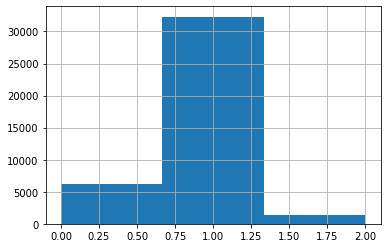

In [71]:
df.price_range.hist(bins=3)

#### city

In [72]:
df.city.nunique()

31

In [73]:
df.city.value_counts().index

Index(['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome',
       'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Hamburg',
       'Munich', 'Lyon', 'Stockholm', 'Budapest', 'Warsaw', 'Dublin',
       'Copenhagen', 'Athens', 'Edinburgh', 'Zurich', 'Oporto', 'Geneva',
       'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'],
      dtype='object')

In [74]:
df.head()

rest_id       city                                            cuisine  \
0  id_5569      Paris            ['European', 'French', 'International']   
1  id_1535  Stockholm                                                NaN   
2   id_352     London  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...   
3  id_3456     Berlin                                                NaN   
4   id_615     Munich  ['German', 'Central European', 'Vegetarian Fri...   

   ranking  rating  price_range  number_of_reviews  \
0   5570.0     3.5          1.0              194.0   
1   1537.0     4.0          1.0               10.0   
2    353.0     4.5          2.0              688.0   
3   3458.0     5.0          1.0                3.0   
4    621.0     4.0          1.0               84.0   

                                             reviews  
0  [['Good food at your doorstep', 'A good hotel ...  
1  [['Unique cuisine', 'Delicious Nepalese food']...  
2  [['Catch up with friends', 'Not exceptional'],...  
3                                           [[], []]  
4  [['Best place to try a Bavarian food', 'Nice b...

In [75]:
df.merge(pd.get_dummies(df.city),on=df.index);

In [76]:
'''City names are to be changed to numbers in order to be usable for the predicting model'''

'City names are to be changed to numbers in order to be usable for the predicting model'

In [77]:
'''dct={}
for i in range(0,df.city.nunique()):
    dct[df.city.value_counts().index[i]]=i'''

'dct={}\nfor i in range(0,df.city.nunique()):\n    dct[df.city.value_counts().index[i]]=i'

In [78]:
'''df.city=df.city.apply(txt_to_num)'''

'df.city=df.city.apply(txt_to_num)'

In [79]:
'''df.city.value_counts()'''

'df.city.value_counts()'

#### cuisine

In [80]:
df.cuisine.head()

0              ['European', 'French', 'International']
1                                                  NaN
2    ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
3                                                  NaN
4    ['German', 'Central European', 'Vegetarian Fri...
Name: cuisine, dtype: object

In [81]:
df.cuisine=df.cuisine.apply(str_clean)

In [82]:
df.cuisine=df.cuisine.apply(lambda x: str(x).split(','))

In [84]:
df.cuisine.head()

0                    [European, French, International]
1                                                [nan]
2    [Japanese, Sushi, Asian, Grill, VegetarianFrie...
3                                                [nan]
4        [German, CentralEuropean, VegetarianFriendly]
Name: cuisine, dtype: object

In [85]:
cuisines=set()

for record in df.cuisine:
    for cuisine in record:
        cuisines.add(cuisine)

len(cuisines)

126

In [37]:
for cuisine in cuisines:
    df[cuisine]=0

In [86]:
i=0
while i<2:
    for record in df.cuisine:
        for cuisine in record:
            display(cuisine)
    i+=1

'European'

'French'

'International'

'nan'

'Japanese'

'Sushi'

'Asian'

'Grill'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'German'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Italian'

'nan'

'Italian'

'Pizza'

'FastFood'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Healthy'

'Cafe'

'Japanese'

'Asian'

'Thai'

'Vietnamese'

'Bar'

'Pub'

'German'

'Chinese'

'German'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'Asian'

'Thai'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Cafe'

'British'

'Polish'

'International'

'European'

'Fusion'

'nan'

'nan'

'nan'

'nan'

'nan'

'Dutch'

'European'

'nan'

'Vietnamese'

'Italian'

'Pizza'

'Italian'

'Mexican'

'Venezuelan'

'SouthAmerican'

'Italian'

'Japanese'

'Sushi'

'Asian'

'French'

'nan'

'Bar'

'Cafe'

'Mediterranean'

'Pub'

'Asian'

'Thai'

'VegetarianFriendly'

'Soups'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pub'

'Japanese'

'Pizza'

'Italian'

'Belgian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'Chinese'

'FastFood'

'nan'

'French'

'Vietnamese'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'Latin'

'Barbecue'

'European'

'Argentinean'

'SouthAmerican'

'VegetarianFriendly'

'Cafe'

'Italian'

'nan'

'Japanese'

'Sushi'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Spanish'

'Healthy'

'Mediterranean'

'VegetarianFriendly'

'Irish'

'Seafood'

'European'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Japanese'

'Asian'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'Spanish'

'nan'

'Chinese'

'Asian'

'Italian'

'Pizza'

'Swiss'

'European'

'French'

'Irish'

'European'

'nan'

'Bar'

'International'

'nan'

'European'

'Portuguese'

'Mediterranean'

'Contemporary'

'WineBar'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Cafe'

'Seafood'

'Mediterranean'

'European'

'Greek'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'FastFood'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'Barbecue'

'Grill'

'VegetarianFriendly'

'Sushi'

'Mediterranean'

'Grill'

'Italian'

'German'

'European'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'VegetarianFriendly'

'nan'

'Italian'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'MiddleEastern'

'Turkish'

'FastFood'

'Healthy'

'SouthAmerican'

'Latin'

'CentralAmerican'

'Venezuelan'

'Pub'

'Bar'

'French'

'Seafood'

'European'

'nan'

'Healthy'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Chinese'

'Italian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'French'

'European'

'Hungarian'

'French'

'European'

'European'

'Portuguese'

'European'

'French'

'Seafood'

'nan'

'nan'

'Italian'

'Mediterranean'

'German'

'Chinese'

'Italian'

'French'

'Swiss'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Indian'

'MiddleEastern'

'Pakistani'

'Italian'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Peruvian'

'Asian'

'SouthAmerican'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Delicatessen'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Spanish'

'nan'

'Cafe'

'Cafe'

'Cafe'

'British'

'Greek'

'Bar'

'Polish'

'European'

'EasternEuropean'

'Steakhouse'

'Pub'

'VegetarianFriendly'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Italian'

'Pizza'

'VegetarianFriendly'

'Asian'

'Tibetan'

'Nepali'

'European'

'WineBar'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Italian'

'nan'

'Italian'

'Seafood'

'nan'

'Bar'

'Mediterranean'

'Spanish'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Spanish'

'European'

'VegetarianFriendly'

'Cafe'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Barbecue'

'Vietnamese'

'Healthy'

'VegetarianFriendly'

'British'

'Bar'

'European'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'Asian'

'Korean'

'nan'

'Steakhouse'

'Southwestern'

'Barbecue'

'Grill'

'WineBar'

'Cafe'

'Contemporary'

'French'

'German'

'VegetarianFriendly'

'nan'

'French'

'Cafe'

'International'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Czech'

'CentralEuropean'

'American'

'Contemporary'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'nan'

'Seafood'

'Mediterranean'

'European'

'Slovenian'

'VegetarianFriendly'

'French'

'European'

'Italian'

'Mediterranean'

'GlutenFreeOptions'

'American'

'Bar'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'Cafe'

'Contemporary'

'Pizza'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Turkish'

'Indian'

'MiddleEastern'

'Pakistani'

'nan'

'nan'

'Seafood'

'Italian'

'nan'

'nan'

'nan'

'nan'

'Italian'

'European'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Barbecue'

'VegetarianFriendly'

'VeganOptions'

'Balti'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Pizza'

'FastFood'

'Greek'

'StreetFood'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Peruvian'

'SouthAmerican'

'VegetarianFriendly'

'Italian'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Belgian'

'European'

'International'

'VegetarianFriendly'

'Spanish'

'Italian'

'Seafood'

'Mediterranean'

'European'

'Healthy'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'American'

'Bar'

'European'

'Pub'

'International'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pizza'

'FastFood'

'European'

'Healthy'

'Hungarian'

'VegetarianFriendly'

'FastFood'

'Mexican'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'Indian'

'Asian'

'Balti'

'EasternEuropean'

'VegetarianFriendly'

'Greek'

'nan'

'French'

'Healthy'

'Delicatessen'

'StreetFood'

'Sushi'

'French'

'nan'

'nan'

'nan'

'Mediterranean'

'European'

'Contemporary'

'Fusion'

'Diner'

'Bar'

'nan'

'Italian'

'American'

'FastFood'

'Diner'

'VegetarianFriendly'

'nan'

'Bar'

'Pub'

'International'

'Indian'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Argentinean'

'SouthAmerican'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Chinese'

'Japanese'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Spanish'

'nan'

'Greek'

'Japanese'

'Asian'

'Sushi'

'Asian'

'German'

'Cafe'

'European'

'Fusion'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'European'

'Portuguese'

'Indian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'Bar'

'French'

'Pub'

'American'

'Bar'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Steakhouse'

'nan'

'Spanish'

'WineBar'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'StreetFood'

'BrewPub'

'French'

'Mediterranean'

'European'

'Spanish'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Caribbean'

'Portuguese'

'Mediterranean'

'European'

'nan'

'Asian'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Asian'

'Thai'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'nan'

'European'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Chinese'

'Asian'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'Halal'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Korean'

'Japanese'

'French'

'European'

'International'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'American'

'Bar'

'Hungarian'

'European'

'Pub'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Barbecue'

'European'

'Portuguese'

'Italian'

'Japanese'

'Asian'

'nan'

'FastFood'

'European'

'Hungarian'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'French'

'American'

'Steakhouse'

'Bar'

'Barbecue'

'nan'

'Russian'

'Italian'

'Italian'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Latin'

'Venezuelan'

'French'

'European'

'VegetarianFriendly'

'Cafe'

'Portuguese'

'European'

'Mediterranean'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'French'

'Turkish'

'VegetarianFriendly'

'Cafe'

'Italian'

'Mediterranean'

'European'

'Chinese'

'Asian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'nan'

'American'

'VegetarianFriendly'

'Sushi'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'nan'

'Mexican'

'Latin'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'African'

'European'

'Contemporary'

'Portuguese'

'French'

'Bar'

'International'

'Pub'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Japanese'

'International'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Belgian'

'Bar'

'European'

'Pub'

'Italian'

'Pizza'

'Mediterranean'

'Vietnamese'

'StreetFood'

'Italian'

'Pizza'

'European'

'Contemporary'

'Seafood'

'Healthy'

'Pizza'

'Italian'

'Austrian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Spanish'

'Seafood'

'Mediterranean'

'European'

'Italian'

'nan'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Spanish'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'Contemporary'

'VegetarianFriendly'

'American'

'Pizza'

'Seafood'

'American'

'Bar'

'British'

'Mexican'

'American'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'European'

'Pub'

'WineBar'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'American'

'Bar'

'nan'

'Ethiopian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Pizza'

'VegetarianFriendly'

'European'

'Czech'

'nan'

'Moroccan'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'European'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'nan'

'Mediterranean'

'Egyptian'

'Cafe'

'British'

'nan'

'Spanish'

'Chinese'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Pizza'

'nan'

'Bar'

'Spanish'

'Pub'

'nan'

'Italian'

'nan'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'French'

'European'

'British'

'European'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'nan'

'French'

'WineBar'

'Mediterranean'

'MiddleEastern'

'Moroccan'

'nan'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'American'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'nan'

'Japanese'

'Sushi'

'French'

'European'

'Mexican'

'nan'

'nan'

'Italian'

'French'

'European'

'VegetarianFriendly'

'European'

'Danish'

'Scandinavian'

'Soups'

'International'

'nan'

'nan'

'Italian'

'Pizza'

'International'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Spanish'

'Italian'

'European'

'Contemporary'

'Danish'

'VegetarianFriendly'

'nan'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Lebanese'

'Mediterranean'

'VegetarianFriendly'

'Moroccan'

'MiddleEastern'

'African'

'Halal'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'nan'

'Peruvian'

'SouthAmerican'

'nan'

'VegetarianFriendly'

'Pub'

'International'

'Contemporary'

'Healthy'

'nan'

'Irish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Italian'

'Bar'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Irish'

'Bar'

'European'

'Pub'

'French'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'French'

'Bar'

'European'

'French'

'Seafood'

'Italian'

'StreetFood'

'Pizza'

'Spanish'

'Chinese'

'French'

'Swiss'

'European'

'Bar'

'Pub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'CentralEuropean'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'Halal'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'American'

'BrewPub'

'Cafe'

'WineBar'

'nan'

'British'

'Mediterranean'

'Spanish'

'European'

'nan'

'Cafe'

'European'

'Delicatessen'

'German'

'nan'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'nan'

'Bar'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'SouthAmerican'

'Bar'

'British'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'FastFood'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Brazilian'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'International'

'Mediterranean'

'Grill'

'Pub'

'nan'

'nan'

'French'

'European'

'Hungarian'

'EasternEuropean'

'Bar'

'International'

'CentralEuropean'

'Italian'

'French'

'Mediterranean'

'WineBar'

'nan'

'Japanese'

'Asian'

'VegetarianFriendly'

'nan'

'French'

'European'

'Bar'

'Pub'

'nan'

'Irish'

'Bar'

'European'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Turkish'

'Mediterranean'

'British'

'nan'

'Seafood'

'Italian'

'Pizza'

'Grill'

'nan'

'Turkish'

'MiddleEastern'

'Halal'

'Japanese'

'Sushi'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'French'

'Indian'

'Mediterranean'

'Italian'

'Cafe'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Healthy'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'VegetarianFriendly'

'SouthAmerican'

'Ecuadorean'

'Spanish'

'Moroccan'

'Mediterranean'

'European'

'CentralEuropean'

'Czech'

'French'

'Bar'

'Cafe'

'European'

'Pub'

'VegetarianFriendly'

'Dutch'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Chinese'

'nan'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'FastFood'

'International'

'European'

'Hungarian'

'Japanese'

'Sushi'

'Asian'

'FastFood'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Italian'

'European'

'Pizza'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Indian'

'Halal'

'nan'

'nan'

'Mediterranean'

'Spanish'

'WineBar'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Barbecue'

'European'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'Portuguese'

'Spanish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'CentralAmerican'

'Grill'

'nan'

'Chinese'

'FastFood'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Portuguese'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'nan'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'Chinese'

'Asian'

'Sushi'

'VegetarianFriendly'

'Italian'

'Mexican'

'FastFood'

'Spanish'

'Spanish'

'Polish'

'European'

'Italian'

'Italian'

'Peruvian'

'International'

'Healthy'

'SouthAmerican'

'European'

'Contemporary'

'Portuguese'

'Cafe'

'Portuguese'

'European'

'nan'

'French'

'European'

'Bar'

'Pub'

'Russian'

'EasternEuropean'

'European'

'VegetarianFriendly'

'Bar'

'Pub'

'BrewPub'

'Italian'

'Seafood'

'Mediterranean'

'Mediterranean'

'African'

'Portuguese'

'Soups'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'Pub'

'WineBar'

'FastFood'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'Israeli'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Kosher'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pizza'

'MiddleEastern'

'Cafe'

'German'

'French'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'European'

'Portuguese'

'Seafood'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'WineBar'

'Seafood'

'FastFood'

'British'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'Greek'

'nan'

'French'

'Steakhouse'

'European'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'GlutenFreeOptions'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'nan'

'European'

'Czech'

'Chinese'

'FastFood'

'Asian'

'Italian'

'Thai'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'Contemporary'

'VegetarianFriendly'

'Dutch'

'European'

'Spanish'

'nan'

'Japanese'

'Sushi'

'Asian'

'nan'

'International'

'Portuguese'

'French'

'Spanish'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Delicatessen'

'Contemporary'

'Gastropub'

'nan'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Italian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'European'

'British'

'European'

'Czech'

'CentralEuropean'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Soups'

'GlutenFreeOptions'

'VegetarianFriendly'

'Asian'

'Korean'

'nan'

'European'

'Spanish'

'British'

'American'

'International'

'Sushi'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Halal'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Portuguese'

'European'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'British'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'British'

'Cafe'

'VegetarianFriendly'

'nan'

'Pizza'

'BrewPub'

'nan'

'Australian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Steakhouse'

'European'

'Portuguese'

'Mediterranean'

'Fusion'

'nan'

'Spanish'

'Mediterranean'

'International'

'Cafe'

'Greek'

'nan'

'Bar'

'European'

'Belgian'

'Bar'

'VegetarianFriendly'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'Mediterranean'

'European'

'Portuguese'

'WineBar'

'Indian'

'MiddleEastern'

'Pakistani'

'VegetarianFriendly'

'European'

'Czech'

'Italian'

'Pizza'

'nan'

'Mexican'

'Chinese'

'Asian'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Chinese'

'Asian'

'Thai'

'Singaporean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'VegetarianFriendly'

'nan'

'Latin'

'Spanish'

'Italian'

'American'

'Spanish'

'Italian'

'Argentinean'

'nan'

'Asian'

'Thai'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Bar'

'Pub'

'nan'

'Italian'

'Seafood'

'nan'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'Pizza'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Chinese'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Japanese'

'Brazilian'

'Seafood'

'Sushi'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'European'

'EasternEuropean'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Pub'

'Scandinavian'

'Pizza'

'Mediterranean'

'Spanish'

'Irish'

'International'

'European'

'Healthy'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Delicatessen'

'WineBar'

'Bar'

'Diner'

'nan'

'European'

'Portuguese'

'Vietnamese'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'Italian'

'StreetFood'

'FastFood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Asian'

'Thai'

'Malaysian'

'Chinese'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Chinese'

'German'

'Delicatessen'

'MinorityChinese'

'Vietnamese'

'Cafe'

'European'

'Soups'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Spanish'

'Vietnamese'

'nan'

'Bar'

'European'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Cafe'

'Pub'

'Gastropub'

'International'

'British'

'French'

'Bar'

'European'

'Seafood'

'Mediterranean'

'Italian'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'nan'

'Bar'

'French'

'European'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Japanese'

'Asian'

'Spanish'

'Argentinean'

'SouthAmerican'

'Italian'

'VegetarianFriendly'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Spanish'

'French'

'Belgian'

'European'

'Portuguese'

'Argentinean'

'SouthAmerican'

'nan'

'European'

'Czech'

'nan'

'Vietnamese'

'Bar'

'Pub'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'nan'

'Mediterranean'

'Gastropub'

'Arabic'

'nan'

'Polish'

'European'

'Russian'

'EasternEuropean'

'Ukrainian'

'VegetarianFriendly'

'Cafe'

'CentralEuropean'

'Austrian'

'European'

'nan'

'European'

'CentralEuropean'

'Russian'

'Mediterranean'

'Cafe'

'Delicatessen'

'Italian'

'VegetarianFriendly'

'Spanish'

'International'

'nan'

'European'

'Portuguese'

'WineBar'

'Bar'

'Mediterranean'

'VegetarianFriendly'

'European'

'Portuguese'

'Bar'

'Cafe'

'Australian'

'VegetarianFriendly'

'Italian'

'International'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'GlutenFreeOptions'

'nan'

'Chinese'

'Seafood'

'VegetarianFriendly'

'nan'

'European'

'Seafood'

'GlutenFreeOptions'

'Bar'

'Indian'

'Irish'

'FastFood'

'British'

'Pub'

'nan'

'Cafe'

'Swedish'

'Delicatessen'

'Chinese'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'International'

'European'

'Hungarian'

'Cafe'

'Bar'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'French'

'European'

'nan'

'Thai'

'VegetarianFriendly'

'Chinese'

'FastFood'

'VegetarianFriendly'

'nan'

'nan'

'Irish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Contemporary'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'nan'

'Italian'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Seafood'

'FastFood'

'FastFood'

'Diner'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'Bar'

'European'

'Pub'

'nan'

'Lebanese'

'Mediterranean'

'Indian'

'Asian'

'VegetarianFriendly'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'nan'

'Pakistani'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'nan'

'African'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Turkish'

'Cafe'

'European'

'Greek'

'nan'

'Mediterranean'

'European'

'Asian'

'Vietnamese'

'Sushi'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Vietnamese'

'Italian'

'nan'

'International'

'Spanish'

'Bar'

'Pub'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Contemporary'

'Italian'

'Pizza'

'VegetarianFriendly'

'FastFood'

'Portuguese'

'Cafe'

'Indian'

'Moroccan'

'Bar'

'Mediterranean'

'European'

'Pub'

'Irish'

'Bar'

'European'

'British'

'Pub'

'Soups'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'FastFood'

'Vietnamese'

'Bar'

'Czech'

'CentralEuropean'

'European'

'Pub'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Mediterranean'

'Greek'

'Delicatessen'

'Healthy'

'Mexican'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Indian'

'Asian'

'nan'

'MiddleEastern'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Czech'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Japanese'

'Asian'

'Korean'

'StreetFood'

'Seafood'

'VegetarianFriendly'

'Gastropub'

'Irish'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'French'

'European'

'Cafe'

'Japanese'

'Brazilian'

'VegetarianFriendly'

'Sushi'

'Bar'

'Pub'

'European'

'Czech'

'CentralEuropean'

'Mediterranean'

'Spanish'

'International'

'VegetarianFriendly'

'VeganOptions'

'Thai'

'Italian'

'Pizza'

'nan'

'nan'

'Mediterranean'

'Spanish'

'European'

'Asian'

'Vietnamese'

'Diner'

'International'

'European'

'Contemporary'

'Mediterranean'

'VegetarianFriendly'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Polish'

'Bar'

'Pub'

'European'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Mediterranean'

'European'

'Spanish'

'Pub'

'BrewPub'

'Grill'

'Pub'

'Italian'

'Italian'

'American'

'Nepali'

'Tibetan'

'VeganOptions'

'International'

'Mediterranean'

'Spanish'

'Bar'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'GlutenFreeOptions'

'VeganOptions'

'American'

'Bar'

'European'

'Pub'

'Slovenian'

'Indian'

'nan'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'American'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Sushi'

'Greek'

'French'

'Brazilian'

'SouthAmerican'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'Bar'

'Pub'

'nan'

'Mediterranean'

'European'

'Spanish'

'Grill'

'VegetarianFriendly'

'European'

'Slovenian'

'CentralEuropean'

'Japanese'

'Sushi'

'Asian'

'GlutenFreeOptions'

'nan'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'American'

'Bar'

'Barbecue'

'Pub'

'French'

'Bar'

'British'

'Pub'

'nan'

'nan'

'Irish'

'Bar'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'European'

'Mediterranean'

'Mediterranean'

'Spanish'

'Italian'

'Steakhouse'

'Pizza'

'Mediterranean'

'Barbecue'

'Seafood'

'European'

'Spanish'

'Mediterranean'

'Italian'

'Mediterranean'

'nan'

'Japanese'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'Italian'

'Mediterranean'

'Japanese'

'Seafood'

'Sushi'

'Latin'

'Chilean'

'SouthAmerican'

'Spanish'

'nan'

'BrewPub'

'FastFood'

'Spanish'

'VegetarianFriendly'

'French'

'Japanese'

'Sushi'

'Asian'

'Korean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'European'

'Bar'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Sushi'

'nan'

'Bar'

'Grill'

'Pub'

'American'

'Diner'

'nan'

'nan'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Italian'

'Spanish'

'Bar'

'Pub'

'American'

'Moroccan'

'MiddleEastern'

'VeganOptions'

'Halal'

'Seafood'

'European'

'Scandinavian'

'Danish'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Contemporary'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Asian'

'Thai'

'nan'

'Irish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'European'

'Pub'

'Italian'

'Bar'

'Pizza'

'European'

'Pub'

'BrewPub'

'Chinese'

'Vietnamese'

'nan'

'Mediterranean'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'nan'

'BrewPub'

'Cafe'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'European'

'Asian'

'Italian'

'Seafood'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Soups'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Brazilian'

'Contemporary'

'Fusion'

'Portuguese'

'Italian'

'Gastropub'

'Italian'

'American'

'FastFood'

'Asian'

'Pizza'

'Chinese'

'Japanese'

'nan'

'Cafe'

'BrewPub'

'FastFood'

'Pub'

'StreetFood'

'American'

'Steakhouse'

'Bar'

'Pub'

'Gastropub'

'Grill'

'Indian'

'VegetarianFriendly'

'French'

'nan'

'Pizza'

'French'

'European'

'nan'

'Italian'

'Italian'

'Italian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'French'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Asian'

'Vietnamese'

'Bar'

'Cafe'

'European'

'Spanish'

'Mediterranean'

'nan'

'FastFood'

'nan'

'German'

'Bar'

'European'

'Gastropub'

'CentralEuropean'

'FastFood'

'American'

'Japanese'

'Sushi'

'Bar'

'British'

'Pub'

'European'

'Portuguese'

'Indian'

'Asian'

'nan'

'American'

'FastFood'

'Austrian'

'European'

'Contemporary'

'nan'

'German'

'VegetarianFriendly'

'Cafe'

'International'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Cafe'

'Italian'

'Cafe'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'nan'

'German'

'Lebanese'

'Mediterranean'

'nan'

'Austrian'

'European'

'Scandinavian'

'European'

'VegetarianFriendly'

'French'

'International'

'European'

'Hungarian'

'FastFood'

'Swiss'

'European'

'CentralEuropean'

'European'

'VegetarianFriendly'

'Pizza'

'Chinese'

'Japanese'

'Brazilian'

'SouthAmerican'

'American'

'Steakhouse'

'British'

'Austrian'

'CentralEuropean'

'German'

'European'

'VegetarianFriendly'

'French'

'European'

'European'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Czech'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'French'

'Bar'

'Pub'

'Gastropub'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Grill'

'American'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'American'

'Bar'

'European'

'Pub'

'CentralEuropean'

'Grill'

'French'

'European'

'VegetarianFriendly'

'Pizza'

'Mediterranean'

'European'

'Japanese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'International'

'VegetarianFriendly'

'FastFood'

'Halal'

'nan'

'Portuguese'

'European'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Austrian'

'European'

'Russian'

'EasternEuropean'

'Ukrainian'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'WineBar'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'Brazilian'

'SouthAmerican'

'American'

'Hungarian'

'FastFood'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Chinese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Thai'

'Bar'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'nan'

'nan'

'German'

'Australian'

'nan'

'International'

'Indian'

'nan'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'nan'

'Sushi'

'Seafood'

'French'

'Polish'

'European'

'Contemporary'

'French'

'European'

'VegetarianFriendly'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Halal'

'Bar'

'Pub'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Bar'

'Pub'

'Czech'

'Bar'

'FastFood'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Fusion'

'Portuguese'

'VegetarianFriendly'

'French'

'Contemporary'

'Pub'

'Gastropub'

'American'

'Steakhouse'

'Barbecue'

'European'

'VegetarianFriendly'

'Chinese'

'Asian'

'Mongolian'

'nan'

'Cafe'

'Italian'

'Cafe'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Lebanese'

'Moroccan'

'Mediterranean'

'MiddleEastern'

'Egyptian'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Indian'

'Asian'

'VegetarianFriendly'

'Halal'

'European'

'Russian'

'EasternEuropean'

'Chinese'

'Asian'

'Italian'

'Mediterranean'

'FastFood'

'International'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VegetarianFriendly'

'Bar'

'nan'

'nan'

'European'

'French'

'Polish'

'Bar'

'International'

'Pub'

'CentralEuropean'

'nan'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Steakhouse'

'Barbecue'

'GlutenFreeOptions'

'Fusion'

'Gastropub'

'British'

'Pub'

'Pub'

'WineBar'

'Gastropub'

'VegetarianFriendly'

'nan'

'Chinese'

'Asian'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'International'

'American'

'nan'

'French'

'European'

'nan'

'Chinese'

'nan'

'Italian'

'European'

'Spanish'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'African'

'European'

'French'

'Mediterranean'

'Bar'

'FastFood'

'Spanish'

'VegetarianFriendly'

'French'

'Belgian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Slovenian'

'CentralEuropean'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pizza'

'Italian'

'Bar'

'Contemporary'

'Pub'

'WineBar'

'Mediterranean'

'Spanish'

'nan'

'Bar'

'British'

'Pub'

'Mediterranean'

'European'

'Gastropub'

'nan'

'European'

'CentralEuropean'

'Hungarian'

'nan'

'American'

'FastFood'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Chinese'

'Italian'

'FastFood'

'Italian'

'nan'

'Asian'

'Korean'

'Cafe'

'FastFood'

'European'

'Portuguese'

'Italian'

'Seafood'

'nan'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Bar'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'Cafe'

'VegetarianFriendly'

'Austrian'

'European'

'American'

'Barbecue'

'EasternEuropean'

'Mediterranean'

'Austrian'

'European'

'Soups'

'VegetarianFriendly'

'nan'

'Chinese'

'Sushi'

'Thai'

'nan'

'Austrian'

'European'

'European'

'Hungarian'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'VegetarianFriendly'

'German'

'Cafe'

'European'

'VegetarianFriendly'

'Mediterranean'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'French'

'Spanish'

'Delicatessen'

'Grill'

'nan'

'Asian'

'nan'

'Chinese'

'American'

'Bar'

'FastFood'

'VegetarianFriendly'

'International'

'German'

'Swiss'

'European'

'Asian'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Sushi'

'Italian'

'Pizza'

'Mediterranean'

'BrewPub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'International'

'VegetarianFriendly'

'Italian'

'European'

'Scandinavian'

'American'

'FastFood'

'Diner'

'VegetarianFriendly'

'Japanese'

'Sushi'

'nan'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'European'

'VegetarianFriendly'

'Pizza'

'Turkish'

'French'

'FastFood'

'Healthy'

'Soups'

'French'

'Cafe'

'Healthy'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Thai'

'Pub'

'Bar'

'Asian'

'Bar'

'Pub'

'European'

'Czech'

'Portuguese'

'Steakhouse'

'Argentinean'

'CentralEuropean'

'Bar'

'European'

'Cafe'

'Greek'

'Pub'

'Gastropub'

'GlutenFreeOptions'

'nan'

'French'

'Cafe'

'Healthy'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Mediterranean'

'European'

'CentralEuropean'

'Bar'

'VegetarianFriendly'

'French'

'European'

'Steakhouse'

'Brazilian'

'Latin'

'Barbecue'

'Grill'

'SouthAmerican'

'Italian'

'Chinese'

'MinorityChinese'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'French'

'Spanish'

'Italian'

'Spanish'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'nan'

'European'

'British'

'Scottish'

'Pub'

'Irish'

'BrewPub'

'nan'

'Cafe'

'nan'

'Bar'

'Pizza'

'Spanish'

'Pub'

'French'

'International'

'Seafood'

'Italian'

'Mediterranean'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'American'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Barbecue'

'Pub'

'Spanish'

'French'

'European'

'Hungarian'

'Bar'

'Pizza'

'Cafe'

'Italian'

'Mediterranean'

'European'

'Contemporary'

'Indian'

'Asian'

'MiddleEastern'

'Pakistani'

'Halal'

'VegetarianFriendly'

'French'

'Bar'

'Spanish'

'Pub'

'European'

'Cafe'

'Indian'

'Asian'

'Balti'

'Halal'

'VegetarianFriendly'

'Belgian'

'European'

'Mediterranean'

'European'

'VegetarianFriendly'

'American'

'Italian'

'Pizza'

'nan'

'Latin'

'Spanish'

'Argentinean'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'Chinese'

'Thai'

'nan'

'Indian'

'Asian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Spanish'

'Mediterranean'

'Spanish'

'nan'

'European'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'VegetarianFriendly'

'Indian'

'Halal'

'VegetarianFriendly'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Italian'

'Pizza'

'European'

'Italian'

'Cafe'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'British'

'Gastropub'

'VegetarianFriendly'

'Japanese'

'Italian'

'Japanese'

'Sushi'

'nan'

'French'

'nan'

'French'

'International'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Italian'

'European'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'American'

'Steakhouse'

'Barbecue'

'Chinese'

'Asian'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'British'

'GlutenFreeOptions'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Hungarian'

'EasternEuropean'

'Turkish'

'nan'

'Lebanese'

'MiddleEastern'

'Halal'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'WineBar'

'FastFood'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'American'

'FastFood'

'Steakhouse'

'nan'

'Austrian'

'European'

'International'

'VegetarianFriendly'

'nan'

'nan'

'FastFood'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'American'

'Cafe'

'Bar'

'International'

'European'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Greek'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'StreetFood'

'VeganOptions'

'nan'

'Spanish'

'Japanese'

'Sushi'

'Irish'

'Bar'

'Pub'

'German'

'Diner'

'French'

'European'

'French'

'Cafe'

'European'

'International'

'Steakhouse'

'British'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Mediterranean'

'European'

'Spanish'

'Bar'

'British'

'Pub'

'French'

'Belgian'

'European'

'African'

'Ethiopian'

'nan'

'Indian'

'Asian'

'MiddleEastern'

'Pakistani'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Spanish'

'Malaysian'

'Spanish'

'Asian'

'Vietnamese'

'nan'

'nan'

'Asian'

'Thai'

'FastFood'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Mediterranean'

'MiddleEastern'

'European'

'Delicatessen'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'Halal'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'Caribbean'

'Latin'

'Cuban'

'CentralAmerican'

'nan'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Pizza'

'Pub'

'Bar'

'VegetarianFriendly'

'nan'

'nan'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Bar'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Soups'

'Belgian'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'European'

'Spanish'

'Mediterranean'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'nan'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'FastFood'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'International'

'European'

'VegetarianFriendly'

'Greek'

'Grill'

'French'

'Italian'

'International'

'European'

'CentralEuropean'

'Cafe'

'European'

'Portuguese'

'Spanish'

'nan'

'Grill'

'French'

'VegetarianFriendly'

'nan'

'Indian'

'MiddleEastern'

'Pakistani'

'Halal'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'Vietnamese'

'European'

'Latin'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'European'

'British'

'GlutenFreeOptions'

'Italian'

'European'

'Pizza'

'Mediterranean'

'Pub'

'Italian'

'Mediterranean'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Seafood'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Healthy'

'Italian'

'FastFood'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'nan'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'French'

'European'

'European'

'Portuguese'

'French'

'CentralEuropean'

'Czech'

'Lebanese'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Chinese'

'Asian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'European'

'Swedish'

'Scandinavian'

'Grill'

'nan'

'European'

'Portuguese'

'Italian'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'Cafe'

'European'

'Portuguese'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'Mediterranean'

'European'

'VegetarianFriendly'

'Austrian'

'European'

'Soups'

'Bar'

'European'

'British'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Irish'

'Bar'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'Italian'

'Italian'

'European'

'VegetarianFriendly'

'American'

'Barbecue'

'nan'

'Bar'

'European'

'Gastropub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Moroccan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'Cafe'

'European'

'European'

'WineBar'

'GlutenFreeOptions'

'nan'

'German'

'International'

'European'

'Gastropub'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'nan'

'French'

'European'

'VegetarianFriendly'

'French'

'Mediterranean'

'European'

'Bar'

'British'

'Pub'

'American'

'Steakhouse'

'British'

'nan'

'Mexican'

'Latin'

'FastFood'

'VegetarianFriendly'

'Mexican'

'SouthAmerican'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'International'

'European'

'Healthy'

'Dutch'

'VegetarianFriendly'

'Spanish'

'Italian'

'Pizza'

'Japanese'

'Italian'

'French'

'Fusion'

'VegetarianFriendly'

'FastFood'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Greek'

'Halal'

'VegetarianFriendly'

'Dutch'

'International'

'Mediterranean'

'European'

'German'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Spanish'

'American'

'Barbecue'

'VegetarianFriendly'

'nan'

'Bar'

'Pub'

'WineBar'

'Italian'

'French'

'European'

'Belgian'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Mediterranean'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Bar'

'Pub'

'VegetarianFriendly'

'French'

'FastFood'

'Indian'

'Cafe'

'Fusion'

'Healthy'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Pub'

'Italian'

'VegetarianFriendly'

'nan'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'International'

'Italian'

'Mediterranean'

'WineBar'

'Italian'

'nan'

'nan'

'nan'

'German'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Japanese'

'Brazilian'

'Sushi'

'SouthAmerican'

'nan'

'FastFood'

'European'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Pizza'

'British'

'Pub'

'VegetarianFriendly'

'French'

'WineBar'

'Italian'

'Indian'

'European'

'Czech'

'German'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Cafe'

'Czech'

'International'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'French'

'Steakhouse'

'European'

'Japanese'

'Spanish'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Grill'

'French'

'Bar'

'French'

'nan'

'French'

'Belgian'

'European'

'Pub'

'Gastropub'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'WineBar'

'Bar'

'Mediterranean'

'Pub'

'Seafood'

'GlutenFreeOptions'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'European'

'CentralEuropean'

'German'

'Austrian'

'Fusion'

'VegetarianFriendly'

'Mexican'

'nan'

'Japanese'

'Bar'

'American'

'BrewPub'

'European'

'Pub'

'Mexican'

'American'

'Grill'

'Gastropub'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'Italian'

'Bar'

'Cafe'

'Delicatessen'

'Pub'

'Italian'

'nan'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Bar'

'British'

'Pub'

'Mediterranean'

'European'

'Spanish'

'European'

'WineBar'

'Hungarian'

'CentralEuropean'

'nan'

'Indian'

'Asian'

'nan'

'nan'

'Chinese'

'Asian'

'Polish'

'European'

'Soups'

'EasternEuropean'

'VegetarianFriendly'

'nan'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'French'

'European'

'Czech'

'Bar'

'Pub'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Indian'

'German'

'European'

'CentralEuropean'

'Mediterranean'

'VegetarianFriendly'

'French'

'WineBar'

'Bar'

'European'

'VegetarianFriendly'

'Healthy'

'StreetFood'

'Venezuelan'

'Latin'

'SouthAmerican'

'VegetarianFriendly'

'German'

'Diner'

'Gastropub'

'Mediterranean'

'European'

'Spanish'

'Bar'

'Pub'

'nan'

'Italian'

'Pizza'

'nan'

'nan'

'nan'

'Chinese'

'Spanish'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'American'

'Pub'

'Gastropub'

'Bar'

'French'

'European'

'nan'

'nan'

'Bar'

'Seafood'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Japanese'

'Asian'

'Vietnamese'

'Korean'

'Bar'

'British'

'Pub'

'Grill'

'VegetarianFriendly'

'Pub'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Diner'

'Italian'

'Healthy'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Chinese'

'Asian'

'Fusion'

'VegetarianFriendly'

'nan'

'Bar'

'European'

'Pub'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Kosher'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Asian'

'Asian'

'Thai'

'Spanish'

'Mediterranean'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'BrewPub'

'Mediterranean'

'Greek'

'Pub'

'WineBar'

'Mexican'

'International'

'Contemporary'

'nan'

'Cafe'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Pizza'

'Austrian'

'European'

'International'

'Contemporary'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'Japanese'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'nan'

'Cafe'

'British'

'Healthy'

'VegetarianFriendly'

'European'

'Danish'

'Bar'

'Cafe'

'Pub'

'nan'

'nan'

'Pizza'

'Seafood'

'nan'

'nan'

'Bar'

'Spanish'

'Pub'

'VegetarianFriendly'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Italian'

'Pizza'

'British'

'Grill'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'European'

'Pub'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'Sushi'

'Asian'

'Thai'

'American'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'Soups'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'French'

'nan'

'nan'

'French'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Polish'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'European'

'EasternEuropean'

'British'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Steakhouse'

'Grill'

'nan'

'African'

'Ethiopian'

'nan'

'Portuguese'

'Grill'

'Halal'

'FastFood'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'American'

'Bar'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'nan'

'Contemporary'

'Japanese'

'Seafood'

'nan'

'Cafe'

'European'

'Hungarian'

'CentralEuropean'

'Spanish'

'MiddleEastern'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'British'

'Pub'

'European'

'Hungarian'

'nan'

'Mediterranean'

'Egyptian'

'Arabic'

'MiddleEastern'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Swiss'

'Bar'

'Mediterranean'

'Greek'

'nan'

'Italian'

'Pizza'

'Austrian'

'Polish'

'European'

'Russian'

'EasternEuropean'

'Ukrainian'

'German'

'European'

'Pub'

'Gastropub'

'Austrian'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Scottish'

'Asian'

'Tibetan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'International'

'Mediterranean'

'European'

'Hungarian'

'Chinese'

'Thai'

'Indian'

'Italian'

'Indian'

'Bar'

'International'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Spanish'

'Cafe'

'European'

'Czech'

'International'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'European'

'Danish'

'Italian'

'European'

'CentralEuropean'

'German'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'Contemporary'

'nan'

'nan'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'Czech'

'Pub'

'EasternEuropean'

'CentralEuropean'

'French'

'European'

'VegetarianFriendly'

'Asian'

'Malaysian'

'nan'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Italian'

'American'

'Bar'

'Mediterranean'

'Pub'

'Gastropub'

'Cafe'

'Healthy'

'VegetarianFriendly'

'French'

'European'

'Russian'

'EasternEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Austrian'

'Bar'

'European'

'CentralEuropean'

'BrewPub'

'VegetarianFriendly'

'GlutenFreeOptions'

'British'

'nan'

'nan'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Mediterranean'

'International'

'European'

'Greek'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'nan'

'Mexican'

'VegetarianFriendly'

'Chinese'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'British'

'Cafe'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'French'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Polish'

'European'

'nan'

'nan'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'VegetarianFriendly'

'Japanese'

'Indian'

'Spanish'

'British'

'Fusion'

'European'

'Scandinavian'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Spanish'

'nan'

'nan'

'nan'

'Bar'

'Pub'

'BrewPub'

'European'

'VegetarianFriendly'

'Pizza'

'British'

'Cafe'

'nan'

'nan'

'Chinese'

'Asian'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Contemporary'

'Mediterranean'

'nan'

'American'

'International'

'Indian'

'Asian'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Turkish'

'Japanese'

'nan'

'nan'

'Bar'

'Pub'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Greek'

'nan'

'Italian'

'Pizza'

'Cafe'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Pizza'

'Italian'

'VegetarianFriendly'

'French'

'nan'

'nan'

'Italian'

'Italian'

'Italian'

'Pizza'

'French'

'International'

'Mediterranean'

'European'

'Spanish'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Fusion'

'Steakhouse'

'British'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'German'

'International'

'Mediterranean'

'Soups'

'nan'

'Italian'

'French'

'Italian'

'Pizza'

'European'

'nan'

'Russian'

'European'

'EasternEuropean'

'MiddleEastern'

'Mexican'

'American'

'Indian'

'Caribbean'

'FastFood'

'nan'

'Italian'

'Bar'

'European'

'Contemporary'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'nan'

'American'

'FastFood'

'Diner'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Spanish'

'Seafood'

'European'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'nan'

'French'

'Bar'

'European'

'Cafe'

'VegetarianFriendly'

'nan'

'Pizza'

'nan'

'Italian'

'Mediterranean'

'WineBar'

'French'

'Pizza'

'Japanese'

'Peruvian'

'Sushi'

'Asian'

'Fusion'

'French'

'European'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Barbecue'

'European'

'Grill'

'Mexican'

'Latin'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'VeganOptions'

'International'

'Barbecue'

'MiddleEastern'

'Arabic'

'Italian'

'Spanish'

'Italian'

'French'

'Italian'

'International'

'Mediterranean'

'VegetarianFriendly'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'European'

'Asian'

'Indonesian'

'Asian'

'French'

'WineBar'

'Indian'

'Asian'

'Halal'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'International'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'Cafe'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Hungarian'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Bar'

'American'

'FastFood'

'VegetarianFriendly'

'Italian'

'French'

'Seafood'

'French'

'Bar'

'Cafe'

'Pub'

'European'

'Czech'

'Spanish'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'nan'

'Bar'

'Seafood'

'British'

'Pub'

'Gastropub'

'French'

'Healthy'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'VeganOptions'

'nan'

'Mediterranean'

'Spanish'

'Sushi'

'French'

'Bar'

'Pub'

'Irish'

'Bar'

'European'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'American'

'Chinese'

'nan'

'FastFood'

'Soups'

'Cafe'

'VegetarianFriendly'

'Italian'

'Mexican'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Barbecue'

'Turkish'

'American'

'Barbecue'

'European'

'Healthy'

'VegetarianFriendly'

'French'

'Bar'

'European'

'nan'

'nan'

'European'

'Spanish'

'Chinese'

'Japanese'

'nan'

'nan'

'nan'

'Portuguese'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'SouthAmerican'

'Colombian'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'European'

'Czech'

'Caribbean'

'FastFood'

'Jamaican'

'VegetarianFriendly'

'VeganOptions'

'European'

'British'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Mediterranean'

'StreetFood'

'VegetarianFriendly'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'Cafe'

'International'

'Mediterranean'

'Contemporary'

'Healthy'

'nan'

'American'

'Irish'

'Pub'

'Gastropub'

'Bar'

'Pizza'

'nan'

'Italian'

'Belgian'

'Bar'

'European'

'Pub'

'European'

'Scandinavian'

'Norwegian'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'nan'

'Cafe'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'French'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'nan'

'European'

'Cafe'

'French'

'European'

'nan'

'Austrian'

'Bar'

'Cafe'

'European'

'Pub'

'African'

'European'

'Portuguese'

'French'

'VegetarianFriendly'

'Indian'

'German'

'Bar'

'Diner'

'VegetarianFriendly'

'Seafood'

'nan'

'nan'

'Italian'

'International'

'European'

'Chinese'

'nan'

'Italian'

'French'

'Bar'

'Cafe'

'European'

'Bar'

'Spanish'

'Pub'

'French'

'Bar'

'Cafe'

'Pub'

'Healthy'

'Mediterranean'

'Cafe'

'Mediterranean'

'Spanish'

'Healthy'

'Italian'

'Cafe'

'StreetFood'

'VegetarianFriendly'

'French'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'Mediterranean'

'Spanish'

'nan'

'nan'

'nan'

'European'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Polish'

'International'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Polish'

'European'

'CentralEuropean'

'Barbecue'

'European'

'Portuguese'

'Japanese'

'Sushi'

'Asian'

'Grill'

'Bar'

'Mediterranean'

'Spanish'

'GlutenFreeOptions'

'French'

'VegetarianFriendly'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Greek'

'Italian'

'Pub'

'Irish'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'StreetFood'

'FastFood'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'French'

'European'

'nan'

'Bar'

'Mediterranean'

'Spanish'

'nan'

'nan'

'French'

'Delicatessen'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Cafe'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'VegetarianFriendly'

'Grill'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'nan'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'nan'

'Asian'

'Chinese'

'Thai'

'Malaysian'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'nan'

'Spanish'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Asian'

'Soups'

'Sushi'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Asian'

'Malaysian'

'Chinese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'International'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'Mexican'

'American'

'Bar'

'Italian'

'German'

'Fusion'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'CentralEuropean'

'Spanish'

'nan'

'American'

'nan'

'Chinese'

'Asian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'French'

'nan'

'Chinese'

'Italian'

'European'

'nan'

'French'

'Swiss'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Portuguese'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'French'

'nan'

'Portuguese'

'WineBar'

'VegetarianFriendly'

'Vietnamese'

'VegetarianFriendly'

'nan'

'International'

'Contemporary'

'Healthy'

'VegetarianFriendly'

'French'

'VegetarianFriendly'

'nan'

'VegetarianFriendly'

'Chinese'

'Asian'

'Italian'

'Pizza'

'French'

'VegetarianFriendly'

'Chinese'

'Asian'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'Asian'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Healthy'

'Hawaiian'

'VegetarianFriendly'

'GlutenFreeOptions'

'WineBar'

'Italian'

'Mediterranean'

'Pizza'

'American'

'FastFood'

'Chinese'

'Italian'

'International'

'nan'

'Italian'

'Pizza'

'Polish'

'European'

'Bar'

'International'

'European'

'Czech'

'Bar'

'Cafe'

'Pub'

'nan'

'Seafood'

'Mediterranean'

'Spanish'

'nan'

'Mediterranean'

'Greek'

'Bar'

'Pub'

'European'

'Swedish'

'French'

'French'

'VegetarianFriendly'

'nan'

'Bar'

'Pub'

'American'

'BrewPub'

'Pub'

'Italian'

'VegetarianFriendly'

'Italian'

'Irish'

'Bar'

'Pub'

'BrewPub'

'International'

'nan'

'Indian'

'nan'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Turkish'

'Bar'

'European'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Swiss'

'European'

'Grill'

'Healthy'

'Soups'

'nan'

'Japanese'

'Fusion'

'MiddleEastern'

'nan'

'Italian'

'Mediterranean'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'African'

'VegetarianFriendly'

'VeganOptions'

'French'

'Cafe'

'Irish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'European'

'Cafe'

'Mediterranean'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Steakhouse'

'Barbecue'

'European'

'Argentinean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'nan'

'Cafe'

'Bar'

'Pub'

'Caribbean'

'Indian'

'FastFood'

'nan'

'French'

'Bar'

'European'

'Pub'

'Contemporary'

'nan'

'Italian'

'VegetarianFriendly'

'European'

'Portuguese'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'American'

'European'

'Czech'

'Italian'

'International'

'Mediterranean'

'Indian'

'Indian'

'Seafood'

'European'

'Portuguese'

'German'

'Bar'

'Pub'

'European'

'British'

'International'

'VegetarianFriendly'

'Cafe'

'FastFood'

'Delicatessen'

'Healthy'

'nan'

'nan'

'German'

'Austrian'

'Swiss'

'European'

'CentralEuropean'

'Seafood'

'Pub'

'Gastropub'

'European'

'French'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Gastropub'

'VegetarianFriendly'

'Sushi'

'nan'

'French'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Kosher'

'nan'

'FastFood'

'British'

'American'

'Steakhouse'

'European'

'Mediterranean'

'Italian'

'French'

'Spanish'

'Pizza'

'Italian'

'nan'

'Caribbean'

'Latin'

'Venezuelan'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'European'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'nan'

'Irish'

'Seafood'

'European'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Pizza'

'FastFood'

'nan'

'Italian'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Barbecue'

'Fusion'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Seafood'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Portuguese'

'Mediterranean'

'FastFood'

'Chinese'

'Japanese'

'Asian'

'Seafood'

'Sushi'

'Thai'

'VegetarianFriendly'

'Italian'

'MiddleEastern'

'Arabic'

'Japanese'

'Irish'

'Bar'

'European'

'Pub'

'Spanish'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Cafe'

'FastFood'

'nan'

'Greek'

'Polish'

'European'

'French'

'European'

'French'

'nan'

'Indian'

'Asian'

'Balti'

'Fusion'

'VegetarianFriendly'

'Halal'

'International'

'Mediterranean'

'Spanish'

'Mediterranean'

'Contemporary'

'Cafe'

'MiddleEastern'

'nan'

'nan'

'nan'

'European'

'VegetarianFriendly'

'Thai'

'Moroccan'

'MiddleEastern'

'African'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'French'

'European'

'French'

'European'

'VegetarianFriendly'

'American'

'FastFood'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Pub'

'Irish'

'Pub'

'WineBar'

'Steakhouse'

'Irish'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Mexican'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'Soups'

'Irish'

'European'

'nan'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'WineBar'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'European'

'WineBar'

'Spanish'

'Fusion'

'Mediterranean'

'nan'

'Greek'

'African'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'nan'

'nan'

'European'

'VegetarianFriendly'

'British'

'Scottish'

'Cafe'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Swiss'

'European'

'Greek'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Delicatessen'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'FastFood'

'Asian'

'FastFood'

'Turkish'

'MiddleEastern'

'Halal'

'European'

'Portuguese'

'Pizza'

'Lebanese'

'Mediterranean'

'nan'

'Italian'

'American'

'FastFood'

'nan'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'International'

'Thai'

'Vietnamese'

'nan'

'European'

'Danish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'British'

'Scottish'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'French'

'European'

'nan'

'nan'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Halal'

'American'

'FastFood'

'VegetarianFriendly'

'French'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'French'

'European'

'Italian'

'Italian'

'Seafood'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'Cafe'

'British'

'Contemporary'

'American'

'Steakhouse'

'nan'

'Mexican'

'Bar'

'Pub'

'Dutch'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Hungarian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'French'

'American'

'Bar'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Chinese'

'Asian'

'African'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Pizza'

'European'

'Portuguese'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Bar'

'British'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'German'

'Austrian'

'BrewPub'

'European'

'Pub'

'Gastropub'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'nan'

'Mediterranean'

'Italian'

'Seafood'

'nan'

'nan'

'Mediterranean'

'European'

'nan'

'Italian'

'FastFood'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Thai'

'nan'

'French'

'Irish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'French'

'Japanese'

'American'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'CentralEuropean'

'Hungarian'

'Japanese'

'French'

'European'

'Mediterranean'

'Spanish'

'Sushi'

'Spanish'

'French'

'Contemporary'

'VegetarianFriendly'

'nan'

'Japanese'

'Indian'

'European'

'Portuguese'

'Bar'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'European'

'Bar'

'Irish'

'Contemporary'

'Pub'

'Mediterranean'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Chinese'

'Seafood'

'Greek'

'Spanish'

'European'

'International'

'Healthy'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Moroccan'

'Mediterranean'

'FastFood'

'Turkish'

'MiddleEastern'

'German'

'VegetarianFriendly'

'Steakhouse'

'European'

'Pub'

'Gastropub'

'SouthAmerican'

'Mediterranean'

'European'

'Greek'

'Seafood'

'VegetarianFriendly'

'Irish'

'FastFood'

'Italian'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Bar'

'Pub'

'WineBar'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'GlutenFreeOptions'

'nan'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'nan'

'International'

'nan'

'Italian'

'Cafe'

'VegetarianFriendly'

'Italian'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Thai'

'nan'

'Italian'

'European'

'Pizza'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'nan'

'nan'

'Spanish'

'Bar'

'Pub'

'Bar'

'Pub'

'WineBar'

'FastFood'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Mediterranean'

'Turkish'

'Delicatessen'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'nan'

'Austrian'

'European'

'CentralEuropean'

'Spanish'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Delicatessen'

'nan'

'French'

'French'

'Fusion'

'VegetarianFriendly'

'American'

'French'

'European'

'Hungarian'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Thai'

'Mediterranean'

'American'

'Bar'

'Cafe'

'Spanish'

'Pub'

'International'

'nan'

'European'

'International'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'Asian'

'Chinese'

'Japanese'

'Korean'

'French'

'Bar'

'European'

'European'

'Hungarian'

'nan'

'French'

'American'

'BrewPub'

'FastFood'

'Pub'

'French'

'European'

'nan'

'European'

'Czech'

'Bar'

'Pub'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'Balti'

'EasternEuropean'

'VegetarianFriendly'

'European'

'Portuguese'

'Swiss'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Italian'

'Japanese'

'Sushi'

'nan'

'WineBar'

'Italian'

'Diner'

'VegetarianFriendly'

'Irish'

'BrewPub'

'Pub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'Vietnamese'

'French'

'BrewPub'

'Bar'

'Pub'

'Diner'

'WineBar'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'Healthy'

'nan'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Spanish'

'nan'

'Bar'

'International'

'British'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'German'

'European'

'Gastropub'

'CentralEuropean'

'Mediterranean'

'Spanish'

'Contemporary'

'Diner'

'nan'

'nan'

'Italian'

'Pizza'

'Austrian'

'European'

'CentralEuropean'

'Japanese'

'Italian'

'French'

'Italian'

'Indian'

'Spanish'

'BrewPub'

'Mediterranean'

'BrewPub'

'Bar'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Italian'

'Mediterranean'

'Bar'

'nan'

'nan'

'Bar'

'British'

'Pub'

'BrewPub'

'VegetarianFriendly'

'European'

'Vietnamese'

'nan'

'French'

'Chinese'

'Indian'

'Italian'

'Seafood'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Gastropub'

'Bar'

'Italian'

'BrewPub'

'Bar'

'European'

'German'

'Cafe'

'British'

'Healthy'

'International'

'Contemporary'

'nan'

'nan'

'nan'

'Mediterranean'

'Greek'

'MiddleEastern'

'Armenian'

'Arabic'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'nan'

'Mediterranean'

'Italian'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Contemporary'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Spanish'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'European'

'Chinese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'Argentinean'

'SouthAmerican'

'French'

'nan'

'German'

'European'

'CentralEuropean'

'American'

'Mediterranean'

'Barbecue'

'Thai'

'Delicatessen'

'American'

'Pizza'

'Bar'

'Pub'

'Pub'

'Bar'

'British'

'Japanese'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Pizza'

'Italian'

'Spanish'

'nan'

'Mediterranean'

'Spanish'

'Mediterranean'

'Spanish'

'Spanish'

'FastFood'

'VegetarianFriendly'

'Mediterranean'

'European'

'Greek'

'Mediterranean'

'Italian'

'Mediterranean'

'nan'

'Bar'

'British'

'Pub'

'nan'

'American'

'French'

'International'

'Turkish'

'Mediterranean'

'Barbecue'

'British'

'European'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Fusion'

'Asian'

'Thai'

'American'

'Bar'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Greek'

'Bar'

'Pub'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'nan'

'Cafe'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'International'

'WineBar'

'VegetarianFriendly'

'French'

'European'

'Contemporary'

'GlutenFreeOptions'

'VegetarianFriendly'

'Polish'

'International'

'European'

'Japanese'

'Sushi'

'VegetarianFriendly'

'nan'

'nan'

'French'

'European'

'Swiss'

'European'

'Contemporary'

'Healthy'

'VegetarianFriendly'

'Cafe'

'European'

'Healthy'

'Portuguese'

'Soups'

'Steakhouse'

'American'

'European'

'European'

'Czech'

'Bar'

'European'

'Pub'

'Italian'

'European'

'VegetarianFriendly'

'Spanish'

'nan'

'Italian'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'Belgian'

'Seafood'

'European'

'Asian'

'Malaysian'

'VegetarianFriendly'

'Halal'

'Pub'

'nan'

'Cafe'

'Italian'

'FastFood'

'Italian'

'Pizza'

'Mediterranean'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'Mediterranean'

'European'

'British'

'French'

'European'

'nan'

'nan'

'nan'

'Cafe'

'FastFood'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Turkish'

'MiddleEastern'

'Spanish'

'GlutenFreeOptions'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'Gastropub'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mexican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Turkish'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Pub'

'Bar'

'European'

'Scandinavian'

'Italian'

'Pizza'

'StreetFood'

'Italian'

'FastFood'

'Brazilian'

'Latin'

'Barbecue'

'SouthAmerican'

'Italian'

'Pizza'

'International'

'VegetarianFriendly'

'VeganOptions'

'Moroccan'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Lebanese'

'Mediterranean'

'Italian'

'Mediterranean'

'nan'

'French'

'European'

'Spanish'

'Mediterranean'

'Cafe'

'Soups'

'nan'

'Bar'

'Pub'

'Italian'

'Pizza'

'FastFood'

'WineBar'

'European'

'Spanish'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'International'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Healthy'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'nan'

'Italian'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Spanish'

'Soups'

'GlutenFreeOptions'

'Asian'

'European'

'Steakhouse'

'Swiss'

'Barbecue'

'VegetarianFriendly'

'nan'

'French'

'Healthy'

'Cafe'

'Pizza'

'Japanese'

'Sushi'

'Kosher'

'Italian'

'Seafood'

'Mediterranean'

'Contemporary'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Kosher'

'GlutenFreeOptions'

'European'

'Hungarian'

'Indian'

'American'

'Bar'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Indonesian'

'VegetarianFriendly'

'American'

'Delicatessen'

'Contemporary'

'Latin'

'Spanish'

'SouthAmerican'

'nan'

'Peruvian'

'FastFood'

'Spanish'

'Asian'

'Taiwanese'

'Soups'

'SouthAmerican'

'nan'

'Greek'

'Irish'

'Cafe'

'European'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Indian'

'Dutch'

'European'

'Healthy'

'CentralEuropean'

'nan'

'nan'

'Steakhouse'

'Barbecue'

'Argentinean'

'SouthAmerican'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'Mediterranean'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'Japanese'

'Sushi'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'StreetFood'

'Greek'

'European'

'Portuguese'

'Austrian'

'Barbecue'

'European'

'French'

'Italian'

'nan'

'Italian'

'Cafe'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'BrewPub'

'Polish'

'Bar'

'European'

'Pub'

'Italian'

'Pizza'

'Bar'

'European'

'Hungarian'

'Cafe'

'International'

'French'

'Italian'

'Mediterranean'

'Barbecue'

'Pizza'

'Mediterranean'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'nan'

'Spanish'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'MiddleEastern'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Indian'

'Pizza'

'European'

'Portuguese'

'nan'

'VegetarianFriendly'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'European'

'Scandinavian'

'Danish'

'Italian'

'Sushi'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Fusion'

'French'

'Mediterranean'

'Spanish'

'Cafe'

'nan'

'European'

'French'

'European'

'Japanese'

'Italian'

'Bar'

'Contemporary'

'Pub'

'WineBar'

'Cafe'

'Bar'

'Polish'

'European'

'European'

'Czech'

'Italian'

'Bar'

'Mediterranean'

'European'

'WineBar'

'Slovenian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'European'

'Spanish'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'nan'

'French'

'Bar'

'European'

'nan'

'nan'

'Steakhouse'

'Barbecue'

'Grill'

'Diner'

'Healthy'

'StreetFood'

'European'

'European'

'Seafood'

'International'

'British'

'Diner'

'Spanish'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'Halal'

'French'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'VegetarianFriendly'

'Portuguese'

'Mediterranean'

'European'

'Spanish'

'Polish'

'European'

'nan'

'nan'

'nan'

'French'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Polish'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'Czech'

'European'

'EasternEuropean'

'CentralEuropean'

'Kosher'

'Italian'

'Mediterranean'

'nan'

'Spanish'

'American'

'Bar'

'International'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'nan'

'Mediterranean'

'Greek'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'FastFood'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Healthy'

'Danish'

'MiddleEastern'

'Cafe'

'Italian'

'International'

'British'

'European'

'Czech'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'nan'

'American'

'Bar'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Steakhouse'

'European'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Arabic'

'Egyptian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Halal'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'European'

'Portuguese'

'nan'

'Italian'

'American'

'GlutenFreeOptions'

'Bar'

'Pub'

'German'

'Swiss'

'European'

'Grill'

'nan'

'Mediterranean'

'Italian'

'European'

'Czech'

'Indian'

'Asian'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Mediterranean'

'Delicatessen'

'CentralEuropean'

'VegetarianFriendly'

'American'

'FastFood'

'International'

'Pub'

'Scandinavian'

'Danish'

'Bar'

'European'

'French'

'nan'

'Bar'

'British'

'Pub'

'International'

'VegetarianFriendly'

'Japanese'

'Diner'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Asian'

'Cafe'

'Bar'

'SouthAmerican'

'nan'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'Healthy'

'VegetarianFriendly'

'Halal'

'GlutenFreeOptions'

'VeganOptions'

'Cafe'

'FastFood'

'International'

'Healthy'

'StreetFood'

'French'

'American'

'Mediterranean'

'European'

'Spanish'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'nan'

'Turkish'

'Barbecue'

'MiddleEastern'

'Halal'

'Chinese'

'Italian'

'Pizza'

'nan'

'Mediterranean'

'Spanish'

'Bar'

'Pub'

'Thai'

'Spanish'

'Indian'

'Cafe'

'Scottish'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'French'

'Lebanese'

'International'

'Mediterranean'

'Healthy'

'Thai'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'British'

'French'

'Delicatessen'

'European'

'VegetarianFriendly'

'French'

'American'

'Steakhouse'

'Barbecue'

'European'

'nan'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Japanese'

'Asian'

'VegetarianFriendly'

'nan'

'European'

'Soups'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Mediterranean'

'European'

'Spanish'

'Japanese'

'nan'

'Czech'

'European'

'Pizza'

'VegetarianFriendly'

'Irish'

'Cafe'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'Barbecue'

'Greek'

'Italian'

'Peruvian'

'SouthAmerican'

'Mediterranean'

'European'

'Portuguese'

'German'

'European'

'CentralEuropean'

'Spanish'

'nan'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Asian'

'Thai'

'Korean'

'European'

'Soups'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Indian'

'nan'

'Cafe'

'British'

'International'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'nan'

'Cafe'

'British'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'FastFood'

'American'

'WineBar'

'nan'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Chinese'

'European'

'Asian'

'Diner'

'Healthy'

'French'

'American'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Cafe'

'European'

'Portuguese'

'nan'

'Italian'

'Mediterranean'

'Pizza'

'Seafood'

'Diner'

'VegetarianFriendly'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'French'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'VegetarianFriendly'

'Turkish'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'nan'

'Japanese'

'Sushi'

'Asian'

'GlutenFreeOptions'

'Indian'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'WineBar'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'nan'

'nan'

'Japanese'

'Asian'

'Sushi'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'British'

'Scottish'

'European'

'Portuguese'

'Mediterranean'

'Italian'

'Italian'

'International'

'European'

'Czech'

'Cafe'

'Soups'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'nan'

'International'

'European'

'CentralEuropean'

'Hungarian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Belgian'

'Bar'

'Mediterranean'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'European'

'Spanish'

'International'

'Mediterranean'

'nan'

'Cafe'

'British'

'Contemporary'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Seafood'

'VegetarianFriendly'

'French'

'Seafood'

'Mediterranean'

'Spanish'

'Indian'

'Asian'

'VegetarianFriendly'

'Halal'

'International'

'Spanish'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'Sushi'

'European'

'Spanish'

'Portuguese'

'nan'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Vietnamese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Austrian'

'European'

'French'

'European'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'European'

'Pub'

'Czech'

'Sushi'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Bar'

'Pub'

'Grill'

'nan'

'French'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'French'

'Pizza'

'Bar'

'Pub'

'British'

'Grill'

'nan'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Bar'

'Spanish'

'Pub'

'Hungarian'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Cafe'

'Barbecue'

'Turkish'

'nan'

'nan'

'Bar'

'nan'

'Mexican'

'Latin'

'SouthAmerican'

'CentralAmerican'

'European'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Korean'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'International'

'Spanish'

'Bar'

'European'

'French'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'British'

'Bar'

'FastFood'

'Mediterranean'

'Spanish'

'Italian'

'Mediterranean'

'European'

'Italian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'FastFood'

'Chinese'

'Asian'

'VegetarianFriendly'

'Latin'

'Venezuelan'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'Chinese'

'VegetarianFriendly'

'Mediterranean'

'MiddleEastern'

'Persian'

'nan'

'French'

'Steakhouse'

'European'

'Spanish'

'European'

'VegetarianFriendly'

'nan'

'British'

'VegetarianFriendly'

'Czech'

'CentralEuropean'

'European'

'nan'

'International'

'Japanese'

'Sushi'

'Asian'

'Bar'

'European'

'Czech'

'CentralEuropean'

'Pub'

'Seafood'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'British'

'Greek'

'FastFood'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Brazilian'

'Latin'

'Barbecue'

'SouthAmerican'

'Turkish'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'International'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Delicatessen'

'International'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Asian'

'Vietnamese'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Mediterranean'

'Greek'

'Seafood'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'Irish'

'FastFood'

'Venezuelan'

'SouthAmerican'

'American'

'Sushi'

'International'

'nan'

'European'

'Swedish'

'Danish'

'Cafe'

'European'

'Diner'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Soups'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'British'

'Cafe'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Indian'

'Asian'

'VegetarianFriendly'

'European'

'WineBar'

'Scandinavian'

'Norwegian'

'International'

'GlutenFreeOptions'

'VegetarianFriendly'

'Steakhouse'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Latin'

'Spanish'

'Greek'

'Indian'

'Asian'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'Mediterranean'

'Spanish'

'American'

'Steakhouse'

'Bar'

'Barbecue'

'nan'

'Bar'

'Pub'

'European'

'VegetarianFriendly'

'Chinese'

'Asian'

'Cafe'

'Contemporary'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'American'

'Bar'

'Pub'

'Barbecue'

'Mexican'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Italian'

'American'

'Pizza'

'Mediterranean'

'Spanish'

'Italian'

'FastFood'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'Mediterranean'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Latin'

'SouthAmerican'

'Colombian'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'Gastropub'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'British'

'Moroccan'

'Mediterranean'

'Spanish'

'Asian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Contemporary'

'Healthy'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Korean'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'FastFood'

'nan'

'nan'

'Japanese'

'Asian'

'Vietnamese'

'Sushi'

'Seafood'

'VegetarianFriendly'

'French'

'Pizza'

'Italian'

'Mediterranean'

'Bar'

'British'

'Pub'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'Mediterranean'

'European'

'VegetarianFriendly'

'Cafe'

'Italian'

'Pizza'

'American'

'Seafood'

'International'

'European'

'Asian'

'Italian'

'Mediterranean'

'Italian'

'Seafood'

'Mediterranean'

'Soups'

'Italian'

'nan'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Hungarian'

'Mediterranean'

'FastFood'

'MiddleEastern'

'Lebanese'

'Mediterranean'

'Turkish'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'Bar'

'Pub'

'Czech'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Chinese'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'nan'

'Italian'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Portuguese'

'Portuguese'

'Mediterranean'

'European'

'Italian'

'VegetarianFriendly'

'Irish'

'European'

'Seafood'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Portuguese'

'Mediterranean'

'Italian'

'Italian'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'International'

'GlutenFreeOptions'

'Israeli'

'Fusion'

'Hawaiian'

'French'

'European'

'Contemporary'

'Mediterranean'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Seafood'

'Mediterranean'

'Spanish'

'GlutenFreeOptions'

'Mediterranean'

'European'

'nan'

'Chinese'

'FastFood'

'Asian'

'Irish'

'Bar'

'Pub'

'European'

'Seafood'

'nan'

'nan'

'nan'

'nan'

'American'

'Pizza'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'Italian'

'Swiss'

'European'

'French'

'European'

'Contemporary'

'VegetarianFriendly'

'Cafe'

'British'

'Diner'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Austrian'

'European'

'Italian'

'European'

'Pub'

'Gastropub'

'Bar'

'British'

'European'

'Hungarian'

'CentralAmerican'

'European'

'Japanese'

'Sushi'

'Asian'

'Thai'

'Japanese'

'Sushi'

'French'

'nan'

'International'

'Pizza'

'Gastropub'

'Bar'

'Pub'

'International'

'Bar'

'nan'

'European'

'Bar'

'International'

'Pub'

'Mediterranean'

'European'

'Spanish'

'Turkish'

'MiddleEastern'

'Barbecue'

'Halal'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Asian'

'nan'

'Italian'

'European'

'VegetarianFriendly'

'Bar'

'Cafe'

'European'

'Hungarian'

'International'

'CentralEuropean'

'Spanish'

'French'

'FastFood'

'Healthy'

'Portuguese'

'Soups'

'Steakhouse'

'Bar'

'British'

'Pub'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VeganOptions'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'French'

'Bar'

'WineBar'

'Italian'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'European'

'WineBar'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'nan'

'French'

'International'

'Italian'

'Bar'

'Mediterranean'

'European'

'Spanish'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'Portuguese'

'Mediterranean'

'European'

'Czech'

'Italian'

'Mediterranean'

'American'

'British'

'Australian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'Spanish'

'Bar'

'European'

'VegetarianFriendly'

'European'

'British'

'VegetarianFriendly'

'nan'

'Mediterranean'

'nan'

'Japanese'

'FastFood'

'Sushi'

'Asian'

'Italian'

'Indian'

'Asian'

'Balti'

'EasternEuropean'

'Italian'

'nan'

'nan'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'French'

'European'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'British'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Bar'

'Pub'

'British'

'Chinese'

'Cafe'

'Asian'

'Taiwanese'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'British'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Slovenian'

'Seafood'

'CentralEuropean'

'Italian'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Italian'

'Chinese'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Diner'

'Greek'

'Seafood'

'Mediterranean'

'European'

'Slovenian'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Fusion'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'FastFood'

'Czech'

'Japanese'

'Sushi'

'nan'

'Mediterranean'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'nan'

'Bar'

'European'

'Italian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Greek'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Italian'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'Indian'

'Fusion'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Italian'

'VegetarianFriendly'

'European'

'Contemporary'

'Healthy'

'CentralEuropean'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'nan'

'Italian'

'French'

'European'

'Italian'

'VegetarianFriendly'

'nan'

'nan'

'European'

'Hungarian'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Cafe'

'Bar'

'European'

'Pub'

'French'

'European'

'Italian'

'European'

'Italian'

'Mediterranean'

'Delicatessen'

'StreetFood'

'Italian'

'European'

'British'

'Pizza'

'French'

'Belgian'

'Bar'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Vietnamese'

'International'

'American'

'FastFood'

'Diner'

'VegetarianFriendly'

'Chinese'

'Asian'

'Thai'

'VegetarianFriendly'

'French'

'European'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Chinese'

'Asian'

'VegetarianFriendly'

'Indian'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'FastFood'

'Mediterranean'

'Greek'

'Seafood'

'International'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'FastFood'

'Turkish'

'Mediterranean'

'MiddleEastern'

'Halal'

'Moroccan'

'Mediterranean'

'Chinese'

'Asian'

'VegetarianFriendly'

'Latin'

'Cafe'

'International'

'Contemporary'

'Fusion'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Indonesian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Hungarian'

'Polish'

'Grill'

'Healthy'

'European'

'EasternEuropean'

'CentralEuropean'

'Italian'

'Bar'

'European'

'Czech'

'CentralEuropean'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'Bar'

'Cafe'

'Polish'

'European'

'Japanese'

'Sushi'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Greek'

'FastFood'

'European'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'European'

'Czech'

'Polish'

'Mediterranean'

'European'

'French'

'VegetarianFriendly'

'Italian'

'Pizza'

'StreetFood'

'French'

'International'

'Bar'

'European'

'Pub'

'Swedish'

'French'

'Dutch'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'nan'

'Indonesian'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Arabic'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'MiddleEastern'

'CentralAmerican'

'VegetarianFriendly'

'Italian'

'Pub'

'nan'

'nan'

'Bar'

'Pizza'

'Pub'

'nan'

'nan'

'Bar'

'European'

'British'

'Pub'

'VegetarianFriendly'

'Italian'

'Italian'

'Mediterranean'

'Spanish'

'European'

'nan'

'Italian'

'Seafood'

'American'

'FastFood'

'Diner'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Pizza'

'European'

'Mediterranean'

'Indian'

'MiddleEastern'

'Pakistani'

'Asian'

'Indonesian'

'Halal'

'CentralEuropean'

'Hungarian'

'European'

'EasternEuropean'

'Italian'

'American'

'German'

'Spanish'

'Asian'

'Thai'

'FastFood'

'VegetarianFriendly'

'Cafe'

'Chinese'

'Asian'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'Diner'

'French'

'Healthy'

'VegetarianFriendly'

'Italian'

'Seafood'

'International'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'BrewPub'

'International'

'European'

'Pub'

'Gastropub'

'Czech'

'Vietnamese'

'Bar'

'Cafe'

'Greek'

'International'

'Mediterranean'

'European'

'Pub'

'International'

'European'

'Grill'

'Norwegian'

'European'

'nan'

'Spanish'

'European'

'Portuguese'

'French'

'nan'

'Grill'

'MiddleEastern'

'Persian'

'Barbecue'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'International'

'Mediterranean'

'European'

'Spanish'

'Bar'

'Pub'

'French'

'nan'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'American'

'Bar'

'British'

'GlutenFreeOptions'

'Bar'

'Cafe'

'European'

'Portuguese'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'French'

'Indian'

'VegetarianFriendly'

'European'

'Swedish'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'GlutenFreeOptions'

'nan'

'British'

'nan'

'French'

'European'

'Spanish'

'nan'

'Mediterranean'

'Greek'

'Grill'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'German'

'European'

'CentralEuropean'

'Healthy'

'VegetarianFriendly'

'British'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Soups'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'VegetarianFriendly'

'French'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Pizza'

'Pizza'

'Cafe'

'British'

'StreetFood'

'Bar'

'Pub'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'European'

'Contemporary'

'Czech'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Italian'

'FastFood'

'Delicatessen'

'VegetarianFriendly'

'French'

'Fusion'

'nan'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Chinese'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'American'

'FastFood'

'Mediterranean'

'Greek'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'WineBar'

'British'

'French'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'FastFood'

'Turkish'

'FastFood'

'Portuguese'

'nan'

'Bar'

'British'

'Pub'

'nan'

'nan'

'Bar'

'Pub'

'European'

'French'

'Cafe'

'Mexican'

'FastFood'

'VeganOptions'

'Pub'

'Spanish'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Swiss'

'Italian'

'Pizza'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'British'

'Italian'

'Mediterranean'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'Healthy'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'MiddleEastern'

'Persian'

'Portuguese'

'Soups'

'Mediterranean'

'European'

'European'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'nan'

'French'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'Diner'

'WineBar'

'VegetarianFriendly'

'French'

'European'

'Chinese'

'American'

'FastFood'

'Japanese'

'Steakhouse'

'International'

'Asian'

'Contemporary'

'Asian'

'nan'

'British'

'European'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'American'

'British'

'Italian'

'nan'

'Italian'

'Italian'

'Mediterranean'

'European'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Steakhouse'

'nan'

'Chinese'

'Mediterranean'

'European'

'Spanish'

'Japanese'

'Mediterranean'

'Greek'

'German'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Asian'

'Vietnamese'

'European'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Pizza'

'Turkish'

'Italian'

'Pizza'

'American'

'Pub'

'Gastropub'

'nan'

'French'

'Seafood'

'Belgian'

'European'

'Cafe'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'American'

'Italian'

'Pizza'

'Indian'

'Asian'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Chinese'

'nan'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Asian'

'Korean'

'Seafood'

'Sushi'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'European'

'Czech'

'CentralEuropean'

'British'

'nan'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Mediterranean'

'European'

'Portuguese'

'Irish'

'Bar'

'Pub'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Italian'

'European'

'Seafood'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Spanish'

'Contemporary'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'MiddleEastern'

'Persian'

'Halal'

'Asian'

'Korean'

'nan'

'nan'

'nan'

'Seafood'

'nan'

'Asian'

'SriLankan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'Indian'

'European'

'Gastropub'

'CentralEuropean'

'Swiss'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'German'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'Spanish'

'International'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'VegetarianFriendly'

'nan'

'American'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Irish'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Korean'

'Mediterranean'

'Peruvian'

'Seafood'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Italian'

'French'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'nan'

'nan'

'nan'

'Mediterranean'

'Greek'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Barbecue'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'VegetarianFriendly'

'Bar'

'European'

'Pub'

'Hungarian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'WineBar'

'Cafe'

'Indian'

'VegetarianFriendly'

'FastFood'

'Italian'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'nan'

'Italian'

'French'

'Italian'

'Caribbean'

'nan'

'Mexican'

'FastFood'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'European'

'Italian'

'Italian'

'Pizza'

'European'

'Mediterranean'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Spanish'

'Mediterranean'

'French'

'Asian'

'Korean'

'Italian'

'Spanish'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'nan'

'Polish'

'Soups'

'EasternEuropean'

'CentralEuropean'

'European'

'Italian'

'Mediterranean'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'Seafood'

'Diner'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'European'

'Portuguese'

'nan'

'Italian'

'Pizza'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Seafood'

'Pizza'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'International'

'Contemporary'

'French'

'Bar'

'Cafe'

'Pub'

'Sushi'

'Asian'

'Japanese'

'nan'

'Italian'

'nan'

'Thai'

'nan'

'nan'

'Greek'

'nan'

'Asian'

'Cambodian'

'nan'

'Bar'

'Cafe'

'Pub'

'French'

'British'

'nan'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'French'

'Mediterranean'

'Cafe'

'Spanish'

'Healthy'

'German'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'nan'

'Polish'

'Bar'

'European'

'VegetarianFriendly'

'British'

'French'

'Moroccan'

'Mediterranean'

'MiddleEastern'

'Healthy'

'VegetarianFriendly'

'French'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'nan'

'French'

'Bar'

'Seafood'

'Caribbean'

'Cuban'

'Pub'

'Fusion'

'Bar'

'nan'

'Pizza'

'Chinese'

'FastFood'

'Healthy'

'Soups'

'French'

'Italian'

'French'

'African'

'Cafe'

'International'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'British'

'Scottish'

'Cafe'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pub'

'nan'

'Cafe'

'nan'

'Mediterranean'

'Spanish'

'European'

'European'

'Portuguese'

'Seafood'

'nan'

'Italian'

'European'

'Swedish'

'Spanish'

'Mediterranean'

'Italian'

'European'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Polish'

'European'

'nan'

'Mexican'

'Spanish'

'French'

'Spanish'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'nan'

'European'

'VegetarianFriendly'

'Cafe'

'FastFood'

'Healthy'

'Italian'

'Pizza'

'WineBar'

'International'

'European'

'African'

'Moroccan'

'Mediterranean'

'nan'

'Polish'

'Bar'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'Gastropub'

'GlutenFreeOptions'

'VegetarianFriendly'

'FastFood'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Mexican'

'American'

'Latin'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'French'

'WineBar'

'European'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'nan'

'WineBar'

'Spanish'

'Seafood'

'Mediterranean'

'Barbecue'

'European'

'Portuguese'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'European'

'French'

'Asian'

'Korean'

'Barbecue'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Israeli'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'Mediterranean'

'Turkish'

'Greek'

'Italian'

'Pizza'

'European'

'European'

'Italian'

'Pizza'

'International'

'VegetarianFriendly'

'Italian'

'Pub'

'VegetarianFriendly'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Seafood'

'FastFood'

'European'

'French'

'Pizza'

'nan'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Austrian'

'European'

'WineBar'

'Steakhouse'

'French'

'nan'

'Indian'

'Asian'

'European'

'Swedish'

'Bar'

'Pub'

'Chinese'

'European'

'Bar'

'Pub'

'German'

'European'

'Fusion'

'European'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Polish'

'Spanish'

'CentralEuropean'

'nan'

'Bar'

'Pub'

'Mexican'

'Latin'

'FastFood'

'Spanish'

'VegetarianFriendly'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'nan'

'nan'

'Czech'

'European'

'CentralEuropean'

'Spanish'

'BrewPub'

'Delicatessen'

'WineBar'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'British'

'Seafood'

'nan'

'Italian'

'Southwestern'

'Contemporary'

'French'

'Danish'

'VegetarianFriendly'

'Spanish'

'Bar'

'European'

'British'

'Pub'

'Bar'

'European'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'WineBar'

'VegetarianFriendly'

'nan'

'European'

'Czech'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Thai'

'nan'

'Italian'

'FastFood'

'Chinese'

'Chinese'

'Asian'

'Mexican'

'Bar'

'Pub'

'Italian'

'Latin'

'SouthAmerican'

'Brazilian'

'Spanish'

'nan'

'Swiss'

'European'

'French'

'European'

'WineBar'

'GlutenFreeOptions'

'Steakhouse'

'Mediterranean'

'Spanish'

'Delicatessen'

'WineBar'

'Japanese'

'Peruvian'

'nan'

'Cafe'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Mediterranean'

'nan'

'Italian'

'Pub'

'BrewPub'

'Contemporary'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Delicatessen'

'French'

'British'

'International'

'European'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Delicatessen'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Healthy'

'Hawaiian'

'VegetarianFriendly'

'VeganOptions'

'French'

'French'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'French'

'Chinese'

'Asian'

'French'

'European'

'Pizza'

'nan'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'French'

'Bar'

'Cafe'

'International'

'VegetarianFriendly'

'Pub'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Indian'

'nan'

'WineBar'

'Bar'

'VegetarianFriendly'

'nan'

'Sushi'

'Mexican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'nan'

'Mediterranean'

'nan'

'French'

'Steakhouse'

'European'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'International'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'European'

'nan'

'nan'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Tibetan'

'Pub'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'Portuguese'

'Indian'

'Nepali'

'Fusion'

'Asian'

'Diner'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Chinese'

'Fusion'

'International'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Greek'

'nan'

'Japanese'

'Sushi'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'BrewPub'

'FastFood'

'WineBar'

'nan'

'Cafe'

'British'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'Italian'

'nan'

'nan'

'French'

'VegetarianFriendly'

'nan'

'Pizza'

'nan'

'nan'

'European'

'Czech'

'French'

'Bar'

'European'

'European'

'European'

'Hungarian'

'Pub'

'nan'

'Asian'

'nan'

'Diner'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'nan'

'Steakhouse'

'Dutch'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'Scandinavian'

'German'

'Polish'

'Bar'

'European'

'Pub'

'CentralEuropean'

'BrewPub'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'GlutenFreeOptions'

'Mexican'

'Healthy'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'Barbecue'

'Greek'

'Cafe'

'nan'

'nan'

'Bar'

'Cafe'

'Seafood'

'Mediterranean'

'Spanish'

'Pub'

'Cafe'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'European'

'CentralEuropean'

'Bar'

'Pub'

'American'

'Bar'

'FastFood'

'Japanese'

'Seafood'

'Sushi'

'Spanish'

'nan'

'Pub'

'Bar'

'International'

'Japanese'

'Sushi'

'Sushi'

'Asian'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'Cafe'

'British'

'American'

'Bar'

'Barbecue'

'Diner'

'CentralAmerican'

'Seafood'

'European'

'Scandinavian'

'Asian'

'Thai'

'VegetarianFriendly'

'Gastropub'

'Latin'

'SouthAmerican'

'Colombian'

'Chinese'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'FastFood'

'Turkish'

'Grill'

'German'

'Halal'

'German'

'European'

'French'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Portuguese'

'European'

'Moroccan'

'Mediterranean'

'Japanese'

'Thai'

'nan'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'FastFood'

'Healthy'

'nan'

'Soups'

'Cafe'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'Seafood'

'American'

'GlutenFreeOptions'

'Italian'

'FastFood'

'VegetarianFriendly'

'European'

'Czech'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Austrian'

'FastFood'

'Cafe'

'Austrian'

'Swiss'

'European'

'German'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Thai'

'nan'

'Spanish'

'nan'

'American'

'German'

'Bar'

'International'

'CentralEuropean'

'VegetarianFriendly'

'Dutch'

'FastFood'

'European'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'Mexican'

'Steakhouse'

'Bar'

'Cafe'

'Contemporary'

'Pub'

'Healthy'

'Gastropub'

'British'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'nan'

'Mexican'

'Latin'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'nan'

'European'

'Scandinavian'

'Danish'

'nan'

'Italian'

'Mediterranean'

'nan'

'nan'

'Japanese'

'Asian'

'Sushi'

'VegetarianFriendly'

'VeganOptions'

'nan'

'BrewPub'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Belgian'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Indian'

'VegetarianFriendly'

'Pub'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Barbecue'

'Halal'

'Indian'

'VeganOptions'

'GlutenFreeOptions'

'VegetarianFriendly'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'Fusion'

'WineBar'

'Gastropub'

'European'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Chinese'

'Spanish'

'International'

'nan'

'Sushi'

'Japanese'

'Asian'

'Fusion'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Italian'

'International'

'Italian'

'Pizza'

'FastFood'

'Turkish'

'MiddleEastern'

'Mediterranean'

'Barbecue'

'Halal'

'VegetarianFriendly'

'Polish'

'European'

'Soups'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'French'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'Irish'

'GlutenFreeOptions'

'VegetarianFriendly'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'British'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'British'

'Sushi'

'Italian'

'European'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Mediterranean'

'European'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'WineBar'

'Seafood'

'European'

'British'

'Soups'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Cafe'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'British'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Spanish'

'Venezuelan'

'SouthAmerican'

'British'

'Spanish'

'Bar'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'nan'

'Steakhouse'

'International'

'Chinese'

'International'

'Asian'

'Contemporary'

'VegetarianFriendly'

'International'

'Mediterranean'

'European'

'Japanese'

'VegetarianFriendly'

'Grill'

'Healthy'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Asian'

'Korean'

'VegetarianFriendly'

'Mediterranean'

'Portuguese'

'European'

'European'

'Slovenian'

'EasternEuropean'

'CentralEuropean'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'Spanish'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'British'

'Turkish'

'MiddleEastern'

'European'

'Spanish'

'Mexican'

'Mediterranean'

'Italian'

'Pizza'

'European'

'nan'

'Mexican'

'Italian'

'Mediterranean'

'European'

'Italian'

'Bar'

'Pub'

'European'

'Norwegian'

'French'

'Gastropub'

'Seafood'

'nan'

'Steakhouse'

'Barbecue'

'European'

'GlutenFreeOptions'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'nan'

'Chinese'

'Asian'

'nan'

'nan'

'Brazilian'

'SouthAmerican'

'American'

'FastFood'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'American'

'FastFood'

'Italian'

'VegetarianFriendly'

'nan'

'French'

'European'

'WineBar'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Pub'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'Cafe'

'European'

'Turkish'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'European'

'Healthy'

'MiddleEastern'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Thai'

'Bar'

'Pub'

'Australian'

'International'

'Grill'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'European'

'Italian'

'Polish'

'Mediterranean'

'VegetarianFriendly'

'French'

'American'

'Bar'

'Cafe'

'European'

'Pub'

'Austrian'

'European'

'Italian'

'French'

'Pizza'

'VegetarianFriendly'

'Japanese'

'Italian'

'Turkish'

'European'

'Delicatessen'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'Bar'

'Pub'

'Spanish'

'Contemporary'

'Diner'

'Pizza'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'Seafood'

'European'

'Dutch'

'VegetarianFriendly'

'Belgian'

'European'

'Asian'

'nan'

'Mediterranean'

'European'

'Spanish'

'nan'

'nan'

'Japanese'

'Asian'

'nan'

'nan'

'Bar'

'Pub'

'Spanish'

'Spanish'

'WineBar'

'Grill'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Halal'

'Lebanese'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'European'

'Italian'

'French'

'Mediterranean'

'VegetarianFriendly'

'Steakhouse'

'Spanish'

'Bar'

'Cafe'

'FastFood'

'Barbecue'

'Grill'

'Pub'

'Seafood'

'nan'

'nan'

'Italian'

'Pizza'

'Asian'

'Japanese'

'Seafood'

'Sushi'

'European'

'Portuguese'

'European'

'Portuguese'

'Bar'

'Cafe'

'VegetarianFriendly'

'Italian'

'Barbecue'

'GlutenFreeOptions'

'nan'

'VegetarianFriendly'

'nan'

'British'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Steakhouse'

'Asian'

'British'

'Indonesian'

'Moroccan'

'Italian'

'European'

'Pizza'

'Mediterranean'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'nan'

'American'

'French'

'European'

'Cafe'

'International'

'British'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Greek'

'Grill'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'International'

'VeganOptions'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pub'

'European'

'Albanian'

'European'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'American'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Portuguese'

'Cafe'

'French'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'Mediterranean'

'Greek'

'Italian'

'Pizza'

'Asian'

'Thai'

'Vietnamese'

'Chinese'

'VegetarianFriendly'

'FastFood'

'Soups'

'German'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'French'

'Steakhouse'

'European'

'nan'

'nan'

'Asian'

'Korean'

'French'

'Spanish'

'French'

'nan'

'Chinese'

'Asian'

'nan'

'nan'

'MiddleEastern'

'Russian'

'Kosher'

'Italian'

'Pizza'

'European'

'International'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Contemporary'

'Pub'

'Fusion'

'Gastropub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Asian'

'European'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'Grill'

'Diner'

'French'

'American'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Italian'

'American'

'Pizza'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Belgian'

'Cafe'

'VegetarianFriendly'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'American'

'nan'

'nan'

'Bar'

'British'

'Pub'

'International'

'nan'

'French'

'European'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'Pizza'

'FastFood'

'Turkish'

'French'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Mediterranean'

'Greek'

'Grill'

'Diner'

'German'

'Japanese'

'Sushi'

'nan'

'Bar'

'Pub'

'American'

'FastFood'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'European'

'Tibetan'

'Indian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'British'

'Scottish'

'nan'

'Pizza'

'European'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Korean'

'Italian'

'Chinese'

'Japanese'

'VegetarianFriendly'

'nan'

'Spanish'

'nan'

'nan'

'Chinese'

'Cafe'

'Mediterranean'

'Turkish'

'French'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Portuguese'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Kosher'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'FastFood'

'European'

'Danish'

'nan'

'European'

'Portuguese'

'Mediterranean'

'European'

'Contemporary'

'Portuguese'

'VegetarianFriendly'

'Cafe'

'Soups'

'European'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Italian'

'Cafe'

'Italian'

'FastFood'

'International'

'VegetarianFriendly'

'French'

'European'

'French'

'European'

'VegetarianFriendly'

'French'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Italian'

'Indian'

'Bar'

'Japanese'

'Sushi'

'French'

'Steakhouse'

'nan'

'French'

'French'

'European'

'nan'

'Japanese'

'Asian'

'FastFood'

'German'

'International'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'European'

'Soups'

'VegetarianFriendly'

'BrewPub'

'Pub'

'German'

'Austrian'

'European'

'CentralEuropean'

'French'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'French'

'European'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Italian'

'Mexican'

'Indian'

'Lebanese'

'Moroccan'

'Mediterranean'

'nan'

'Italian'

'Pizza'

'Fusion'

'Chinese'

'Asian'

'VegetarianFriendly'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Delicatessen'

'StreetFood'

'Czech'

'CentralEuropean'

'Italian'

'American'

'BrewPub'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Chinese'

'French'

'European'

'Spanish'

'Pizza'

'French'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'nan'

'Portuguese'

'European'

'Grill'

'Mediterranean'

'Spanish'

'WineBar'

'VegetarianFriendly'

'European'

'Danish'

'Cafe'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Greek'

'nan'

'nan'

'Pizza'

'FastFood'

'Mexican'

'Chinese'

'Pizza'

'Mediterranean'

'Spanish'

'Pizza'

'Italian'

'Mediterranean'

'Pizza'

'Polish'

'Soups'

'EasternEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Cafe'

'European'

'Pizza'

'German'

'FastFood'

'European'

'nan'

'Italian'

'Pizza'

'European'

'Mediterranean'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'British'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'International'

'nan'

'European'

'Czech'

'CentralEuropean'

'EasternEuropean'

'French'

'nan'

'nan'

'nan'

'Lebanese'

'Mediterranean'

'VegetarianFriendly'

'Greek'

'Mediterranean'

'nan'

'Swedish'

'Scandinavian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'SriLankan'

'European'

'Czech'

'nan'

'nan'

'Italian'

'VegetarianFriendly'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'BrewPub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Bar'

'VegetarianFriendly'

'Healthy'

'nan'

'Spanish'

'Cafe'

'nan'

'Asian'

'Chinese'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'British'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'American'

'nan'

'French'

'Bar'

'European'

'Pub'

'French'

'French'

'nan'

'FastFood'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Pizza'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'nan'

'Japanese'

'Sushi'

'Asian'

'nan'

'French'

'European'

'Italian'

'Mediterranean'

'European'

'Contemporary'

'Portuguese'

'VegetarianFriendly'

'Pizza'

'nan'

'European'

'British'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Turkish'

'MiddleEastern'

'Bar'

'International'

'European'

'Contemporary'

'Fusion'

'Healthy'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'Cafe'

'British'

'Scottish'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'NewZealand'

'Cafe'

'European'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'European'

'Portuguese'

'French'

'Belgian'

'Bar'

'European'

'Pub'

'nan'

'Vietnamese'

'VegetarianFriendly'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Barbecue'

'GlutenFreeOptions'

'MiddleEastern'

'Italian'

'European'

'Bar'

'VegetarianFriendly'

'Japanese'

'nan'

'Italian'

'Chinese'

'Asian'

'Dutch'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Irish'

'Bar'

'Pub'

'French'

'European'

'CentralEuropean'

'German'

'VegetarianFriendly'

'American'

'FastFood'

'nan'

'French'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'Delicatessen'

'WineBar'

'Cafe'

'Mediterranean'

'Contemporary'

'Healthy'

'Portuguese'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'British'

'International'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Steakhouse'

'Dutch'

'Moroccan'

'Mediterranean'

'European'

'Turkish'

'Grill'

'nan'

'British'

'International'

'VeganOptions'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'Halal'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Sushi'

'Polish'

'European'

'Soups'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'French'

'Cafe'

'European'

'British'

'CentralEuropean'

'nan'

'Cafe'

'Seafood'

'Mediterranean'

'Croatian'

'European'

'Thai'

'Spanish'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'nan'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Turkish'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'International'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Chinese'

'nan'

'Indian'

'Asian'

'Seafood'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Arabic'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Asian'

'Indonesian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Asian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Italian'

'Bar'

'British'

'Pub'

'European'

'French'

'Bar'

'European'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Sushi'

'Bar'

'Cafe'

'Grill'

'French'

'nan'

'Spanish'

'European'

'Czech'

'Seafood'

'Mediterranean'

'Bar'

'British'

'Pub'

'European'

'WineBar'

'Italian'

'Cafe'

'European'

'nan'

'Greek'

'nan'

'nan'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'European'

'Czech'

'European'

'CentralEuropean'

'Polish'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Seafood'

'Japanese'

'Asian'

'Sushi'

'French'

'European'

'nan'

'nan'

'Dutch'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'Italian'

'American'

'Spanish'

'Italian'

'Pizza'

'European'

'nan'

'Asian'

'Korean'

'Fusion'

'VegetarianFriendly'

'nan'

'Polish'

'FastFood'

'European'

'nan'

'nan'

'nan'

'American'

'FastFood'

'Belgian'

'European'

'French'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'Soups'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Scandinavian'

'European'

'Indian'

'Asian'

'FastFood'

'International'

'European'

'Bar'

'Pub'

'Pub'

'Steakhouse'

'British'

'Czech'

'European'

'EasternEuropean'

'French'

'European'

'nan'

'Italian'

'Pub'

'Gastropub'

'nan'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Italian'

'French'

'European'

'Cafe'

'Fusion'

'Healthy'

'Polish'

'European'

'Soups'

'CentralEuropean'

'EasternEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Japanese'

'Asian'

'Thai'

'Vietnamese'

'Spanish'

'Italian'

'Mediterranean'

'Bar'

'British'

'Pub'

'nan'

'Italian'

'Mediterranean'

'Spanish'

'Fusion'

'Japanese'

'Austrian'

'European'

'Bar'

'European'

'Pub'

'WineBar'

'nan'

'Lebanese'

'Grill'

'Arabic'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Asian'

'Thai'

'German'

'European'

'Gastropub'

'Croatian'

'Thai'

'Italian'

'Pizza'

'Mediterranean'

'Polish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'French'

'Grill'

'Italian'

'Mediterranean'

'Cafe'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'FastFood'

'European'

'Portuguese'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'nan'

'Pizza'

'Italian'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'nan'

'British'

'nan'

'nan'

'Japanese'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Austrian'

'European'

'nan'

'Chinese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Lebanese'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Halal'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'nan'

'American'

'VegetarianFriendly'

'nan'

'Latin'

'Argentinean'

'VegetarianFriendly'

'Italian'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'Pub'

'Gastropub'

'Bar'

'Czech'

'CentralEuropean'

'Italian'

'nan'

'nan'

'nan'

'European'

'CentralEuropean'

'Italian'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'International'

'Portuguese'

'GlutenFreeOptions'

'nan'

'Portuguese'

'nan'

'American'

'Bar'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Danish'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'VegetarianFriendly'

'Belgian'

'BrewPub'

'Bar'

'nan'

'Nepali'

'VegetarianFriendly'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Indian'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'European'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'Balti'

'VegetarianFriendly'

'WineBar'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'Spanish'

'Mediterranean'

'Delicatessen'

'Healthy'

'Italian'

'Italian'

'nan'

'nan'

'Italian'

'Mediterranean'

'Diner'

'WineBar'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Cafe'

'Swiss'

'Mediterranean'

'European'

'Cafe'

'Italian'

'International'

'European'

'Italian'

'Seafood'

'Mediterranean'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'nan'

'American'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'nan'

'Spanish'

'Russian'

'Bar'

'European'

'Spanish'

'Pub'

'Chinese'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Italian'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Thai'

'Polish'

'European'

'nan'

'nan'

'Mexican'

'Latin'

'European'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Indian'

'Portuguese'

'European'

'nan'

'Belgian'

'Bar'

'Seafood'

'European'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Italian'

'International'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Spanish'

'Contemporary'

'Seafood'

'Mediterranean'

'nan'

'Italian'

'nan'

'Vietnamese'

'Mediterranean'

'Spanish'

'Contemporary'

'French'

'Bar'

'European'

'German'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pub'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'Mediterranean'

'Turkish'

'Halal'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Bar'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'French'

'Mediterranean'

'Bar'

'International'

'Grill'

'British'

'Pub'

'Spanish'

'Vietnamese'

'VegetarianFriendly'

'Italian'

'European'

'Turkish'

'Danish'

'Arabic'

'French'

'Russian'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Bar'

'Pub'

'German'

'Asian'

'Chinese'

'French'

'WineBar'

'Steakhouse'

'Mexican'

'American'

'Bar'

'Pub'

'Italian'

'Pizza'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'European'

'Portuguese'

'Italian'

'Mediterranean'

'Italian'

'nan'

'Japanese'

'Sushi'

'European'

'Thai'

'Japanese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Bar'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'FastFood'

'Lebanese'

'Mediterranean'

'Arabic'

'Bar'

'Pub'

'European'

'Scandinavian'

'Italian'

'Italian'

'European'

'Mediterranean'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'American'

'Bar'

'Barbecue'

'CentralAmerican'

'International'

'Irish'

'Bar'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'MiddleEastern'

'Mediterranean'

'Turkish'

'Halal'

'Cafe'

'VegetarianFriendly'

'Bar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Japanese'

'Cafe'

'Sushi'

'VegetarianFriendly'

'Portuguese'

'European'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'Japanese'

'Sushi'

'Asian'

'Thai'

'nan'

'European'

'Portuguese'

'Polish'

'International'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'nan'

'nan'

'nan'

'Asian'

'Contemporary'

'Fusion'

'Italian'

'FastFood'

'StreetFood'

'VegetarianFriendly'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Mediterranean'

'Seafood'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Mediterranean'

'Italian'

'European'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'British'

'VegetarianFriendly'

'Chinese'

'Sushi'

'Asian'

'Indian'

'Asian'

'Halal'

'French'

'Italian'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Seafood'

'European'

'Scandinavian'

'Danish'

'Fusion'

'GlutenFreeOptions'

'VegetarianFriendly'

'Pub'

'nan'

'Italian'

'Pizza'

'European'

'Chinese'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'African'

'Moroccan'

'MiddleEastern'

'Halal'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'German'

'nan'

'International'

'European'

'Austrian'

'Mediterranean'

'Chinese'

'Asian'

'Vietnamese'

'Soups'

'CentralAsian'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Contemporary'

'Indian'

'nan'

'Japanese'

'Sushi'

'Asian'

'Thai'

'VegetarianFriendly'

'MiddleEastern'

'Persian'

'German'

'Caribbean'

'Cuban'

'Mexican'

'Latin'

'VegetarianFriendly'

'European'

'Portuguese'

'VegetarianFriendly'

'French'

'nan'

'nan'

'French'

'European'

'Spanish'

'European'

'Asian'

'Thai'

'German'

'Austrian'

'European'

'CentralEuropean'

'Bar'

'British'

'Pub'

'Seafood'

'Sushi'

'European'

'Norwegian'

'nan'

'American'

'Bar'

'Pub'

'nan'

'Mexican'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Grill'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Spanish'

'nan'

'Mexican'

'Southwestern'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'American'

'Cafe'

'European'

'Danish'

'Bar'

'British'

'Pub'

'American'

'Bar'

'European'

'Steakhouse'

'American'

'European'

'CentralEuropean'

'Barbecue'

'Italian'

'Pizza'

'Mediterranean'

'MiddleEastern'

'Egyptian'

'nan'

'Spanish'

'European'

'CentralEuropean'

'French'

'International'

'Hungarian'

'French'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Fusion'

'nan'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'American'

'Asian'

'Thai'

'VegetarianFriendly'

'Spanish'

'European'

'Czech'

'European'

'Portuguese'

'Polish'

'European'

'nan'

'Cafe'

'nan'

'nan'

'Seafood'

'Mediterranean'

'Turkish'

'International'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Italian'

'Mediterranean'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Moroccan'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Dutch'

'European'

'French'

'British'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Austrian'

'CentralEuropean'

'German'

'European'

'Gastropub'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'French'

'VegetarianFriendly'

'African'

'Grill'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Spanish'

'nan'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'German'

'Austrian'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Turkish'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'European'

'Scandinavian'

'Spanish'

'WineBar'

'Bar'

'Mediterranean'

'European'

'Spanish'

'nan'

'Italian'

'Pizza'

'StreetFood'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Steakhouse'

'Brazilian'

'Barbecue'

'nan'

'French'

'British'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'Chinese'

'Asian'

'Thai'

'FastFood'

'Spanish'

'Mediterranean'

'nan'

'Italian'

'nan'

'nan'

'European'

'Swedish'

'International'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'British'

'Seafood'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'nan'

'Pizza'

'Italian'

'Pizza'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Swiss'

'European'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'Caribbean'

'Latin'

'Mediterranean'

'Spanish'

'Contemporary'

'Fusion'

'European'

'International'

'VegetarianFriendly'

'nan'

'American'

'Bar'

'British'

'Pub'

'Mexican'

'Latin'

'FastFood'

'CentralAmerican'

'VegetarianFriendly'

'nan'

'Lebanese'

'Mediterranean'

'Italian'

'Portuguese'

'European'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Barbecue'

'nan'

'Healthy'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Caribbean'

'French'

'American'

'Bar'

'Cafe'

'Pub'

'Greek'

'Italian'

'Mediterranean'

'European'

'European'

'Portuguese'

'French'

'Seafood'

'European'

'European'

'Italian'

'Pizza'

'Pizza'

'FastFood'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Mediterranean'

'nan'

'nan'

'French'

'Japanese'

'Sushi'

'Asian'

'FastFood'

'French'

'VegetarianFriendly'

'Spanish'

'nan'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Peruvian'

'Latin'

'Seafood'

'SouthAmerican'

'European'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'Indian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'nan'

'Asian'

'Korean'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Italian'

'Irish'

'Bar'

'Pub'

'European'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'nan'

'nan'

'Italian'

'German'

'Asian'

'French'

'Bar'

'Pub'

'Lebanese'

'Mediterranean'

'Dutch'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Thai'

'Italian'

'VegetarianFriendly'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Dutch'

'Cafe'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'nan'

'Healthy'

'Argentinean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'European'

'VegetarianFriendly'

'Indian'

'Steakhouse'

'Seafood'

'Spanish'

'Chinese'

'Japanese'

'Sushi'

'Italian'

'Asian'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Russian'

'European'

'French'

'nan'

'BrewPub'

'Pub'

'French'

'Bar'

'European'

'Mediterranean'

'French'

'Italian'

'Cafe'

'Mediterranean'

'VegetarianFriendly'

'French'

'nan'

'French'

'African'

'Ethiopian'

'Healthy'

'European'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'nan'

'American'

'German'

'European'

'CentralEuropean'

'Polish'

'FastFood'

'European'

'VegetarianFriendly'

'French'

'Contemporary'

'Bar'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'nan'

'FastFood'

'Bar'

'European'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Cafe'

'Mediterranean'

'European'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Chinese'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Indian'

'Asian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Mediterranean'

'Italian'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'French'

'Belgian'

'European'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Mexican'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'Caribbean'

'Jamaican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'American'

'Barbecue'

'nan'

'nan'

'Lebanese'

'FastFood'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'nan'

'nan'

'Mediterranean'

'Turkish'

'Pub'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Contemporary'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Hungarian'

'Italian'

'Mediterranean'

'Lebanese'

'Mediterranean'

'Bar'

'Pub'

'Cafe'

'CentralEuropean'

'nan'

'Spanish'

'Mediterranean'

'Mediterranean'

'Italian'

'Pizza'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Diner'

'MiddleEastern'

'European'

'Portuguese'

'VegetarianFriendly'

'nan'

'NewZealand'

'French'

'Soups'

'Mexican'

'FastFood'

'CentralAmerican'

'Latin'

'VegetarianFriendly'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Steakhouse'

'Dutch'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'African'

'Filipino'

'Asian'

'Thai'

'Malaysian'

'Chinese'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'American'

'European'

'Hungarian'

'nan'

'Portuguese'

'European'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Healthy'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Pizza'

'Mediterranean'

'European'

'Turkish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'European'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'VegetarianFriendly'

'Austrian'

'European'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Chinese'

'Japanese'

'International'

'Sushi'

'Asian'

'Thai'

'Bar'

'British'

'Grill'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'French'

'Steakhouse'

'Grill'

'nan'

'Indian'

'Asian'

'Vietnamese'

'Thai'

'VegetarianFriendly'

'French'

'Irish'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'British'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Mediterranean'

'Barbecue'

'Steakhouse'

'Chinese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Irish'

'Cafe'

'European'

'Healthy'

'nan'

'nan'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'nan'

'International'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'American'

'Irish'

'Bar'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Czech'

'Japanese'

'FastFood'

'Healthy'

'Mediterranean'

'Tunisian'

'European'

'Soups'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Polish'

'European'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'French'

'European'

'American'

'Barbecue'

'nan'

'European'

'Danish'

'American'

'FastFood'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'French'

'Bar'

'European'

'Spanish'

'Italian'

'French'

'European'

'Asian'

'Chinese'

'Asian'

'American'

'Bar'

'International'

'Pub'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'European'

'German'

'Turkish'

'nan'

'Bar'

'Pub'

'European'

'Italian'

'Bar'

'European'

'Spanish'

'Pub'

'French'

'Mexican'

'Bar'

'European'

'nan'

'Peruvian'

'Latin'

'SouthAmerican'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'nan'

'Spanish'

'French'

'nan'

'Bar'

'Pub'

'British'

'Japanese'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'Portuguese'

'nan'

'VegetarianFriendly'

'VeganOptions'

'nan'

'American'

'Bar'

'Pub'

'Italian'

'Mediterranean'

'Pizza'

'VegetarianFriendly'

'French'

'European'

'Portuguese'

'Chinese'

'nan'

'Filipino'

'Asian'

'European'

'Portuguese'

'nan'

'European'

'Contemporary'

'Portuguese'

'Italian'

'nan'

'Italian'

'Mediterranean'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Asian'

'Thai'

'Fusion'

'VegetarianFriendly'

'Latin'

'Mexican'

'CentralAmerican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'French'

'WineBar'

'nan'

'nan'

'Dutch'

'European'

'nan'

'nan'

'American'

'FastFood'

'nan'

'Italian'

'Italian'

'Pizza'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'Barbecue'

'Asian'

'nan'

'Mexican'

'VegetarianFriendly'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Mexican'

'Latin'

'CentralAmerican'

'Mediterranean'

'Polish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'American'

'International'

'British'

'nan'

'MiddleEastern'

'Lebanese'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Seafood'

'Japanese'

'Sushi'

'Asian'

'CentralAsian'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Asian'

'Fusion'

'Belgian'

'FastFood'

'Caribbean'

'African'

'European'

'Grill'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Thai'

'VegetarianFriendly'

'Cafe'

'Cafe'

'European'

'Albanian'

'Bar'

'British'

'Pub'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'Asian'

'Thai'

'VegetarianFriendly'

'Cafe'

'African'

'Mediterranean'

'Asian'

'Tunisian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'CentralEuropean'

'American'

'FastFood'

'nan'

'Steakhouse'

'Barbecue'

'Greek'

'GlutenFreeOptions'

'Cafe'

'International'

'Sushi'

'Diner'

'Mediterranean'

'Spanish'

'nan'

'nan'

'Barbecue'

'Turkish'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'Bar'

'British'

'Pub'

'International'

'Gastropub'

'Italian'

'Delicatessen'

'Italian'

'Steakhouse'

'Mediterranean'

'Barbecue'

'European'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Italian'

'Mediterranean'

'European'

'Contemporary'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Steakhouse'

'Latin'

'Argentinean'

'German'

'European'

'CentralEuropean'

'Asian'

'Vietnamese'

'Healthy'

'Belgian'

'European'

'Cafe'

'Mediterranean'

'Spanish'

'nan'

'Croatian'

'CentralEuropean'

'Steakhouse'

'Seafood'

'Barbecue'

'European'

'Grill'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'International'

'Polish'

'Bar'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'Mexican'

'nan'

'nan'

'Cafe'

'Danish'

'European'

'Cafe'

'European'

'Portuguese'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'French'

'Dutch'

'Mediterranean'

'European'

'Delicatessen'

'nan'

'European'

'Czech'

'Spanish'

'nan'

'American'

'Asian'

'Singaporean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Brazilian'

'Barbecue'

'Argentinean'

'GlutenFreeOptions'

'nan'

'Polish'

'EasternEuropean'

'European'

'nan'

'Asian'

'French'

'Cafe'

'Soups'

'VegetarianFriendly'

'European'

'Hungarian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Dutch'

'Bar'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'Greek'

'VeganOptions'

'Pizza'

'French'

'Italian'

'VegetarianFriendly'

'Chinese'

'FastFood'

'Vietnamese'

'Mediterranean'

'European'

'Portuguese'

'European'

'British'

'nan'

'Japanese'

'Sushi'

'Italian'

'Pizza'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'Indian'

'Italian'

'French'

'WineBar'

'Italian'

'European'

'Pizza'

'Mediterranean'

'French'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Pub'

'Indian'

'Italian'

'Chinese'

'MinorityChinese'

'Chinese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'Danish'

'Mediterranean'

'Pub'

'Mexican'

'French'

'European'

'VegetarianFriendly'

'French'

'European'

'French'

'FastFood'

'Turkish'

'MiddleEastern'

'Halal'

'Indian'

'Thai'

'nan'

'French'

'Bar'

'Pub'

'Soups'

'Cafe'

'European'

'American'

'VegetarianFriendly'

'nan'

'Soups'

'VegetarianFriendly'

'Mediterranean'

'Barbecue'

'European'

'CentralEuropean'

'Seafood'

'Soups'

'Bar'

'Pub'

'Australian'

'nan'

'Asian'

'Korean'

'VegetarianFriendly'

'European'

'Swiss'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'British'

'nan'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Bar'

'Cafe'

'Pub'

'nan'

'nan'

'Austrian'

'European'

'International'

'Spanish'

'Mexican'

'Japanese'

'International'

'British'

'GlutenFreeOptions'

'Dutch'

'Bar'

'Cafe'

'European'

'Pub'

'VegetarianFriendly'

'Italian'

'Italian'

'Bar'

'Chinese'

'Japanese'

'Asian'

'Vietnamese'

'nan'

'Spanish'

'nan'

'nan'

'Mediterranean'

'European'

'VegetarianFriendly'

'FastFood'

'European'

'Czech'

'Spanish'

'French'

'Italian'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Mediterranean'

'Sushi'

'Spanish'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Seafood'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Indian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Bar'

'Barbecue'

'European'

'Pub'

'StreetFood'

'VegetarianFriendly'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'African'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Cafe'

'Italian'

'Bar'

'Cafe'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'nan'

'Asian'

'FastFood'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'European'

'Slovenian'

'CentralEuropean'

'nan'

'Chinese'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'Bar'

'European'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'WineBar'

'FastFood'

'MiddleEastern'

'Egyptian'

'VegetarianFriendly'

'nan'

'nan'

'Indian'

'European'

'Fusion'

'Healthy'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Irish'

'Asian'

'Thai'

'VegetarianFriendly'

'Bar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'nan'

'Belgian'

'European'

'nan'

'MiddleEastern'

'Japanese'

'nan'

'Italian'

'American'

'Seafood'

'Fusion'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Italian'

'Bar'

'Cafe'

'Indian'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'nan'

'nan'

'Asian'

'Vietnamese'

'Soups'

'Mediterranean'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'FastFood'

'Turkish'

'Pizza'

'MiddleEastern'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'Mediterranean'

'Barbecue'

'Italian'

'American'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'Peruvian'

'SouthAmerican'

'Sushi'

'Asian'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'FastFood'

'Italian'

'Soups'

'VegetarianFriendly'

'Pizza'

'Sushi'

'Asian'

'Thai'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Italian'

'European'

'Mediterranean'

'Vietnamese'

'Chinese'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'FastFood'

'VegetarianFriendly'

'British'

'Bar'

'European'

'Pub'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Steakhouse'

'British'

'Pub'

'nan'

'Healthy'

'Italian'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'British'

'Pub'

'British'

'nan'

'Sushi'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'Asian'

'British'

'Australian'

'NewZealand'

'Cafe'

'Gastropub'

'nan'

'Cafe'

'European'

'Contemporary'

'VegetarianFriendly'

'nan'

'nan'

'FastFood'

'Cafe'

'British'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'Brazilian'

'Latin'

'Spanish'

'SouthAmerican'

'Mediterranean'

'German'

'French'

'WineBar'

'nan'

'nan'

'Greek'

'Italian'

'American'

'Bar'

'Pub'

'Cajun&Creole'

'Asian'

'Indonesian'

'European'

'Croatian'

'nan'

'European'

'Portuguese'

'African'

'Mediterranean'

'European'

'Portuguese'

'Barbecue'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Asian'

'Mexican'

'Latin'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'Portuguese'

'Pub'

'Gastropub'

'Portuguese'

'Mediterranean'

'European'

'Mediterranean'

'European'

'Spanish'

'nan'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'FastFood'

'FastFood'

'MiddleEastern'

'Lebanese'

'European'

'VeganOptions'

'Halal'

'VegetarianFriendly'

'European'

'Swedish'

'Pizza'

'FastFood'

'Italian'

'nan'

'Italian'

'European'

'Pizza'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'nan'

'nan'

'International'

'European'

'Hungarian'

'Italian'

'Soups'

'FastFood'

'European'

'Italian'

'Seafood'

'Mediterranean'

'Portuguese'

'European'

'Grill'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'MiddleEastern'

'Pakistani'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'International'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'European'

'nan'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Italian'

'French'

'European'

'Mediterranean'

'Mediterranean'

'Greek'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Spanish'

'Italian'

'Indian'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Russian'

'Bar'

'European'

'International'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Pizza'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'Asian'

'Vietnamese'

'Cafe'

'Seafood'

'Soups'

'VegetarianFriendly'

'Italian'

'Mexican'

'European'

'Spanish'

'CentralEuropean'

'Danish'

'Italian'

'Spanish'

'Mediterranean'

'nan'

'Cafe'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Portuguese'

'European'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'German'

'Bar'

'Delicatessen'

'Pub'

'Diner'

'CentralEuropean'

'VegetarianFriendly'

'European'

'Grill'

'Slovenian'

'Spanish'

'Bar'

'Pizza'

'Pub'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'French'

'International'

'nan'

'Chinese'

'Japanese'

'Thai'

'Sushi'

'Asian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Barbecue'

'Asian'

'Korean'

'GlutenFreeOptions'

'FastFood'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Mediterranean'

'European'

'Portuguese'

'nan'

'German'

'European'

'CentralEuropean'

'Fusion'

'VegetarianFriendly'

'Asian'

'Korean'

'VegetarianFriendly'

'French'

'European'

'European'

'Swiss'

'CentralEuropean'

'nan'

'Polish'

'International'

'European'

'nan'

'Italian'

'French'

'European'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'European'

'Hungarian'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'German'

'Bar'

'CentralEuropean'

'European'

'VegetarianFriendly'

'French'

'European'

'Fusion'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'nan'

'Chinese'

'International'

'European'

'Spanish'

'Fusion'

'nan'

'Asian'

'Chinese'

'Bar'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'Italian'

'Italian'

'nan'

'American'

'Cafe'

'FastFood'

'British'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Italian'

'Filipino'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Asian'

'Korean'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'Caribbean'

'African'

'Chinese'

'Mexican'

'VegetarianFriendly'

'nan'

'Greek'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'nan'

'French'

'Dutch'

'Bar'

'Cafe'

'International'

'European'

'Pub'

'Fusion'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'nan'

'Diner'

'Mediterranean'

'Spanish'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Italian'

'Mediterranean'

'nan'

'nan'

'International'

'European'

'Hungarian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Cajun&Creole'

'International'

'Grill'

'Polish'

'European'

'FastFood'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Bar'

'Pub'

'French'

'European'

'Hungarian'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Turkish'

'Israeli'

'Arabic'

'nan'

'European'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'nan'

'FastFood'

'European'

'Greek'

'VegetarianFriendly'

'nan'

'International'

'Mediterranean'

'Spanish'

'Fusion'

'Italian'

'Bar'

'Mediterranean'

'European'

'Cafe'

'Cafe'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Sushi'

'Asian'

'Korean'

'Japanese'

'nan'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'Cafe'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'British'

'Bar'

'Grill'

'Pub'

'Asian'

'Vietnamese'

'Thai'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'Italian'

'European'

'Delicatessen'

'Japanese'

'FastFood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'Bar'

'Pub'

'Diner'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'nan'

'nan'

'Spanish'

'Chinese'

'FastFood'

'nan'

'Bar'

'Pizza'

'Pub'

'Spanish'

'nan'

'European'

'Portuguese'

'Steakhouse'

'Grill'

'Caribbean'

'Jamaican'

'Mediterranean'

'Greek'

'Indian'

'Asian'

'SriLankan'

'nan'

'Bangladeshi'

'Indian'

'Asian'

'MiddleEastern'

'Pakistani'

'FastFood'

'Italian'

'Mediterranean'

'European'

'International'

'European'

'American'

'Bar'

'FastFood'

'VegetarianFriendly'

'Indian'

'American'

'nan'

'Grill'

'European'

'Portuguese'

'European'

'Hungarian'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Italian'

'Spanish'

'Venezuelan'

'Colombian'

'Asian'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Sushi'

'Asian'

'Cambodian'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Peruvian'

'SouthAmerican'

'nan'

'Asian'

'Thai'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Pizza'

'WineBar'

'Asian'

'Vietnamese'

'FastFood'

'French'

'European'

'Italian'

'Mediterranean'

'Bar'

'Mediterranean'

'European'

'Contemporary'

'Pub'

'Portuguese'

'nan'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Pizza'

'Bar'

'Pub'

'German'

'International'

'European'

'CentralEuropean'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'nan'

'Spanish'

'European'

'Scandinavian'

'Norwegian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'Bar'

'Pub'

'Bar'

'Pub'

'Gastropub'

'VegetarianFriendly'

'nan'

'Italian'

'nan'

'Irish'

'Grill'

'Brazilian'

'Bar'

'SouthAmerican'

'Pub'

'Italian'

'Mediterranean'

'Bar'

'Pub'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Soups'

'VegetarianFriendly'

'Italian'

'Bar'

'Mediterranean'

'European'

'nan'

'Chinese'

'Barbecue'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Peruvian'

'SouthAmerican'

'nan'

'Polish'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Caribbean'

'Bar'

'Pub'

'European'

'Czech'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Portuguese'

'European'

'CentralEuropean'

'French'

'European'

'VegetarianFriendly'

'Steakhouse'

'Seafood'

'Mediterranean'

'International'

'Mexican'

'nan'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'French'

'Irish'

'European'

'GlutenFreeOptions'

'nan'

'Chinese'

'Asian'

'European'

'Scandinavian'

'Cafe'

'Norwegian'

'Mediterranean'

'Portuguese'

'European'

'Soups'

'Sushi'

'Thai'

'nan'

'Peruvian'

'Latin'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Turkish'

'Chinese'

'American'

'Grill'

'Bar'

'American'

'FastFood'

'VegetarianFriendly'

'nan'

'Thai'

'Asian'

'Chinese'

'Japanese'

'Cafe'

'nan'

'American'

'American'

'German'

'Bar'

'FastFood'

'European'

'nan'

'Asian'

'Thai'

'Chinese'

'Japanese'

'VegetarianFriendly'

'British'

'Pub'

'Bar'

'British'

'Pub'

'nan'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Pizza'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'European'

'Slovenian'

'nan'

'nan'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'Greek'

'FastFood'

'Halal'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'Barbecue'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Italian'

'Cafe'

'Portuguese'

'European'

'Seafood'

'European'

'Portuguese'

'Mediterranean'

'American'

'Delicatessen'

'MiddleEastern'

'Israeli'

'Mediterranean'

'Italian'

'European'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Balti'

'Pakistani'

'VegetarianFriendly'

'Halal'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'European'

'Greek'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'EasternEuropean'

'Romanian'

'Polish'

'CentralEuropean'

'European'

'VegetarianFriendly'

'Mediterranean'

'Bar'

'Pizza'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Armenian'

'Georgian'

'Russian'

'EasternEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Moroccan'

'Mediterranean'

'Pub'

'nan'

'Indian'

'nan'

'Italian'

'French'

'European'

'Caribbean'

'Jamaican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'FastFood'

'European'

'StreetFood'

'CentralEuropean'

'European'

'Czech'

'CentralEuropean'

'Bar'

'Pub'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'MiddleEastern'

'Italian'

'Lebanese'

'Polish'

'European'

'Greek'

'Israeli'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Spanish'

'Polish'

'European'

'CentralEuropean'

'International'

'nan'

'Italian'

'Cafe'

'European'

'German'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'Indian'

'Nepali'

'French'

'Bar'

'European'

'VegetarianFriendly'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'British'

'Grill'

'GlutenFreeOptions'

'Mexican'

'French'

'nan'

'Bar'

'CentralEuropean'

'American'

'Cafe'

'European'

'Indian'

'Asian'

'SriLankan'

'VegetarianFriendly'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Moroccan'

'MiddleEastern'

'Mediterranean'

'Halal'

'French'

'WineBar'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'VegetarianFriendly'

'Brazilian'

'SouthAmerican'

'CentralAmerican'

'International'

'VegetarianFriendly'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'European'

'VegetarianFriendly'

'nan'

'nan'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'British'

'Pub'

'Pizza'

'Italian'

'nan'

'Chinese'

'VegetarianFriendly'

'Asian'

'Thai'

'Asian'

'Thai'

'Soups'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'nan'

'Indian'

'FastFood'

'Asian'

'Tibetan'

'European'

'Czech'

'International'

'StreetFood'

'Peruvian'

'Mexican'

'Latin'

'CentralAmerican'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Diner'

'Czech'

'nan'

'Greek'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'American'

'International'

'Barbecue'

'Cafe'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'Japanese'

'Sushi'

'Asian'

'Italian'

'Turkish'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Spanish'

'WineBar'

'Asian'

'nan'

'Cafe'

'European'

'Spanish'

'American'

'Steakhouse'

'Barbecue'

'International'

'Chinese'

'Japanese'

'VegetarianFriendly'

'Thai'

'StreetFood'

'nan'

'French'

'Contemporary'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Norwegian'

'Italian'

'nan'

'Steakhouse'

'Austrian'

'Gastropub'

'Soups'

'VegetarianFriendly'

'FastFood'

'European'

'Swedish'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Indian'

'Austrian'

'European'

'WineBar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Contemporary'

'Healthy'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Czech'

'CentralEuropean'

'International'

'European'

'EasternEuropean'

'Japanese'

'European'

'Czech'

'CentralEuropean'

'nan'

'Asian'

'Korean'

'VegetarianFriendly'

'Mediterranean'

'Italian'

'Pizza'

'French'

'nan'

'Indian'

'Peruvian'

'Latin'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Asian'

'Fusion'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'Italian'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'SouthAmerican'

'Ecuadorean'

'Seafood'

'FastFood'

'European'

'British'

'Italian'

'Pizza'

'Barbecue'

'Bar'

'European'

'WineBar'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Slovenian'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'International'

'Bar'

'FastFood'

'StreetFood'

'nan'

'Polish'

'EasternEuropean'

'CentralEuropean'

'Bar'

'European'

'Pub'

'nan'

'Spanish'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pub'

'Gastropub'

'Bar'

'nan'

'Bar'

'Italian'

'British'

'Pub'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'nan'

'Bar'

'Pub'

'European'

'nan'

'Spanish'

'Mediterranean'

'nan'

'Japanese'

'Sushi'

'VegetarianFriendly'

'German'

'Pizza'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Spanish'

'American'

'European'

'Czech'

'Pizza'

'French'

'Bar'

'European'

'International'

'Bar'

'European'

'Dutch'

'Cafe'

'International'

'Pub'

'FastFood'

'Mediterranean'

'Barbecue'

'French'

'WineBar'

'Dutch'

'Cafe'

'European'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'Italian'

'Italian'

'nan'

'Italian'

'Indian'

'Halal'

'nan'

'Italian'

'German'

'Mediterranean'

'American'

'Steakhouse'

'nan'

'nan'

'Italian'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'nan'

'Dutch'

'European'

'French'

'Bar'

'European'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Pub'

'Bar'

'French'

'Italian'

'Japanese'

'Sushi'

'Thai'

'Japanese'

'FastFood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'Polish'

'European'

'Russian'

'EasternEuropean'

'nan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'Seafood'

'European'

'Italian'

'Pizza'

'French'

'Gastropub'

'Pub'

'Diner'

'French'

'European'

'Mediterranean'

'Greek'

'nan'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'VegetarianFriendly'

'Bar'

'Chinese'

'Asian'

'Thai'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Indian'

'Cafe'

'Scandinavian'

'Danish'

'European'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'European'

'nan'

'American'

'Barbecue'

'European'

'WineBar'

'Cafe'

'European'

'Contemporary'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Chinese'

'Japanese'

'Sushi'

'Thai'

'VegetarianFriendly'

'Cafe'

'VegetarianFriendly'

'Mexican'

'Latin'

'Italian'

'Mediterranean'

'nan'

'Healthy'

'VeganOptions'

'Turkish'

'Swiss'

'European'

'CentralEuropean'

'International'

'European'

'Czech'

'Bar'

'CentralEuropean'

'French'

'European'

'VegetarianFriendly'

'French'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'International'

'nan'

'MiddleEastern'

'International'

'French'

'Bar'

'Pub'

'WineBar'

'Mediterranean'

'European'

'Portuguese'

'Asian'

'Scandinavian'

'Danish'

'European'

'French'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Seafood'

'American'

'Caribbean'

'International'

'European'

'Italian'

'Mediterranean'

'Italian'

'Healthy'

'Asian'

'French'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'Fusion'

'EasternEuropean'

'Japanese'

'Asian'

'VegetarianFriendly'

'Belgian'

'Bar'

'European'

'Pub'

'Barbecue'

'Grill'

'Bar'

'British'

'Pub'

'nan'

'French'

'nan'

'Chinese'

'Cajun&Creole'

'Asian'

'Indonesian'

'nan'

'Mediterranean'

'nan'

'nan'

'European'

'British'

'Scottish'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'Bar'

'Pub'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Vietnamese'

'Mediterranean'

'Spanish'

'European'

'Mediterranean'

'Spanish'

'Pizza'

'Italian'

'Bar'

'Delicatessen'

'Japanese'

'Bar'

'FastFood'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'German'

'International'

'French'

'FastFood'

'StreetFood'

'Italian'

'Turkish'

'Indian'

'German'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'nan'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Chinese'

'Asian'

'VegetarianFriendly'

'Bar'

'French'

'Gastropub'

'Cafe'

'Grill'

'nan'

'Cafe'

'International'

'Mediterranean'

'Spanish'

'European'

'nan'

'nan'

'Cafe'

'International'

'Bar'

'European'

'Scandinavian'

'Danish'

'nan'

'Bar'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'European'

'Healthy'

'Swedish'

'Scandinavian'

'VeganOptions'

'nan'

'Indian'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'German'

'French'

'European'

'Nepali'

'Asian'

'VegetarianFriendly'

'Spanish'

'Pizza'

'International'

'European'

'nan'

'French'

'Belgian'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Pub'

'Gastropub'

'Bar'

'British'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'International'

'European'

'Scandinavian'

'Norwegian'

'GlutenFreeOptions'

'nan'

'Japanese'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Dutch'

'European'

'Sushi'

'German'

'nan'

'nan'

'Japanese'

'Sushi'

'nan'

'French'

'WineBar'

'Spanish'

'Mediterranean'

'Spanish'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Spanish'

'French'

'Bar'

'Cafe'

'European'

'Pub'

'International'

'Chinese'

'Asian'

'Taiwanese'

'Swiss'

'WineBar'

'nan'

'Italian'

'Mediterranean'

'VeganOptions'

'Italian'

'European'

'Dutch'

'International'

'Japanese'

'European'

'Spanish'

'Mediterranean'

'Bar'

'Pub'

'nan'

'Italian'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'European'

'Pub'

'French'

'Mediterranean'

'British'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'Pub'

'Austrian'

'nan'

'Japanese'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Seafood'

'Mediterranean'

'Portuguese'

'European'

'Chinese'

'Bar'

'Pub'

'nan'

'nan'

'Spanish'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Vietnamese'

'MiddleEastern'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'nan'

'Austrian'

'European'

'nan'

'Mediterranean'

'Spanish'

'Seafood'

'Mediterranean'

'Greek'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'European'

'Portuguese'

'Seafood'

'nan'

'French'

'FastFood'

'American'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'French'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'Contemporary'

'Sushi'

'Asian'

'American'

'FastFood'

'European'

'Italian'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Contemporary'

'Italian'

'American'

'FastFood'

'European'

'Portuguese'

'British'

'American'

'Indian'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Healthy'

'Japanese'

'Sushi'

'Pizza'

'FastFood'

'Mediterranean'

'Turkish'

'Halal'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Asian'

'Thai'

'Vietnamese'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'Greek'

'nan'

'French'

'Vietnamese'

'Asian'

'VegetarianFriendly'

'German'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Pizza'

'European'

'FastFood'

'VegetarianFriendly'

'Barbecue'

'StreetFood'

'Italian'

'Bar'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'nan'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'FastFood'

'VegetarianFriendly'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'American'

'FastFood'

'Mediterranean'

'Egyptian'

'nan'

'nan'

'nan'

'Portuguese'

'European'

'European'

'StreetFood'

'Hungarian'

'Mediterranean'

'Greek'

'nan'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'Thai'

'Soups'

'Japanese'

'Asian'

'VegetarianFriendly'

'American'

'VegetarianFriendly'

'GlutenFreeOptions'

'German'

'Spanish'

'Cafe'

'British'

'Latin'

'Spanish'

'Argentinean'

'SouthAmerican'

'FastFood'

'Healthy'

'Soups'

'Pizza'

'Hungarian'

'Bar'

'Cafe'

'Seafood'

'Mediterranean'

'Spanish'

'Pub'

'Chinese'

'Asian'

'French'

'European'

'Indian'

'Asian'

'MiddleEastern'

'Pakistani'

'VegetarianFriendly'

'Halal'

'Bar'

'European'

'Spanish'

'Mediterranean'

'Pub'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'British'

'American'

'Scottish'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'nan'

'Italian'

'American'

'British'

'Pizza'

'Spanish'

'Asian'

'nan'

'European'

'Czech'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'Croatian'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Pub'

'nan'

'Bar'

'British'

'Pub'

'nan'

'nan'

'nan'

'Mediterranean'

'Spanish'

'Bar'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'VegetarianFriendly'

'French'

'Mediterranean'

'Bar'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Cafe'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'African'

'Grill'

'International'

'nan'

'StreetFood'

'Barbecue'

'Steakhouse'

'Spanish'

'WineBar'

'EasternEuropean'

'Polish'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Vietnamese'

'French'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Halal'

'Japanese'

'Peruvian'

'SouthAmerican'

'Spanish'

'Thai'

'Latin'

'Argentinean'

'Bar'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'Seafood'

'Italian'

'Mediterranean'

'Fusion'

'nan'

'nan'

'Bar'

'Italian'

'Pizza'

'European'

'Asian'

'Vietnamese'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'MiddleEastern'

'Halal'

'Chinese'

'VegetarianFriendly'

'nan'

'Italian'

'Austrian'

'European'

'Delicatessen'

'International'

'European'

'Czech'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'French'

'European'

'Norwegian'

'GlutenFreeOptions'

'VegetarianFriendly'

'FastFood'

'Halal'

'nan'

'MiddleEastern'

'Arabic'

'Healthy'

'European'

'Soups'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'FastFood'

'CentralAmerican'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'European'

'Swedish'

'French'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'German'

'Austrian'

'Bar'

'CentralEuropean'

'European'

'Italian'

'German'

'European'

'CentralEuropean'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'FastFood'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'MiddleEastern'

'Israeli'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Vietnamese'

'Mexican'

'Southwestern'

'CentralAmerican'

'International'

'European'

'Portuguese'

'Spanish'

'Mediterranean'

'Argentinean'

'SouthAmerican'

'Dutch'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'International'

'European'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Italian'

'Pizza'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Hungarian'

'Bar'

'Gastropub'

'European'

'VegetarianFriendly'

'Mediterranean'

'Steakhouse'

'Barbecue'

'Spanish'

'Spanish'

'Italian'

'Pizza'

'European'

'Italian'

'European'

'VegetarianFriendly'

'Turkish'

'Grill'

'Halal'

'Italian'

'Mediterranean'

'European'

'African'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'WineBar'

'Mediterranean'

'German'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Contemporary'

'Portuguese'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'American'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pizza'

'Argentinean'

'SouthAmerican'

'French'

'European'

'StreetFood'

'Mediterranean'

'Portuguese'

'EasternEuropean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'nan'

'Mediterranean'

'Greek'

'Mediterranean'

'Greek'

'French'

'GlutenFreeOptions'

'Irish'

'Bar'

'Pub'

'Swiss'

'European'

'VegetarianFriendly'

'Italian'

'nan'

'nan'

'Bar'

'Pub'

'Italian'

'French'

'Mexican'

'European'

'Spanish'

'European'

'Portuguese'

'Soups'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'American'

'Steakhouse'

'Barbecue'

'European'

'Grill'

'CentralEuropean'

'German'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'French'

'Seafood'

'Indian'

'Healthy'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'European'

'Portuguese'

'Italian'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'American'

'Spanish'

'Grill'

'Healthy'

'WineBar'

'Armenian'

'Barbecue'

'Cafe'

'Latin'

'Spanish'

'Bar'

'European'

'Dutch'

'VegetarianFriendly'

'French'

'European'

'Soups'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'EasternEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'nan'

'nan'

'Bar'

'Italian'

'Italian'

'nan'

'French'

'Seafood'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'FastFood'

'nan'

'Indian'

'British'

'French'

'European'

'Pub'

'Belgian'

'Cafe'

'BrewPub'

'Bar'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'VegetarianFriendly'

'nan'

'Chinese'

'Czech'

'European'

'American'

'Steakhouse'

'Bar'

'European'

'nan'

'Italian'

'Pizza'

'Czech'

'European'

'Peruvian'

'Latin'

'Spanish'

'SouthAmerican'

'Steakhouse'

'Argentinean'

'French'

'Belgian'

'European'

'Pub'

'Gastropub'

'Cafe'

'EasternEuropean'

'Spanish'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Turkish'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'European'

'Spanish'

'Mediterranean'

'Greek'

'nan'

'nan'

'American'

'Bar'

'CentralAmerican'

'Contemporary'

'American'

'Bar'

'nan'

'Spanish'

'Mediterranean'

'Indian'

'French'

'American'

'nan'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'Cafe'

'Delicatessen'

'Healthy'

'French'

'American'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'nan'

'Dutch'

'European'

'Delicatessen'

'Sushi'

'Asian'

'nan'

'Indian'

'Asian'

'Tibetan'

'VegetarianFriendly'

'VeganOptions'

'American'

'Bar'

'Pub'

'European'

'nan'

'nan'

'Japanese'

'Asian'

'Fusion'

'Italian'

'Mediterranean'

'International'

'European'

'French'

'Italian'

'Pizza'

'nan'

'Italian'

'French'

'Spanish'

'British'

'Austrian'

'International'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'VegetarianFriendly'

'nan'

'nan'

'American'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'GlutenFreeOptions'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Delicatessen'

'Italian'

'Pizza'

'Cafe'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Italian'

'Pub'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Italian'

'Mediterranean'

'Grill'

'Vietnamese'

'American'

'FastFood'

'Diner'

'Italian'

'Austrian'

'European'

'American'

'Diner'

'CentralAmerican'

'nan'

'nan'

'nan'

'Italian'

'French'

'Bar'

'Pub'

'European'

'Greek'

'Mediterranean'

'Seafood'

'FastFood'

'British'

'French'

'nan'

'Seafood'

'Spanish'

'Asian'

'Halal'

'Vietnamese'

'nan'

'nan'

'British'

'Italian'

'Pizza'

'VegetarianFriendly'

'French'

'nan'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'European'

'Portuguese'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'Belgian'

'European'

'Bar'

'Seafood'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Dutch'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'French'

'British'

'nan'

'American'

'Irish'

'Bar'

'European'

'Pub'

'Gastropub'

'GlutenFreeOptions'

'Austrian'

'Bar'

'Barbecue'

'European'

'Grill'

'Cafe'

'Thai'

'French'

'Chinese'

'Asian'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Turkish'

'nan'

'nan'

'Polish'

'American'

'European'

'VegetarianFriendly'

'Chinese'

'Latin'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'French'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'European'

'Spanish'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'International'

'Chinese'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'Asian'

'Vietnamese'

'Cambodian'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'VegetarianFriendly'

'Pizza'

'Indian'

'Thai'

'French'

'Sushi'

'European'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Barbecue'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'European'

'Italian'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'British'

'Scottish'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Bar'

'Pizza'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'British'

'VegetarianFriendly'

'International'

'Steakhouse'

'European'

'British'

'GlutenFreeOptions'

'nan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Bar'

'European'

'StreetFood'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Swiss'

'European'

'nan'

'Peruvian'

'SouthAmerican'

'nan'

'French'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'German'

'French'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Pub'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Pub'

'European'

'Swedish'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'French'

'European'

'Indian'

'International'

'Mediterranean'

'Greek'

'Italian'

'Swiss'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'European'

'Polynesian'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Delicatessen'

'nan'

'American'

'StreetFood'

'Italian'

'Seafood'

'Mediterranean'

'Italian'

'European'

'Portuguese'

'British'

'Cafe'

'European'

'Scottish'

'Indian'

'Asian'

'SriLankan'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Austrian'

'FastFood'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pub'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'International'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'French'

'Indian'

'French'

'European'

'French'

'VegetarianFriendly'

'French'

'Chinese'

'nan'

'Italian'

'African'

'Barbecue'

'Halal'

'Cafe'

'VegetarianFriendly'

'Mediterranean'

'Healthy'

'European'

'Spanish'

'Bar'

'European'

'British'

'Pub'

'Scottish'

'nan'

'Cafe'

'Healthy'

'StreetFood'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Italian'

'Pizza'

'American'

'nan'

'Mediterranean'

'Spanish'

'nan'

'Cafe'

'European'

'French'

'Thai'

'Steakhouse'

'Barbecue'

'Grill'

'Argentinean'

'VegetarianFriendly'

'Mediterranean'

'Delicatessen'

'Contemporary'

'Diner'

'German'

'Chinese'

'Asian'

'VegetarianFriendly'

'FastFood'

'American'

'Barbecue'

'European'

'EasternEuropean'

'Turkish'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Pakistani'

'Chinese'

'Asian'

'Halal'

'VegetarianFriendly'

'nan'

'Seafood'

'Sushi'

'European'

'Contemporary'

'Norwegian'

'Italian'

'American'

'Bar'

'Barbecue'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mexican'

'nan'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Barbecue'

'Halal'

'FastFood'

'Italian'

'International'

'Mediterranean'

'MiddleEastern'

'French'

'nan'

'WineBar'

'French'

'European'

'Japanese'

'Asian'

'Sushi'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'African'

'MiddleEastern'

'Halal'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'Italian'

'nan'

'International'

'Steakhouse'

'nan'

'Cafe'

'Spanish'

'Japanese'

'Delicatessen'

'VegetarianFriendly'

'nan'

'Indian'

'MiddleEastern'

'Pakistani'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Italian'

'International'

'Pizza'

'European'

'French'

'Delicatessen'

'European'

'Czech'

'nan'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Austrian'

'European'

'CentralEuropean'

'GlutenFreeOptions'

'Thai'

'Japanese'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'Chinese'

'Vietnamese'

'nan'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'nan'

'French'

'WineBar'

'nan'

'Chinese'

'Asian'

'Sushi'

'Indian'

'Japanese'

'Asian'

'German'

'FastFood'

'Pub'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'European'

'Portuguese'

'nan'

'Italian'

'Steakhouse'

'Pizza'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'British'

'nan'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'Italian'

'International'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'nan'

'Italian'

'European'

'Pizza'

'nan'

'Spanish'

'nan'

'European'

'French'

'American'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'WineBar'

'GlutenFreeOptions'

'FastFood'

'Spanish'

'Bar'

'Pub'

'French'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VegetarianFriendly'

'Sushi'

'nan'

'nan'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pizza'

'European'

'CentralEuropean'

'German'

'VegetarianFriendly'

'nan'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'WineBar'

'nan'

'French'

'European'

'Mediterranean'

'nan'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'nan'

'Dutch'

'International'

'European'

'Pub'

'Austrian'

'European'

'WineBar'

'CentralEuropean'

'Mediterranean'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'GlutenFreeOptions'

'Italian'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Italian'

'French'

'European'

'Spanish'

'Cafe'

'nan'

'nan'

'nan'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'Cafe'

'Spanish'

'European'

'WineBar'

'Bar'

'Pub'

'Slovenian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'nan'

'French'

'European'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'European'

'Swedish'

'Scandinavian'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Barbecue'

'European'

'Bar'

'Pub'

'Mediterranean'

'Brazilian'

'Latin'

'European'

'Spanish'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'French'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Swedish'

'Scandinavian'

'FastFood'

'European'

'VegetarianFriendly'

'nan'

'French'

'European'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Czech'

'European'

'CentralEuropean'

'International'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Italian'

'Chinese'

'Japanese'

'French'

'European'

'nan'

'International'

'Mediterranean'

'Irish'

'Bar'

'Pub'

'Gastropub'

'European'

'nan'

'nan'

'German'

'FastFood'

'Chinese'

'Asian'

'Mongolian'

'French'

'nan'

'Japanese'

'nan'

'nan'

'nan'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Czech'

'CentralEuropean'

'European'

'French'

'Spanish'

'Fusion'

'Italian'

'British'

'nan'

'nan'

'Mediterranean'

'Spanish'

'WineBar'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'CentralEuropean'

'Mediterranean'

'Italian'

'Pizza'

'Mexican'

'Spanish'

'SouthAmerican'

'VegetarianFriendly'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Mediterranean'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Chinese'

'European'

'CentralEuropean'

'nan'

'European'

'Soups'

'Hungarian'

'European'

'Scandinavian'

'Danish'

'Italian'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Chinese'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Barbecue'

'nan'

'French'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'FastFood'

'Vietnamese'

'French'

'European'

'VegetarianFriendly'

'Cafe'

'British'

'Delicatessen'

'nan'

'Cafe'

'VegetarianFriendly'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Barbecue'

'International'

'VegetarianFriendly'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'British'

'Cafe'

'European'

'Healthy'

'European'

'Portuguese'

'nan'

'nan'

'Italian'

'Italian'

'International'

'Mediterranean'

'European'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'nan'

'Polish'

'International'

'European'

'Italian'

'Cafe'

'FastFood'

'SriLankan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Spanish'

'Bar'

'Mediterranean'

'Pub'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'European'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Seafood'

'Austrian'

'European'

'nan'

'Chinese'

'Japanese'

'Fusion'

'Sushi'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Italian'

'European'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Italian'

'Mediterranean'

'Delicatessen'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'BrewPub'

'Gastropub'

'Thai'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Cafe'

'European'

'Hungarian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'VegetarianFriendly'

'Chinese'

'Sushi'

'Asian'

'VegetarianFriendly'

'CentralEuropean'

'Hungarian'

'European'

'American'

'European'

'International'

'CentralEuropean'

'Spanish'

'Japanese'

'Sushi'

'Italian'

'Austrian'

'European'

'CentralEuropean'

'International'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Steakhouse'

'Argentinean'

'SouthAmerican'

'GlutenFreeOptions'

'FastFood'

'International'

'French'

'FastFood'

'Spanish'

'Spanish'

'British'

'Turkish'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Seafood'

'Italian'

'International'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Polish'

'European'

'Polish'

'European'

'Russian'

'Czech'

'EasternEuropean'

'Ukrainian'

'nan'

'Bar'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'nan'

'FastFood'

'European'

'Scandinavian'

'American'

'FastFood'

'nan'

'French'

'Bar'

'British'

'Pub'

'Gastropub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Greek'

'nan'

'Italian'

'nan'

'nan'

'nan'

'Italian'

'Asian'

'Thai'

'VegetarianFriendly'

'Steakhouse'

'Seafood'

'Mediterranean'

'Contemporary'

'Argentinean'

'SouthAmerican'

'Italian'

'Mexican'

'VegetarianFriendly'

'nan'

'Austrian'

'European'

'CentralEuropean'

'Fusion'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'nan'

'nan'

'Grill'

'Steakhouse'

'International'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Danish'

'nan'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'nan'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Austrian'

'European'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Delicatessen'

'Pub'

'Diner'

'Soups'

'Mediterranean'

'Greek'

'Bar'

'European'

'British'

'Pub'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'nan'

'nan'

'nan'

'Polish'

'European'

'CentralEuropean'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'GlutenFreeOptions'

'Spanish'

'Belgian'

'European'

'StreetFood'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'nan'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Irish'

'Bar'

'Pub'

'French'

'Dutch'

'European'

'International'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'French'

'Pizza'

'Italian'

'Mediterranean'

'French'

'Swiss'

'Cafe'

'European'

'nan'

'French'

'Japanese'

'European'

'Asian'

'VegetarianFriendly'

'Chinese'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Seafood'

'Mediterranean'

'Spanish'

'Chinese'

'Asian'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Cafe'

'British'

'VegetarianFriendly'

'African'

'Spanish'

'nan'

'French'

'International'

'European'

'Cafe'

'nan'

'nan'

'Italian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'European'

'Czech'

'FastFood'

'European'

'VegetarianFriendly'

'Bar'

'Gastropub'

'American'

'Japanese'

'European'

'Swedish'

'Chinese'

'Asian'

'VegetarianFriendly'

'French'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Barbecue'

'Italian'

'Pizza'

'VegetarianFriendly'

'MiddleEastern'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'Spanish'

'nan'

'Greek'

'Mediterranean'

'European'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'French'

'French'

'Bar'

'European'

'Pub'

'European'

'Czech'

'French'

'European'

'Fusion'

'Italian'

'Bar'

'Seafood'

'Mediterranean'

'European'

'Pub'

'VegetarianFriendly'

'Italian'

'nan'

'nan'

'American'

'Diner'

'French'

'Bar'

'European'

'Gastropub'

'European'

'Italian'

'nan'

'Cafe'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'Polish'

'European'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'European'

'Spanish'

'Bar'

'Pub'

'Delicatessen'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Delicatessen'

'Portuguese'

'European'

'Czech'

'French'

'European'

'nan'

'Argentinean'

'SouthAmerican'

'Mexican'

'nan'

'Mediterranean'

'Contemporary'

'Healthy'

'WineBar'

'Spanish'

'nan'

'Pizza'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'European'

'Dutch'

'VegetarianFriendly'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'BrewPub'

'VegetarianFriendly'

'VegetarianFriendly'

'Indian'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'nan'

'Mexican'

'Latin'

'VegetarianFriendly'

'nan'

'French'

'Spanish'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'French'

'European'

'VegetarianFriendly'

'Italian'

'French'

'Pizza'

'French'

'Mediterranean'

'VegetarianFriendly'

'International'

'Pizza'

'Italian'

'Mediterranean'

'Diner'

'Spanish'

'Delicatessen'

'Italian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'International'

'European'

'Thai'

'Hungarian'

'VegetarianFriendly'

'nan'

'FastFood'

'nan'

'nan'

'nan'

'American'

'International'

'Pub'

'Gastropub'

'Italian'

'VegetarianFriendly'

'nan'

'Spanish'

'MiddleEastern'

'Lebanese'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'European'

'British'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Irish'

'Pub'

'French'

'International'

'Mediterranean'

'Delicatessen'

'VegetarianFriendly'

'Sushi'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'nan'

'Dutch'

'European'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Bar'

'Pub'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'French'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Belgian'

'European'

'Indian'

'Pakistani'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Caribbean'

'Latin'

'Cuban'

'VegetarianFriendly'

'Sushi'

'Fusion'

'StreetFood'

'European'

'Swedish'

'International'

'Scandinavian'

'VegetarianFriendly'

'nan'

'nan'

'American'

'Bar'

'FastFood'

'Italian'

'Bar'

'British'

'Pub'

'Swedish'

'Scandinavian'

'Seafood'

'European'

'Mediterranean'

'Fusion'

'International'

'VeganOptions'

'European'

'nan'

'Seafood'

'Delicatessen'

'Healthy'

'Mediterranean'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'FastFood'

'British'

'Delicatessen'

'nan'

'French'

'European'

'Portuguese'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Belgian'

'Seafood'

'European'

'French'

'European'

'Hungarian'

'Steakhouse'

'Pub'

'CentralEuropean'

'Thai'

'FastFood'

'Turkish'

'MiddleEastern'

'Mediterranean'

'Halal'

'nan'

'Asian'

'Indonesian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'VegetarianFriendly'

'European'

'EasternEuropean'

'Hungarian'

'International'

'VegetarianFriendly'

'American'

'French'

'European'

'Portuguese'

'Italian'

'Pizza'

'French'

'European'

'Gastropub'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'FastFood'

'Mediterranean'

'Greek'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pub'

'Cafe'

'Seafood'

'Italian'

'Bar'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'European'

'Czech'

'CentralEuropean'

'Pub'

'EasternEuropean'

'Italian'

'nan'

'French'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Dutch'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'African'

'Bar'

'Barbecue'

'Grill'

'Pub'

'Fusion'

'WineBar'

'Italian'

'Pizza'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'Contemporary'

'Mediterranean'

'nan'

'British'

'nan'

'Spanish'

'Mediterranean'

'French'

'European'

'nan'

'Spanish'

'Argentinean'

'SouthAmerican'

'nan'

'VegetarianFriendly'

'Chinese'

'Asian'

'Peruvian'

'Latin'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'Pizza'

'Italian'

'International'

'Mediterranean'

'Healthy'

'Portuguese'

'nan'

'American'

'Italian'

'Mexican'

'Chinese'

'Indian'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'nan'

'British'

'Mediterranean'

'Spanish'

'nan'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Halal'

'International'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'French'

'Indian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'Chinese'

'Fusion'

'Singaporean'

'VegetarianFriendly'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'Dutch'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'International'

'European'

'Grill'

'Bar'

'British'

'Pub'

'GlutenFreeOptions'

'EasternEuropean'

'CentralEuropean'

'Mediterranean'

'Turkish'

'Barbecue'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'Indian'

'Asian'

'Nepali'

'Italian'

'Mediterranean'

'Cafe'

'nan'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Cafe'

'Italian'

'Mediterranean'

'European'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'British'

'European'

'Czech'

'Spanish'

'Mexican'

'FastFood'

'Latin'

'Spanish'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Steakhouse'

'American'

'Bar'

'Grill'

'Sushi'

'Japanese'

'European'

'Portuguese'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Turkish'

'MiddleEastern'

'Italian'

'Seafood'

'Mediterranean'

'Soups'

'Italian'

'Mediterranean'

'nan'

'Italian'

'Mediterranean'

'European'

'Pizza'

'Cafe'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Mexican'

'American'

'Pizza'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'nan'

'Portuguese'

'nan'

'Vietnamese'

'nan'

'nan'

'Mexican'

'FastFood'

'CentralAmerican'

'GlutenFreeOptions'

'Italian'

'nan'

'nan'

'French'

'Mediterranean'

'European'

'nan'

'European'

'German'

'European'

'CentralEuropean'

'Bar'

'Pub'

'French'

'European'

'VegetarianFriendly'

'Belgian'

'Steakhouse'

'Bar'

'British'

'Pub'

'Gastropub'

'nan'

'nan'

'Bar'

'British'

'Pub'

'nan'

'GlutenFreeOptions'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'Spanish'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'VegetarianFriendly'

'FastFood'

'Turkish'

'Diner'

'Bar'

'British'

'WineBar'

'VegetarianFriendly'

'Italian'

'European'

'Swedish'

'European'

'Italian'

'French'

'Cafe'

'nan'

'nan'

'Portuguese'

'International'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'FastFood'

'nan'

'Italian'

'nan'

'French'

'European'

'Gastropub'

'VegetarianFriendly'

'nan'

'French'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'FastFood'

'MiddleEastern'

'Halal'

'French'

'European'

'Portuguese'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Chinese'

'International'

'Asian'

'Caribbean'

'International'

'French'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'French'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Pizza'

'nan'

'WineBar'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'European'

'WineBar'

'Italian'

'French'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Asian'

'Thai'

'Chinese'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Italian'

'European'

'CentralEuropean'

'nan'

'American'

'FastFood'

'European'

'Mediterranean'

'Spanish'

'Fusion'

'VegetarianFriendly'

'Chinese'

'Asian'

'Sushi'

'VegetarianFriendly'

'French'

'nan'

'European'

'Spanish'

'Grill'

'nan'

'Cafe'

'Sushi'

'International'

'European'

'Delicatessen'

'FastFood'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Portuguese'

'Mediterranean'

'European'

'nan'

'American'

'European'

'Pub'

'Czech'

'Barbecue'

'CentralEuropean'

'Pizza'

'Italian'

'American'

'Bar'

'British'

'VegetarianFriendly'

'Mediterranean'

'Italian'

'Spanish'

'Chinese'

'Pizza'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Dutch'

'nan'

'Mediterranean'

'European'

'Spanish'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Spanish'

'Mediterranean'

'StreetFood'

'Asian'

'Thai'

'VegetarianFriendly'

'Turkish'

'Japanese'

'nan'

'Cafe'

'Bar'

'Czech'

'CentralEuropean'

'European'

'Spanish'

'nan'

'Cafe'

'Indian'

'Asian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'Argentinean'

'VegetarianFriendly'

'Moroccan'

'Asian'

'SriLankan'

'VegetarianFriendly'

'VegetarianFriendly'

'French'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Argentinean'

'nan'

'Italian'

'International'

'Mediterranean'

'European'

'nan'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Spanish'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'British'

'European'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Thai'

'Vietnamese'

'European'

'French'

'French'

'French'

'Belgian'

'European'

'nan'

'nan'

'Japanese'

'Sushi'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'GlutenFreeOptions'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Lebanese'

'Moroccan'

'Mediterranean'

'European'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'American'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'American'

'Spanish'

'nan'

'VegetarianFriendly'

'Chinese'

'Asian'

'European'

'Portuguese'

'nan'

'nan'

'Georgian'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'Pizza'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'French'

'Bar'

'European'

'VegetarianFriendly'

'Bar'

'Pub'

'nan'

'French'

'European'

'Steakhouse'

'Mediterranean'

'European'

'Spanish'

'Mexican'

'Latin'

'CentralAmerican'

'nan'

'Italian'

'Mediterranean'

'African'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Thai'

'nan'

'nan'

'Italian'

'Bar'

'Pub'

'Bar'

'European'

'Pub'

'Czech'

'CentralEuropean'

'Italian'

'Polish'

'International'

'European'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'FastFood'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Portuguese'

'Soups'

'Seafood'

'European'

'Chinese'

'French'

'Cafe'

'European'

'Mediterranean'

'nan'

'Austrian'

'European'

'Hungarian'

'Cafe'

'Fusion'

'Spanish'

'American'

'nan'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'French'

'European'

'nan'

'Cafe'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Arabic'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Chilean'

'BrewPub'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'SouthAmerican'

'Steakhouse'

'Argentinean'

'SouthAmerican'

'French'

'Steakhouse'

'Mediterranean'

'European'

'Spanish'

'Irish'

'Gastropub'

'American'

'European'

'Italian'

'Pizza'

'nan'

'nan'

'Austrian'

'Bar'

'European'

'Italian'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'Cafe'

'European'

'Portuguese'

'Irish'

'Bar'

'European'

'Pub'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Barbecue'

'GlutenFreeOptions'

'French'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Greek'

'American'

'Bar'

'Barbecue'

'GlutenFreeOptions'

'Chinese'

'Asian'

'Vietnamese'

'Seafood'

'European'

'Portuguese'

'French'

'European'

'Spanish'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'French'

'Pub'

'WineBar'

'Gastropub'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Italian'

'Seafood'

'Mediterranean'

'Pizza'

'European'

'Pakistani'

'Mediterranean'

'Tunisian'

'nan'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'Japanese'

'Chinese'

'Asian'

'Japanese'

'Sushi'

'Fusion'

'French'

'Italian'

'nan'

'Indian'

'Balti'

'Bangladeshi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'FastFood'

'Asian'

'nan'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'FastFood'

'European'

'VegetarianFriendly'

'Mediterranean'

'Polish'

'Bar'

'European'

'Pub'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Greek'

'nan'

'FastFood'

'StreetFood'

'French'

'Spanish'

'Belgian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'European'

'Czech'

'Cafe'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'nan'

'Italian'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'BrewPub'

'Mediterranean'

'Spanish'

'Pub'

'WineBar'

'Italian'

'Mediterranean'

'European'

'CentralEuropean'

'European'

'Portuguese'

'Delicatessen'

'WineBar'

'VegetarianFriendly'

'nan'

'European'

'WineBar'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'nan'

'German'

'International'

'Mexican'

'Latin'

'Spanish'

'Healthy'

'StreetFood'

'Mediterranean'

'Italian'

'Greek'

'Spanish'

'Italian'

'Mediterranean'

'European'

'Pizza'

'European'

'CentralEuropean'

'Italian'

'International'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'German'

'Austrian'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'nan'

'Mexican'

'Latin'

'FastFood'

'CentralAmerican'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'Turkish'

'Czech'

'European'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'European'

'WineBar'

'nan'

'Japanese'

'European'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Mediterranean'

'nan'

'FastFood'

'StreetFood'

'International'

'Mediterranean'

'European'

'Contemporary'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'European'

'Portuguese'

'Italian'

'Bar'

'Mediterranean'

'International'

'VegetarianFriendly'

'VeganOptions'

'Thai'

'Pizza'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Barbecue'

'Asian'

'Korean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'Barbecue'

'Argentinean'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'FastFood'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'VegetarianFriendly'

'nan'

'Steakhouse'

'Italian'

'French'

'VegetarianFriendly'

'American'

'Pizza'

'Italian'

'Vietnamese'

'nan'

'nan'

'nan'

'European'

'French'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'French'

'European'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'European'

'French'

'Steakhouse'

'Mediterranean'

'Gastropub'

'nan'

'nan'

'Greek'

'Mediterranean'

'French'

'European'

'VegetarianFriendly'

'nan'

'Bar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Czech'

'European'

'Mexican'

'Pub'

'Argentinean'

'Barbecue'

'Indian'

'Asian'

'Pakistani'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Irish'

'Bar'

'Pub'

'nan'

'Italian'

'Pizza'

'European'

'Sushi'

'Asian'

'Chinese'

'French'

'European'

'Mediterranean'

'Cafe'

'nan'

'nan'

'Japanese'

'Fusion'

'nan'

'Chinese'

'Asian'

'nan'

'French'

'Cafe'

'Chinese'

'Asian'

'American'

'American'

'Steakhouse'

'nan'

'nan'

'nan'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Japanese'

'Asian'

'nan'

'French'

'Irish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Hungarian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'Cafe'

'European'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Healthy'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Steakhouse'

'Mediterranean'

'Spanish'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'American'

'VegetarianFriendly'

'GlutenFreeOptions'

'Polish'

'European'

'CentralEuropean'

'Contemporary'

'EasternEuropean'

'VegetarianFriendly'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'German'

'Bar'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'French'

'nan'

'nan'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'European'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'European'

'Spanish'

'Portuguese'

'French'

'Bar'

'International'

'European'

'Pub'

'CentralEuropean'

'International'

'Irish'

'Bar'

'Pub'

'European'

'Bar'

'Cafe'

'European'

'nan'

'Mediterranean'

'Spanish'

'French'

'American'

'Steakhouse'

'Pub'

'Diner'

'Bar'

'Mediterranean'

'Spanish'

'Seafood'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'nan'

'European'

'Swedish'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Cafe'

'Mediterranean'

'European'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'European'

'CentralEuropean'

'Steakhouse'

'Brazilian'

'Latin'

'Barbecue'

'French'

'European'

'French'

'American'

'Bar'

'FastFood'

'Barbecue'

'Pub'

'Azerbaijani'

'VegetarianFriendly'

'nan'

'nan'

'European'

'VegetarianFriendly'

'Italian'

'Spanish'

'nan'

'Italian'

'Mediterranean'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Thai'

'European'

'Czech'

'Asian'

'Thai'

'Chinese'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'French'

'European'

'nan'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'British'

'Indian'

'Balti'

'Asian'

'EasternEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'European'

'Greek'

'International'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Irish'

'Bar'

'European'

'Pub'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'European'

'Portuguese'

'Mediterranean'

'European'

'Contemporary'

'Slovenian'

'CentralEuropean'

'nan'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Bar'

'Pub'

'Healthy'

'European'

'Czech'

'CentralEuropean'

'EasternEuropean'

'Spanish'

'Chinese'

'Fusion'

'Sushi'

'Asian'

'Vietnamese'

'Italian'

'American'

'Cafe'

'Contemporary'

'Diner'

'Cafe'

'Dutch'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'nan'

'Asian'

'Thai'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'European'

'VegetarianFriendly'

'American'

'Bar'

'Hawaiian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'FastFood'

'European'

'Soups'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'Grill'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'European'

'Hungarian'

'Italian'

'Seafood'

'Mediterranean'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'Grill'

'StreetFood'

'MiddleEastern'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'French'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Bar'

'Mediterranean'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'Chinese'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Mediterranean'

'European'

'Portuguese'

'Bar'

'Pub'

'Bar'

'Pub'

'International'

'nan'

'French'

'Belgian'

'European'

'Seafood'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'Portuguese'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'VegetarianFriendly'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Asian'

'nan'

'British'

'VegetarianFriendly'

'Bar'

'Spanish'

'American'

'Bar'

'European'

'Pub'

'FastFood'

'European'

'Hungarian'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Indian'

'British'

'Chinese'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'International'

'Pub'

'Gastropub'

'Mediterranean'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'French'

'European'

'nan'

'Chinese'

'nan'

'Chinese'

'VegetarianFriendly'

'American'

'European'

'Hungarian'

'Italian'

'Grill'

'Italian'

'American'

'FastFood'

'Diner'

'Halal'

'Asian'

'Thai'

'Vietnamese'

'Singaporean'

'FastFood'

'Mediterranean'

'Greek'

'French'

'Cafe'

'VegetarianFriendly'

'nan'

'Indian'

'Southwestern'

'European'

'Asian'

'Nepali'

'Italian'

'Pizza'

'FastFood'

'European'

'European'

'Spanish'

'nan'

'Mediterranean'

'Spanish'

'International'

'Japanese'

'Sushi'

'Asian'

'Korean'

'nan'

'Mediterranean'

'Greek'

'MiddleEastern'

'Indian'

'Slovenian'

'VeganOptions'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Mediterranean'

'European'

'Greek'

'MiddleEastern'

'VegetarianFriendly'

'Italian'

'American'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Lebanese'

'Mediterranean'

'nan'

'nan'

'nan'

'Bar'

'International'

'Pub'

'European'

'Portuguese'

'nan'

'nan'

'Polish'

'European'

'Bar'

'British'

'Pub'

'Cafe'

'Mediterranean'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Italian'

'French'

'VegetarianFriendly'

'nan'

'Italian'

'Bar'

'Mediterranean'

'Spanish'

'Cafe'

'European'

'Pub'

'Gastropub'

'VegetarianFriendly'

'nan'

'French'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Gastropub'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'French'

'Cafe'

'European'

'Soups'

'German'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'British'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'International'

'Bar'

'European'

'Pub'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'nan'

'Italian'

'Pizza'

'Cafe'

'GlutenFreeOptions'

'nan'

'French'

'Italian'

'German'

'Pizza'

'Contemporary'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Polish'

'European'

'CentralEuropean'

'EasternEuropean'

'VegetarianFriendly'

'Mediterranean'

'Italian'

'FastFood'

'Italian'

'Pizza'

'Mediterranean'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Greek'

'Japanese'

'Sushi'

'Asian'

'Japanese'

'Sushi'

'Asian'

'Italian'

'nan'

'Italian'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'Cafe'

'Delicatessen'

'Healthy'

'European'

'Italian'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'European'

'FastFood'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Italian'

'French'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'French'

'European'

'nan'

'Bar'

'European'

'Czech'

'Pub'

'CentralEuropean'

'Chinese'

'Asian'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'European'

'Portuguese'

'nan'

'International'

'American'

'French'

'Bar'

'Cafe'

'European'

'Irish'

'Bar'

'Pub'

'European'

'European'

'French'

'Delicatessen'

'American'

'International'

'VegetarianFriendly'

'Chinese'

'Asian'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'International'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Spanish'

'French'

'Belgian'

'European'

'Bar'

'nan'

'nan'

'Lebanese'

'FastFood'

'Mediterranean'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Italian'

'nan'

'Chinese'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Pizza'

'FastFood'

'nan'

'nan'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'French'

'Dutch'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'FastFood'

'VegetarianFriendly'

'nan'

'FastFood'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Norwegian'

'Scandinavian'

'GlutenFreeOptions'

'French'

'Mediterranean'

'European'

'Spanish'

'Italian'

'Mediterranean'

'European'

'Czech'

'CentralEuropean'

'Cafe'

'Bar'

'Cafe'

'European'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Italian'

'Pizza'

'European'

'Italian'

'Seafood'

'Mediterranean'

'Italian'

'Healthy'

'StreetFood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Bar'

'Mediterranean'

'European'

'Pub'

'Soups'

'Japanese'

'Seafood'

'Sushi'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Chinese'

'Asian'

'nan'

'nan'

'nan'

'French'

'Bar'

'European'

'VegetarianFriendly'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'Japanese'

'Spanish'

'Gastropub'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Bar'

'Cafe'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'Italian'

'Cafe'

'nan'

'Cafe'

'Japanese'

'Contemporary'

'Chinese'

'Thai'

'Barbecue'

'American'

'Bar'

'VegetarianFriendly'

'FastFood'

'FastFood'

'Seafood'

'Japanese'

'Sushi'

'Asian'

'nan'

'Caribbean'

'Jamaican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'BrewPub'

'Mediterranean'

'Pub'

'Pizza'

'VegetarianFriendly'

'nan'

'Asian'

'Thai'

'Asian'

'Vietnamese'

'Chinese'

'Sushi'

'Asian'

'Japanese'

'Korean'

'Italian'

'Mediterranean'

'European'

'French'

'FastFood'

'FastFood'

'Turkish'

'Chinese'

'Asian'

'WineBar'

'Pizza'

'FastFood'

'VegetarianFriendly'

'nan'

'Indian'

'Indian'

'nan'

'Italian'

'Greek'

'nan'

'nan'

'nan'

'VegetarianFriendly'

'nan'

'Pizza'

'nan'

'Spanish'

'Pizza'

'European'

'Portuguese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Chinese'

'Sushi'

'Asian'

'International'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'International'

'Mediterranean'

'Cafe'

'nan'

'Indian'

'VegetarianFriendly'

'American'

'Steakhouse'

'Barbecue'

'Austrian'

'European'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'American'

'FastFood'

'Barbecue'

'Italian'

'Pizza'

'Seafood'

'Diner'

'WineBar'

'Spanish'

'nan'

'Italian'

'Cafe'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'American'

'Steakhouse'

'Bar'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Spanish'

'Bar'

'FastFood'

'Mediterranean'

'Spanish'

'nan'

'Spanish'

'Italian'

'Pizza'

'VegetarianFriendly'

'nan'

'Japanese'

'Sushi'

'Grill'

'Fusion'

'British'

'Turkish'

'Cafe'

'CentralEuropean'

'Austrian'

'International'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'FastFood'

'Spanish'

'American'

'Barbecue'

'Seafood'

'British'

'European'

'Portuguese'

'Bar'

'British'

'Pub'

'Steakhouse'

'Latin'

'Barbecue'

'Grill'

'Argentinean'

'nan'

'FastFood'

'Barbecue'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'nan'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Czech'

'Pizza'

'FastFood'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'Mediterranean'

'Spanish'

'Fusion'

'French'

'Cafe'

'European'

'Austrian'

'Cafe'

'European'

'nan'

'nan'

'British'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Grill'

'VegetarianFriendly'

'nan'

'Pub'

'Asian'

'Korean'

'nan'

'Italian'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Bar'

'Seafood'

'Delicatessen'

'Pub'

'nan'

'Japanese'

'Sushi'

'Asian'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Argentinean'

'SouthAmerican'

'Indian'

'Asian'

'nan'

'Chinese'

'Asian'

'French'

'Austrian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'French'

'Bar'

'Thai'

'Pub'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'French'

'European'

'VegetarianFriendly'

'Mexican'

'Chinese'

'FastFood'

'Asian'

'VegetarianFriendly'

'nan'

'International'

'American'

'German'

'nan'

'Pizza'

'StreetFood'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Spanish'

'Contemporary'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'Italian'

'American'

'Steakhouse'

'Pizza'

'European'

'Norwegian'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'American'

'FastFood'

'British'

'StreetFood'

'International'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'European'

'CentralEuropean'

'European'

'CentralEuropean'

'Asian'

'Korean'

'Sushi'

'Grill'

'Japanese'

'Seafood'

'VegetarianFriendly'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Italian'

'American'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Danish'

'WineBar'

'European'

'Spanish'

'Scandinavian'

'nan'

'VegetarianFriendly'

'Soups'

'British'

'VegetarianFriendly'

'MiddleEastern'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'nan'

'FastFood'

'Moroccan'

'Mediterranean'

'Spanish'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Healthy'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'European'

'VegetarianFriendly'

'Asian'

'nan'

'Mediterranean'

'nan'

'nan'

'Japanese'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'European'

'Italian'

'German'

'British'

'Soups'

'CentralEuropean'

'VegetarianFriendly'

'Sushi'

'Asian'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'nan'

'Asian'

'Korean'

'Chinese'

'Italian'

'European'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'Mediterranean'

'Asian'

'Fusion'

'Japanese'

'Sushi'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'International'

'European'

'Portuguese'

'Chinese'

'Bar'

'Mediterranean'

'European'

'Spanish'

'Pub'

'nan'

'European'

'Scandinavian'

'Norwegian'

'International'

'GlutenFreeOptions'

'Spanish'

'French'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'VegetarianFriendly'

'Contemporary'

'VegetarianFriendly'

'nan'

'European'

'Spanish'

'CentralEuropean'

'Romanian'

'American'

'French'

'European'

'WineBar'

'Steakhouse'

'Barbecue'

'European'

'nan'

'International'

'European'

'American'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'Halal'

'Dutch'

'FastFood'

'European'

'nan'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'International'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'European'

'WineBar'

'GlutenFreeOptions'

'Irish'

'Cafe'

'International'

'European'

'Mediterranean'

'European'

'Healthy'

'Portuguese'

'WineBar'

'European'

'Portuguese'

'Steakhouse'

'European'

'Spanish'

'nan'

'Bar'

'European'

'Chinese'

'Sushi'

'Asian'

'Italian'

'French'

'Bar'

'Cafe'

'European'

'American'

'American'

'Italian'

'Spanish'

'French'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'British'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Italian'

'European'

'Italian'

'Pizza'

'European'

'nan'

'VegetarianFriendly'

'American'

'Spanish'

'European'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'nan'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'Spanish'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Hungarian'

'Mediterranean'

'Bar'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'FastFood'

'Italian'

'nan'

'VegetarianFriendly'

'Chinese'

'Cafe'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'German'

'Bar'

'European'

'Pub'

'CentralEuropean'

'American'

'nan'

'nan'

'Sushi'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'FastFood'

'Pub'

'BrewPub'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'Barbecue'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'French'

'European'

'Mediterranean'

'Spanish'

'Delicatessen'

'WineBar'

'Chinese'

'nan'

'Austrian'

'European'

'WineBar'

'Fusion'

'VegetarianFriendly'

'Seafood'

'Portuguese'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Bar'

'Pub'

'British'

'Gastropub'

'Polish'

'European'

'nan'

'Cafe'

'French'

'WineBar'

'Gastropub'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Dutch'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'French'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Delicatessen'

'Mediterranean'

'Portuguese'

'European'

'Italian'

'Bar'

'European'

'WineBar'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'European'

'International'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Japanese'

'Sushi'

'Thai'

'VegetarianFriendly'

'Italian'

'nan'

'French'

'European'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'Soups'

'Pizza'

'Italian'

'Swiss'

'Bar'

'European'

'Contemporary'

'Fusion'

'nan'

'Chinese'

'nan'

'Cafe'

'British'

'nan'

'Bar'

'Pub'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'nan'

'FastFood'

'American'

'Mexican'

'FastFood'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Bar'

'British'

'Pub'

'nan'

'Brazilian'

'Latin'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'Healthy'

'Bar'

'British'

'Pub'

'Japanese'

'Sushi'

'nan'

'Italian'

'Mediterranean'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'European'

'Portuguese'

'French'

'American'

'nan'

'Cafe'

'Healthy'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'FastFood'

'Healthy'

'VegetarianFriendly'

'Italian'

'Israeli'

'Kosher'

'Italian'

'WineBar'

'European'

'Italian'

'European'

'Pizza'

'VegetarianFriendly'

'Delicatessen'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Italian'

'Pizza'

'Moroccan'

'Mediterranean'

'Arabic'

'Cafe'

'International'

'VegetarianFriendly'

'French'

'Mediterranean'

'European'

'International'

'European'

'CentralEuropean'

'Hungarian'

'nan'

'Asian'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'nan'

'nan'

'Italian'

'Italian'

'Cafe'

'British'

'International'

'Healthy'

'GlutenFreeOptions'

'VegetarianFriendly'

'Italian'

'Moroccan'

'Mediterranean'

'Italian'

'French'

'Pizza'

'European'

'VegetarianFriendly'

'MiddleEastern'

'Italian'

'Seafood'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mexican'

'Healthy'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'British'

'Spanish'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'American'

'FastFood'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'French'

'nan'

'nan'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'Czech'

'Cafe'

'European'

'CentralEuropean'

'Japanese'

'Barbecue'

'Sushi'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'Soups'

'Italian'

'Seafood'

'Mediterranean'

'nan'

'European'

'Bar'

'International'

'European'

'Pub'

'nan'

'European'

'Portuguese'

'Mediterranean'

'nan'

'nan'

'French'

'Seafood'

'Italian'

'Dutch'

'VegetarianFriendly'

'GlutenFreeOptions'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'FastFood'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Vietnamese'

'nan'

'Japanese'

'Sushi'

'Asian'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'European'

'Slovenian'

'CentralEuropean'

'French'

'European'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'International'

'Italian'

'Pizza'

'StreetFood'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Pizza'

'Gastropub'

'Mediterranean'

'Greek'

'Healthy'

'Turkish'

'Chinese'

'Bar'

'FastFood'

'British'

'Seafood'

'nan'

'Indian'

'Thai'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'Japanese'

'French'

'Italian'

'Seafood'

'Mediterranean'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Steakhouse'

'Irish'

'Bar'

'Pub'

'GlutenFreeOptions'

'European'

'Swedish'

'Scandinavian'

'Caucasian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'International'

'Fusion'

'Asian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'FastFood'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Italian'

'BrewPub'

'Pub'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Belgian'

'European'

'Italian'

'Bar'

'VegetarianFriendly'

'nan'

'Polish'

'European'

'Mediterranean'

'Greek'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Asian'

'nan'

'nan'

'German'

'Austrian'

'Swiss'

'International'

'European'

'Mexican'

'Bar'

'Pub'

'Diner'

'International'

'Mediterranean'

'European'

'Portuguese'

'European'

'Czech'

'CentralEuropean'

'Bar'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'nan'

'Italian'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Cafe'

'Mediterranean'

'nan'

'Healthy'

'Mediterranean'

'nan'

'American'

'FastFood'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'FastFood'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Spanish'

'nan'

'nan'

'Mexican'

'nan'

'Italian'

'French'

'French'

'European'

'VegetarianFriendly'

'nan'

'WineBar'

'British'

'Irish'

'Bar'

'Pub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'nan'

'International'

'European'

'Portuguese'

'Bar'

'Pub'

'Chinese'

'Portuguese'

'nan'

'French'

'nan'

'Italian'

'Mediterranean'

'MiddleEastern'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Swiss'

'European'

'International'

'Delicatessen'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'Mediterranean'

'Spanish'

'Spanish'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Vietnamese'

'Indian'

'Asian'

'Pakistani'

'Bangladeshi'

'French'

'Dutch'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'European'

'CentralEuropean'

'French'

'European'

'VegetarianFriendly'

'French'

'American'

'FastFood'

'Spanish'

'nan'

'nan'

'Austrian'

'European'

'CentralEuropean'

'Bar'

'VegetarianFriendly'

'European'

'Danish'

'Norwegian'

'Swedish'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'Healthy'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'British'

'FastFood'

'Italian'

'French'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'Mediterranean'

'Asian'

'Fusion'

'American'

'Steakhouse'

'Barbecue'

'FastFood'

'Asian'

'Thai'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'Thai'

'Italian'

'Bar'

'British'

'Pub'

'nan'

'Chinese'

'Sushi'

'Italian'

'Bar'

'Pub'

'CentralEuropean'

'European'

'Cafe'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'nan'

'Italian'

'Turkish'

'MiddleEastern'

'Afghani'

'European'

'Czech'

'Bar'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'VegetarianFriendly'

'Pub'

'Italian'

'Mediterranean'

'International'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'nan'

'Turkish'

'Mediterranean'

'Greek'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Spanish'

'VegetarianFriendly'

'Chinese'

'Indian'

'Pakistani'

'Asian'

'Halal'

'Pizza'

'Cafe'

'nan'

'VegetarianFriendly'

'nan'

'Greek'

'French'

'Portuguese'

'nan'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Spanish'

'Soups'

'Pub'

'Italian'

'German'

'Austrian'

'BrewPub'

'Barbecue'

'European'

'Chinese'

'Asian'

'VegetarianFriendly'

'Bar'

'FastFood'

'Pub'

'European'

'Scandinavian'

'nan'

'International'

'American'

'Diner'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'French'

'Vietnamese'

'nan'

'Seafood'

'nan'

'French'

'nan'

'Chinese'

'Chinese'

'French'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'International'

'Mediterranean'

'European'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Norwegian'

'American'

'Bar'

'GlutenFreeOptions'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'European'

'British'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Austrian'

'Polish'

'European'

'Bar'

'British'

'Pub'

'Pizza'

'FastFood'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'Cafe'

'European'

'CentralEuropean'

'German'

'VegetarianFriendly'

'Pizza'

'FastFood'

'American'

'Italian'

'Mediterranean'

'FastFood'

'British'

'Scottish'

'Italian'

'French'

'VegetarianFriendly'

'nan'

'Italian'

'Bar'

'Mediterranean'

'Cafe'

'British'

'Delicatessen'

'FastFood'

'British'

'Seafood'

'VegetarianFriendly'

'International'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'FastFood'

'Bar'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'nan'

'European'

'Portuguese'

'German'

'Bar'

'Pub'

'Diner'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Steakhouse'

'European'

'Danish'

'British'

'Seafood'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Cafe'

'International'

'Healthy'

'VegetarianFriendly'

'Italian'

'nan'

'Pizza'

'nan'

'European'

'Healthy'

'VegetarianFriendly'

'nan'

'European'

'British'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'European'

'VegetarianFriendly'

'nan'

'European'

'Turkish'

'MiddleEastern'

'Pizza'

'VegetarianFriendly'

'French'

'nan'

'nan'

'nan'

'nan'

'German'

'French'

'European'

'Chinese'

'Spanish'

'nan'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'International'

'Belgian'

'Seafood'

'European'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'WineBar'

'nan'

'Italian'

'Steakhouse'

'Barbecue'

'European'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'Barbecue'

'Greek'

'nan'

'European'

'Steakhouse'

'Irish'

'GlutenFreeOptions'

'Asian'

'FastFood'

'nan'

'nan'

'Thai'

'Asian'

'Healthy'

'VegetarianFriendly'

'nan'

'Japanese'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Fusion'

'Mediterranean'

'Spanish'

'nan'

'Italian'

'VegetarianFriendly'

'Greek'

'nan'

'Sushi'

'Delicatessen'

'European'

'Portuguese'

'Italian'

'Pizza'

'Turkish'

'Arabic'

'British'

'Turkish'

'nan'

'Italian'

'Mediterranean'

'European'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Steakhouse'

'Mediterranean'

'European'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Pub'

'nan'

'nan'

'Pizza'

'Italian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Mexican'

'VegetarianFriendly'

'European'

'Portuguese'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Italian'

'FastFood'

'Delicatessen'

'GlutenFreeOptions'

'Cafe'

'nan'

'European'

'Croatian'

'Mediterranean'

'nan'

'nan'

'Italian'

'Pizza'

'nan'

'American'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Mediterranean'

'Spanish'

'Japanese'

'Sushi'

'Asian'

'Chinese'

'Seafood'

'Healthy'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'European'

'German'

'European'

'European'

'nan'

'French'

'Belgian'

'European'

'Mediterranean'

'European'

'International'

'Portuguese'

'VegetarianFriendly'

'American'

'FastFood'

'Italian'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'French'

'German'

'FastFood'

'nan'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'European'

'Portuguese'

'American'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'European'

'Scandinavian'

'nan'

'American'

'Italian'

'Bar'

'European'

'Pub'

'GlutenFreeOptions'

'Belgian'

'International'

'European'

'Sushi'

'Steakhouse'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'Bar'

'VegetarianFriendly'

'Seafood'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mexican'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'Pub'

'Swedish'

'American'

'European'

'nan'

'Pizza'

'Italian'

'Seafood'

'Mediterranean'

'nan'

'Bar'

'British'

'Pub'

'French'

'Cafe'

'European'

'nan'

'Mediterranean'

'Italian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'French'

'Cafe'

'nan'

'Japanese'

'FastFood'

'Sushi'

'Vietnamese'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'European'

'Mediterranean'

'Spanish'

'European'

'CentralEuropean'

'Bar'

'Mediterranean'

'Pub'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Fusion'

'European'

'CentralEuropean'

'Sushi'

'Bar'

'EasternEuropean'

'Ukrainian'

'VegetarianFriendly'

'German'

'VegetarianFriendly'

'nan'

'nan'

'Indian'

'Asian'

'French'

'European'

'Chinese'

'Japanese'

'Seafood'

'Asian'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Portuguese'

'International'

'Fusion'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Thai'

'Vietnamese'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'British'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'European'

'Slovenian'

'CentralEuropean'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'Mediterranean'

'Spanish'

'GlutenFreeOptions'

'VegetarianFriendly'

'Belgian'

'European'

'Bar'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'nan'

'Lebanese'

'Grill'

'Dutch'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Spanish'

'Italian'

'Pizza'

'Grill'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'nan'

'Mediterranean'

'European'

'Portuguese'

'French'

'European'

'Cafe'

'American'

'FastFood'

'nan'

'Seafood'

'Italian'

'FastFood'

'European'

'Portuguese'

'Grill'

'VegetarianFriendly'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Japanese'

'nan'

'Chinese'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'European'

'Portuguese'

'Asian'

'Indian'

'Steakhouse'

'Argentinean'

'GlutenFreeOptions'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Spanish'

'Caribbean'

'Cuban'

'Cajun&Creole'

'Bar'

'British'

'Pub'

'French'

'Belgian'

'European'

'VeganOptions'

'Seafood'

'International'

'Mediterranean'

'European'

'Scandinavian'

'Danish'

'nan'

'French'

'Mediterranean'

'European'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'Czech'

'European'

'CentralEuropean'

'nan'

'Japanese'

'Sushi'

'Lebanese'

'Mediterranean'

'Asian'

'VegetarianFriendly'

'Asian'

'Korean'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'International'

'European'

'Fusion'

'Bar'

'Pub'

'nan'

'nan'

'VegetarianFriendly'

'Asian'

'Thai'

'VeganOptions'

'GlutenFreeOptions'

'VegetarianFriendly'

'American'

'FastFood'

'French'

'European'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Cafe'

'Spanish'

'Pizza'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'British'

'Seafood'

'FastFood'

'Indian'

'German'

'FastFood'

'European'

'Italian'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'European'

'Mediterranean'

'nan'

'nan'

'French'

'Belgian'

'Seafood'

'European'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Italian'

'Mediterranean'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'European'

'Czech'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'Chinese'

'Asian'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Bar'

'Pub'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Mexican'

'Latin'

'FastFood'

'CentralAmerican'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'Bar'

'European'

'Pub'

'CentralEuropean'

'nan'

'Mediterranean'

'Spanish'

'Contemporary'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Steakhouse'

'WineBar'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'nan'

'Bar'

'Mediterranean'

'Spanish'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'Pizza'

'Italian'

'French'

'Seafood'

'Mediterranean'

'European'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Greek'

'Bar'

'British'

'Pub'

'Latin'

'SouthAmerican'

'Colombian'

'European'

'Portuguese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'Dutch'

'Seafood'

'European'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'German'

'Austrian'

'European'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'Bar'

'Pub'

'Russian'

'EasternEuropean'

'Thai'

'nan'

'Mediterranean'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'nan'

'nan'

'Spanish'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'International'

'Barbecue'

'American'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'British'

'European'

'Steakhouse'

'Bar'

'Barbecue'

'Pub'

'nan'

'FastFood'

'Seafood'

'Japanese'

'Asian'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'American'

'Belgian'

'European'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Turkish'

'Halal'

'nan'

'nan'

'nan'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Steakhouse'

'Argentinean'

'European'

'nan'

'Japanese'

'Sushi'

'Pub'

'Gastropub'

'FastFood'

'Healthy'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Healthy'

'MiddleEastern'

'Mediterranean'

'Israeli'

'Lebanese'

'VegetarianFriendly'

'VeganOptions'

'International'

'French'

'Bar'

'Cafe'

'European'

'nan'

'FastFood'

'WineBar'

'European'

'VegetarianFriendly'

'French'

'British'

'GlutenFreeOptions'

'French'

'European'

'Italian'

'nan'

'French'

'European'

'CentralEuropean'

'Italian'

'German'

'WineBar'

'FastFood'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pizza'

'European'

'VegetarianFriendly'

'European'

'Portuguese'

'Moroccan'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'Portuguese'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Bar'

'Barbecue'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'Indian'

'Asian'

'nan'

'Belgian'

'Seafood'

'European'

'Grill'

'French'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Cafe'

'Portuguese'

'European'

'nan'

'nan'

'French'

'European'

'nan'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Bar'

'Pub'

'British'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'French'

'Mediterranean'

'Delicatessen'

'Mediterranean'

'Spanish'

'Italian'

'International'

'Mexican'

'American'

'FastFood'

'Diner'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Greek'

'Pizza'

'Italian'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Japanese'

'Asian'

'Sushi'

'Bar'

'British'

'Pub'

'nan'

'Italian'

'Latin'

'Spanish'

'Scandinavian'

'Danish'

'European'

'Italian'

'Pizza'

'Italian'

'nan'

'Italian'

'nan'

'nan'

'nan'

'nan'

'German'

'Austrian'

'VegetarianFriendly'

'European'

'Czech'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Indian'

'VegetarianFriendly'

'Halal'

'nan'

'Italian'

'Cafe'

'African'

'Ethiopian'

'Sushi'

'Brazilian'

'Barbecue'

'Grill'

'Argentinean'

'SouthAmerican'

'Pizza'

'American'

'FastFood'

'British'

'Scottish'

'Italian'

'VegetarianFriendly'

'International'

'Mediterranean'

'Spanish'

'Pizza'

'European'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Irish'

'Pub'

'Belgian'

'European'

'Italian'

'Mediterranean'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'Grill'

'German'

'BrewPub'

'International'

'Pub'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'French'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Czech'

'CentralEuropean'

'EasternEuropean'

'Bar'

'Pub'

'European'

'Portuguese'

'Thai'

'Asian'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Asian'

'Diner'

'French'

'Mediterranean'

'European'

'French'

'Delicatessen'

'Diner'

'Cafe'

'European'

'Hungarian'

'nan'

'nan'

'Thai'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'American'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Irish'

'Bar'

'International'

'European'

'Pub'

'Spanish'

'nan'

'Cafe'

'European'

'Bar'

'International'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Swiss'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'Asian'

'Indonesian'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Chinese'

'Asian'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'Pizza'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pub'

'VegetarianFriendly'

'French'

'FastFood'

'French'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Dutch'

'Bar'

'European'

'Healthy'

'Seafood'

'VegetarianFriendly'

'nan'

'Indian'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Halal'

'Italian'

'Pizza'

'VegetarianFriendly'

'American'

'Bar'

'Pub'

'International'

'VegetarianFriendly'

'French'

'American'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Sushi'

'nan'

'nan'

'European'

'Hungarian'

'Moroccan'

'Contemporary'

'Bar'

'British'

'Gastropub'

'nan'

'Dutch'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'Pakistani'

'MiddleEastern'

'Japanese'

'Mediterranean'

'Mediterranean'

'Greek'

'Bar'

'Pub'

'Japanese'

'Sushi'

'Italian'

'American'

'Asian'

'French'

'European'

'Asian'

'Chinese'

'Japanese'

'Asian'

'Thai'

'Fusion'

'French'

'Mexican'

'American'

'European'

'Spanish'

'Asian'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'nan'

'Mexican'

'VegetarianFriendly'

'VeganOptions'

'Austrian'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'nan'

'nan'

'nan'

'Greek'

'Peruvian'

'Latin'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'French'

'Belgian'

'European'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Bar'

'Pub'

'European'

'nan'

'Scandinavian'

'European'

'Italian'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Bar'

'Pub'

'Healthy'

'VeganOptions'

'nan'

'European'

'Cafe'

'European'

'European'

'Czech'

'CentralEuropean'

'Bar'

'Pub'

'American'

'Bar'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Dutch'

'International'

'European'

'Grill'

'Steakhouse'

'VegetarianFriendly'

'GlutenFreeOptions'

'Sushi'

'Japanese'

'Thai'

'nan'

'VegetarianFriendly'

'nan'

'French'

'European'

'VegetarianFriendly'

'Japanese'

'Seafood'

'Italian'

'Cafe'

'French'

'Italian'

'Pizza'

'Mediterranean'

'Italian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Bar'

'Pub'

'Gastropub'

'Turkish'

'Pizza'

'nan'

'Irish'

'Cafe'

'European'

'VeganOptions'

'GlutenFreeOptions'

'VegetarianFriendly'

'Greek'

'French'

'WineBar'

'French'

'European'

'Portuguese'

'British'

'nan'

'Italian'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Hungarian'

'Fusion'

'Italian'

'French'

'Mediterranean'

'Spanish'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Greek'

'nan'

'Chinese'

'Italian'

'nan'

'Italian'

'Spanish'

'Argentinean'

'SouthAmerican'

'Spanish'

'Cafe'

'MiddleEastern'

'Japanese'

'Sushi'

'Pizza'

'FastFood'

'nan'

'nan'

'nan'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'BrewPub'

'Cafe'

'Pub'

'Italian'

'VegetarianFriendly'

'American'

'Dutch'

'International'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Delicatessen'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Portuguese'

'Dutch'

'Bar'

'Cafe'

'European'

'Pub'

'VegetarianFriendly'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'MiddleEastern'

'FastFood'

'Mediterranean'

'Halal'

'VegetarianFriendly'

'Indian'

'MiddleEastern'

'Pakistani'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Japanese'

'Asian'

'nan'

'French'

'nan'

'Spanish'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'Italian'

'Cafe'

'European'

'CentralEuropean'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'GlutenFreeOptions'

'Chinese'

'Japanese'

'German'

'Japanese'

'French'

'Cafe'

'Delicatessen'

'Vietnamese'

'Bar'

'British'

'Pub'

'Soups'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Seafood'

'Mediterranean'

'American'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'Czech'

'European'

'EasternEuropean'

'CentralEuropean'

'nan'

'VegetarianFriendly'

'nan'

'American'

'Cafe'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'CentralAmerican'

'Latin'

'VegetarianFriendly'

'VeganOptions'

'Moroccan'

'MiddleEastern'

'French'

'Mediterranean'

'Halal'

'VegetarianFriendly'

'American'

'Barbecue'

'European'

'GlutenFreeOptions'

'Korean'

'Asian'

'Japanese'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Cafe'

'Healthy'

'International'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'French'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'nan'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Spanish'

'nan'

'French'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Belgian'

'European'

'American'

'VegetarianFriendly'

'Italian'

'Japanese'

'French'

'Sushi'

'Asian'

'nan'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'Turkish'

'nan'

'Brazilian'

'VegetarianFriendly'

'European'

'Portuguese'

'Italian'

'Mediterranean'

'Fusion'

'International'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'VegetarianFriendly'

'Steakhouse'

'Japanese'

'Asian'

'Sushi'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Japanese'

'Sushi'

'European'

'Contemporary'

'Fusion'

'Portuguese'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'nan'

'nan'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'nan'

'Diner'

'Mediterranean'

'Spanish'

'Japanese'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'German'

'Austrian'

'Bar'

'European'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'French'

'Bar'

'Cafe'

'European'

'Japanese'

'Sushi'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Indian'

'Asian'

'American'

'Italian'

'Pizza'

'VegetarianFriendly'

'VegetarianFriendly'

'Kosher'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Greek'

'nan'

'Italian'

'Steakhouse'

'Pizza'

'VegetarianFriendly'

'Cafe'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'Kosher'

'Indian'

'European'

'Indian'

'Seafood'

'British'

'Indian'

'Pakistani'

'Italian'

'Steakhouse'

'Barbecue'

'Mediterranean'

'nan'

'Spanish'

'nan'

'French'

'Seafood'

'European'

'American'

'German'

'FastFood'

'StreetFood'

'Cafe'

'German'

'International'

'VegetarianFriendly'

'Steakhouse'

'Argentinean'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Portuguese'

'European'

'Portuguese'

'FastFood'

'Mediterranean'

'Greek'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Irish'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'nan'

'Bar'

'European'

'Mediterranean'

'Cafe'

'International'

'Mediterranean'

'Healthy'

'Soups'

'VeganOptions'

'nan'

'Italian'

'FastFood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Scandinavian'

'Danish'

'European'

'nan'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Japanese'

'European'

'Slovenian'

'Indian'

'Asian'

'Balti'

'nan'

'nan'

'Austrian'

'European'

'Indian'

'German'

'Seafood'

'Delicatessen'

'Contemporary'

'Japanese'

'nan'

'Japanese'

'Sushi'

'Cafe'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'European'

'WineBar'

'VegetarianFriendly'

'Pub'

'Bar'

'Irish'

'Contemporary'

'Cafe'

'Healthy'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Dutch'

'European'

'French'

'Bar'

'International'

'Pub'

'VegetarianFriendly'

'French'

'Turkish'

'Bar'

'British'

'International'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'International'

'International'

'European'

'Soups'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'French'

'Cafe'

'Italian'

'Italian'

'American'

'Cafe'

'FastFood'

'Mediterranean'

'nan'

'Cafe'

'International'

'European'

'Hungarian'

'French'

'Steakhouse'

'European'

'Chinese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Asian'

'Indian'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Delicatessen'

'French'

'Belgian'

'European'

'GlutenFreeOptions'

'Italian'

'FastFood'

'nan'

'nan'

'nan'

'nan'

'nan'

'nan'

'Bar'

'Cafe'

'Indian'

'British'

'American'

'Bar'

'Pub'

'FastFood'

'European'

'Portuguese'

'Italian'

'French'

'European'

'Seafood'

'Diner'

'VegetarianFriendly'

'Brazilian'

'Austrian'

'European'

'British'

'Czech'

'SouthAmerican'

'nan'

'European'

'Czech'

'Mediterranean'

'Spanish'

'nan'

'Chinese'

'Thai'

'VegetarianFriendly'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'American'

'Latin'

'Spanish'

'Chinese'

'FastFood'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'German'

'Bar'

'Cafe'

'International'

'Pub'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Austrian'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Greek'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Mediterranean'

'Greek'

'Japanese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'American'

'Italian'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Spanish'

'International'

'Contemporary'

'Healthy'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Bar'

'International'

'Pub'

'Diner'

'European'

'Scandinavian'

'VegetarianFriendly'

'European'

'Spanish'

'French'

'European'

'Gastropub'

'Italian'

'Cafe'

'European'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Belgian'

'European'

'Sushi'

'Japanese'

'Italian'

'American'

'Bar'

'Pub'

'American'

'Belgian'

'FastFood'

'European'

'GlutenFreeOptions'

'French'

'Bar'

'Pub'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'WineBar'

'VegetarianFriendly'

'nan'

'Japanese'

'French'

'Cafe'

'European'

'Croatian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'nan'

'Asian'

'nan'

'Bar'

'International'

'Pub'

'Gastropub'

'FastFood'

'FastFood'

'VegetarianFriendly'

'European'

'Danish'

'Steakhouse'

'Bar'

'Mexican'

'American'

'French'

'European'

'Turkish'

'Irish'

'Cafe'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Asian'

'Korean'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VegetarianFriendly'

'nan'

'Cafe'

'VegetarianFriendly'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'British'

'Moroccan'

'Mediterranean'

'Belgian'

'European'

'Mexican'

'Spanish'

'Bar'

'European'

'Norwegian'

'Italian'

'nan'

'Italian'

'Cafe'

'Mediterranean'

'European'

'StreetFood'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'Pub'

'Gastropub'

'nan'

'Spanish'

'Cafe'

'European'

'International'

'Seafood'

'French'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'nan'

'European'

'Russian'

'Uzbek'

'French'

'European'

'Mexican'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'Grill'

'Mediterranean'

'Sushi'

'Asian'

'Japanese'

'Thai'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Indonesian'

'VegetarianFriendly'

'VeganOptions'

'French'

'Cafe'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Healthy'

'nan'

'European'

'Hungarian'

'Bar'

'British'

'American'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'European'

'European'

'German'

'Asian'

'American'

'Steakhouse'

'Barbecue'

'European'

'GlutenFreeOptions'

'nan'

'nan'

'European'

'Portuguese'

'nan'

'Italian'

'Pizza'

'Seafood'

'Spanish'

'European'

'Portuguese'

'nan'

'Steakhouse'

'nan'

'Italian'

'Mediterranean'

'WineBar'

'Bar'

'Pub'

'nan'

'nan'

'Mediterranean'

'MiddleEastern'

'Tunisian'

'Kosher'

'Bar'

'European'

'Contemporary'

'Pub'

'Portuguese'

'WineBar'

'French'

'Bar'

'European'

'nan'

'Portuguese'

'European'

'Southwestern'

'International'

'European'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Contemporary'

'nan'

'nan'

'nan'

'French'

'Italian'

'Brazilian'

'Barbecue'

'Lebanese'

'Mediterranean'

'Mexican'

'SouthAmerican'

'CentralAmerican'

'French'

'European'

'Swedish'

'European'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'European'

'Italian'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'Italian'

'Bar'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Indonesian'

'FastFood'

'French'

'European'

'Gastropub'

'nan'

'European'

'Italian'

'Bar'

'Pub'

'Mediterranean'

'Turkish'

'Italian'

'Pizza'

'FastFood'

'nan'

'Bar'

'British'

'Pub'

'Scottish'

'Seafood'

'Italian'

'Seafood'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'Argentinean'

'International'

'Japanese'

'Sushi'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Polish'

'European'

'French'

'European'

'European'

'Steakhouse'

'Seafood'

'GlutenFreeOptions'

'nan'

'FastFood'

'European'

'Portuguese'

'Halal'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Bar'

'European'

'Italian'

'Bar'

'Seafood'

'Mediterranean'

'European'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Cafe'

'Spanish'

'nan'

'French'

'European'

'Healthy'

'Chinese'

'Asian'

'VegetarianFriendly'

'Polish'

'International'

'WineBar'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'Austrian'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'VegetarianFriendly'

'nan'

'Bar'

'Contemporary'

'Pub'

'Peruvian'

'Latin'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'VegetarianFriendly'

'Italian'

'International'

'StreetFood'

'Bar'

'Pub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'French'

'Cafe'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Barbecue'

'Chinese'

'Japanese'

'Sushi'

'nan'

'Cafe'

'European'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'nan'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'SouthAmerican'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Mediterranean'

'nan'

'Spanish'

'nan'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Japanese'

'VeganOptions'

'VegetarianFriendly'

'nan'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'French'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'Dutch'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Scandinavian'

'Moroccan'

'Mediterranean'

'Bar'

'Pub'

'Gastropub'

'Sushi'

'Bar'

'Mediterranean'

'Spanish'

'French'

'Belgian'

'European'

'nan'

'French'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'International'

'nan'

'Sushi'

'nan'

'Italian'

'Mediterranean'

'Greek'

'Cafe'

'FastFood'

'Asian'

'Thai'

'French'

'Mediterranean'

'European'

'Spanish'

'CentralEuropean'

'Seafood'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'International'

'Spanish'

'European'

'Swedish'

'French'

'Dutch'

'International'

'European'

'Contemporary'

'Cafe'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Cafe'

'British'

'Mediterranean'

'Spanish'

'Lebanese'

'Mediterranean'

'nan'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Hungarian'

'Sushi'

'Asian'

'Korean'

'International'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Cafe'

'European'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Chinese'

'Vietnamese'

'Steakhouse'

'British'

'European'

'Spanish'

'Cafe'

'European'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'German'

'European'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'Cafe'

'French'

'Seafood'

'Pub'

'European'

'Scandinavian'

'Italian'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'Asian'

'VeganOptions'

'nan'

'Portuguese'

'Spanish'

'Bar'

'Mediterranean'

'European'

'Italian'

'Pizza'

'VegetarianFriendly'

'Cafe'

'MiddleEastern'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Contemporary'

'VeganOptions'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'nan'

'European'

'British'

'nan'

'nan'

'Italian'

'Contemporary'

'European'

'Czech'

'Japanese'

'Sushi'

'Asian'

'Italian'

'International'

'European'

'nan'

'European'

'Pub'

'Scandinavian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Sushi'

'Asian'

'Japanese'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'Spanish'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Austrian'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Sushi'

'African'

'European'

'Asian'

'SouthAmerican'

'Italian'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Dutch'

'Bar'

'European'

'Gastropub'

'Cafe'

'VegetarianFriendly'

'French'

'Cafe'

'French'

'Belgian'

'European'

'Irish'

'nan'

'European'

'Czech'

'European'

'Portuguese'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'Asian'

'Chinese'

'French'

'American'

'Cafe'

'International'

'Bar'

'Pub'

'International'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'Indian'

'Delicatessen'

'nan'

'Italian'

'Pizza'

'Asian'

'Vietnamese'

'VeganOptions'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'American'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'International'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Seafood'

'GlutenFreeOptions'

'Czech'

'CentralEuropean'

'Bar'

'European'

'Pub'

'EasternEuropean'

'Mediterranean'

'European'

'Spanish'

'International'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'Vietnamese'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'Dutch'

'Bar'

'Cafe'

'European'

'Pub'

'nan'

'Spanish'

'Steakhouse'

'Steakhouse'

'Mediterranean'

'Spanish'

'Barbecue'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'American'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Fusion'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'Sushi'

'Chinese'

'Sushi'

'Dutch'

'Bar'

'Cafe'

'European'

'Pub'

'VegetarianFriendly'

'Indian'

'VegetarianFriendly'

'Halal'

'Asian'

'nan'

'nan'

'Indian'

'Pizza'

'FastFood'

'Turkish'

'Grill'

'European'

'American'

'Hungarian'

'Austrian'

'European'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'nan'

'French'

'Spanish'

'WineBar'

'Chinese'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'Chinese'

'Asian'

'Spanish'

'nan'

'European'

'Portuguese'

'nan'

'nan'

'nan'

'nan'

'nan'

'Bar'

'British'

'Pub'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'International'

'nan'

'French'

'nan'

'Pizza'

'Mediterranean'

'German'

'International'

'Seafood'

'Indian'

'Pakistani'

'Pizza'

'FastFood'

'Asian'

'VegetarianFriendly'

'Halal'

'Japanese'

'Thai'

'Chinese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'European'

'CentralEuropean'

'nan'

'nan'

'Chinese'

'Cafe'

'Cafe'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Mediterranean'

'Delicatessen'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'European'

'Swedish'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'German'

'International'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'American'

'FastFood'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'Steakhouse'

'nan'

'European'

'International'

'British'

'nan'

'Vietnamese'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Portuguese'

'French'

'VegetarianFriendly'

'European'

'Danish'

'American'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Mediterranean'

'Spanish'

'Irish'

'Bar'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'French'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'French'

'International'

'Mediterranean'

'European'

'Spanish'

'Portuguese'

'nan'

'Mexican'

'Latin'

'StreetFood'

'CentralAmerican'

'Peruvian'

'VegetarianFriendly'

'nan'

'nan'

'Turkish'

'Japanese'

'Sushi'

'Asian'

'Mediterranean'

'European'

'Spanish'

'BrewPub'

'European'

'Portuguese'

'WineBar'

'Mediterranean'

'Greek'

'Italian'

'Indian'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'American'

'Dutch'

'Bar'

'European'

'Pub'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'nan'

'Seafood'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'Seafood'

'French'

'Bar'

'Cafe'

'European'

'Chinese'

'French'

'Barbecue'

'Steakhouse'

'Bar'

'Argentinean'

'International'

'European'

'Slovenian'

'International'

'Mediterranean'

'Contemporary'

'European'

'Portuguese'

'Seafood'

'Mediterranean'

'Italian'

'European'

'Czech'

'Bar'

'Gastropub'

'European'

'French'

'nan'

'Spanish'

'Seafood'

'FastFood'

'Sushi'

'Asian'

'Hawaiian'

'Norwegian'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'VegetarianFriendly'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Mediterranean'

'Spanish'

'Healthy'

'VeganOptions'

'European'

'Portuguese'

'nan'

'Italian'

'Bar'

'Cafe'

'French'

'European'

'Healthy'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Mediterranean'

'nan'

'French'

'Bar'

'European'

'French'

'European'

'American'

'Steakhouse'

'African'

'American'

'Fusion'

'European'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'European'

'Portuguese'

'French'

'Bar'

'Pub'

'Healthy'

'WineBar'

'Gastropub'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Danish'

'Irish'

'American'

'FastFood'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'French'

'Steakhouse'

'European'

'CentralEuropean'

'Hungarian'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Mediterranean'

'nan'

'nan'

'nan'

'nan'

'European'

'EasternEuropean'

'CentralEuropean'

'Thai'

'nan'

'FastFood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Pub'

'Israeli'

'European'

'Kosher'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Indian'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Pakistani'

'Halal'

'VegetarianFriendly'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Vietnamese'

'American'

'FastFood'

'Spanish'

'Diner'

'FastFood'

'British'

'GlutenFreeOptions'

'VegetarianFriendly'

'French'

'nan'

'Cafe'

'European'

'VegetarianFriendly'

'Pizza'

'Pub'

'Asian'

'Pakistani'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'American'

'Latin'

'Spanish'

'Fusion'

'SouthAmerican'

'Thai'

'International'

'European'

'Venezuelan'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Spanish'

'nan'

'German'

'International'

'nan'

'Bar'

'European'

'Pub'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Bar'

'European'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'French'

'International'

'Healthy'

'European'

'Swedish'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'French'

'Pizza'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Chinese'

'FastFood'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'French'

'nan'

'African'

'Ethiopian'

'Seafood'

'nan'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'Spanish'

'Mediterranean'

'Pizza'

'Chinese'

'Asian'

'Bar'

'Mediterranean'

'Spanish'

'Fusion'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'Bar'

'Pub'

'VegetarianFriendly'

'Japanese'

'Asian'

'Korean'

'Taiwanese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'International'

'MiddleEastern'

'European'

'Portuguese'

'Polish'

'European'

'Spanish'

'Spanish'

'nan'

'American'

'nan'

'International'

'Gastropub'

'Japanese'

'Sushi'

'Asian'

'nan'

'Asian'

'Cambodian'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Vietnamese'

'Japanese'

'Asian'

'FastFood'

'European'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Steakhouse'

'Irish'

'European'

'GlutenFreeOptions'

'Lebanese'

'FastFood'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'VeganOptions'

'European'

'Japanese'

'Sushi'

'Thai'

'Vietnamese'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VeganOptions'

'VegetarianFriendly'

'Greek'

'French'

'Contemporary'

'nan'

'nan'

'Spanish'

'Bar'

'British'

'Barbecue'

'Greek'

'WineBar'

'GlutenFreeOptions'

'Asian'

'Korean'

'Bar'

'Cafe'

'Bar'

'Pub'

'WineBar'

'nan'

'nan'

'nan'

'Italian'

'Italian'

'Pizza'

'Portuguese'

'Bar'

'Pub'

'American'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'French'

'Bar'

'European'

'Pub'

'nan'

'Pizza'

'Mediterranean'

'European'

'Portuguese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'Delicatessen'

'nan'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Spanish'

'nan'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Contemporary'

'VegetarianFriendly'

'BrewPub'

'Bar'

'FastFood'

'Pub'

'Spanish'

'nan'

'French'

'European'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'French'

'Fusion'

'nan'

'nan'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'nan'

'Latin'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'WineBar'

'European'

'Portuguese'

'International'

'European'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'French'

'nan'

'European'

'Portuguese'

'nan'

'nan'

'Spanish'

'nan'

'French'

'European'

'SouthAmerican'

'Chinese'

'Asian'

'VegetarianFriendly'

'American'

'Cafe'

'FastFood'

'Grill'

'African'

'VegetarianFriendly'

'Italian'

'Bar'

'nan'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'Soups'

'VegetarianFriendly'

'Bar'

'Pub'

'WineBar'

'Bar'

'MiddleEastern'

'Lebanese'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'International'

'French'

'European'

'International'

'Bar'

'Pub'

'FastFood'

'VegetarianFriendly'

'Bar'

'Pub'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Spanish'

'Portuguese'

'European'

'WineBar'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'British'

'Seafood'

'Healthy'

'Scandinavian'

'Danish'

'nan'

'nan'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Vietnamese'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'Italian'

'Cafe'

'Greek'

'Healthy'

'StreetFood'

'Bar'

'British'

'Contemporary'

'Pub'

'Scottish'

'European'

'nan'

'French'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Cafe'

'European'

'Turkish'

'MiddleEastern'

'Mediterranean'

'Barbecue'

'Greek'

'Halal'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Pizza'

'Chinese'

'Thai'

'Pub'

'Grill'

'VegetarianFriendly'

'nan'

'Chinese'

'FastFood'

'Asian'

'Mexican'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Italian'

'nan'

'Italian'

'nan'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Bar'

'Pub'

'French'

'European'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'nan'

'nan'

'Japanese'

'Barbecue'

'Asian'

'Korean'

'nan'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'Dutch'

'European'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'nan'

'nan'

'Pizza'

'European'

'Fusion'

'Vietnamese'

'German'

'British'

'Scottish'

'French'

'Mediterranean'

'European'

'nan'

'VegetarianFriendly'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'International'

'Mediterranean'

'nan'

'Dutch'

'Bar'

'European'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'Bar'

'European'

'British'

'Swiss'

'Barbecue'

'European'

'Grill'

'WineBar'

'StreetFood'

'Cafe'

'British'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Japanese'

'nan'

'BrewPub'

'Pub'

'Contemporary'

'Mexican'

'Indian'

'Asian'

'GlutenFreeOptions'

'VegetarianFriendly'

'French'

'Pizza'

'Mediterranean'

'European'

'Spanish'

'French'

'Barbecue'

'nan'

'Spanish'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'nan'

'Healthy'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'Italian'

'Pizza'

'French'

'European'

'GlutenFreeOptions'

'Chinese'

'CentralEuropean'

'Mediterranean'

'European'

'Fusion'

'Czech'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Korean'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Spanish'

'WineBar'

'nan'

'VegetarianFriendly'

'Pizza'

'FastFood'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Japanese'

'Sushi'

'GlutenFreeOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'Pizza'

'nan'

'Asian'

'Vietnamese'

'Cambodian'

'nan'

'European'

'Portuguese'

'Italian'

'Pizza'

'Italian'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'American'

'European'

'Bar'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Pizza'

'nan'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'FastFood'

'Spanish'

'VegetarianFriendly'

'Steakhouse'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Bar'

'Cafe'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Asian'

'Italian'

'Seafood'

'Mediterranean'

'French'

'Bar'

'European'

'Cafe'

'Japanese'

'Sushi'

'VegetarianFriendly'

'FastFood'

'French'

'European'

'VegetarianFriendly'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'European'

'Portuguese'

'African'

'Ethiopian'

'Irish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'European'

'Fusion'

'Mediterranean'

'Spanish'

'Spanish'

'Cafe'

'European'

'French'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Caribbean'

'Jamaican'

'VegetarianFriendly'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'GlutenFreeOptions'

'British'

'Cafe'

'VegetarianFriendly'

'Argentinean'

'SouthAmerican'

'Cafe'

'Seafood'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'nan'

'Caribbean'

'Cuban'

'American'

'VegetarianFriendly'

'nan'

'American'

'Barbecue'

'Grill'

'French'

'European'

'nan'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'Steakhouse'

'Spanish'

'Spanish'

'Mediterranean'

'European'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'StreetFood'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Pizza'

'Brazilian'

'SouthAmerican'

'nan'

'American'

'FastFood'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Mediterranean'

'nan'

'British'

'Cafe'

'British'

'European'

'VegetarianFriendly'

'Asian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Indian'

'Mediterranean'

'Italian'

'American'

'Greek'

'Cafe'

'European'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Gastropub'

'Pizza'

'Irish'

'European'

'CentralEuropean'

'Czech'

'International'

'Belgian'

'European'

'French'

'Japanese'

'Sushi'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'Italian'

'Cafe'

'European'

'VeganOptions'

'Austrian'

'European'

'CentralEuropean'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'French'

'Cafe'

'VegetarianFriendly'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'nan'

'British'

'Bar'

'Pub'

'Japanese'

'Mediterranean'

'Spanish'

'French'

'Delicatessen'

'WineBar'

'VegetarianFriendly'

'Italian'

'French'

'nan'

'Asian'

'Thai'

'Vietnamese'

'Italian'

'Italian'

'Pizza'

'Grill'

'nan'

'nan'

'French'

'Bar'

'Pizza'

'Pub'

'French'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Pizza'

'nan'

'FastFood'

'Barbecue'

'European'

'Grill'

'Portuguese'

'Halal'

'Japanese'

'Thai'

'Vietnamese'

'Barbecue'

'Italian'

'nan'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Spanish'

'Indian'

'nan'

'nan'

'European'

'Hungarian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Pizza'

'Barbecue'

'Gastropub'

'Mediterranean'

'European'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'nan'

'FastFood'

'VegetarianFriendly'

'Italian'

'Bar'

'Pub'

'BrewPub'

'VegetarianFriendly'

'nan'

'Italian'

'Bar'

'Cafe'

'Pub'

'French'

'Belgian'

'Seafood'

'European'

'Soups'

'Cafe'

'Pizza'

'Cafe'

'Halal'

'French'

'European'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'French'

'African'

'European'

'Japanese'

'Sushi'

'Asian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Japanese'

'Asian'

'VegetarianFriendly'

'American'

'British'

'Diner'

'Spanish'

'SouthAmerican'

'Ecuadorean'

'Indian'

'MiddleEastern'

'Pakistani'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Japanese'

'Sushi'

'Chinese'

'Chinese'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'American'

'VegetarianFriendly'

'Irish'

'Seafood'

'European'

'Soups'

'GlutenFreeOptions'

'European'

'Hungarian'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Pizza'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Halal'

'Spanish'

'Delicatessen'

'BrewPub'

'Pub'

'Italian'

'Steakhouse'

'Italian'

'Swiss'

'European'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'Mediterranean'

'European'

'nan'

'Japanese'

'VegetarianFriendly'

'Belgian'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Italian'

'Mediterranean'

'European'

'European'

'Italian'

'Pizza'

'Chinese'

'Asian'

'Thai'

'VegetarianFriendly'

'Seafood'

'Spanish'

'Mediterranean'

'European'

'Barbecue'

'Asian'

'Korean'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'Mediterranean'

'Dutch'

'European'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Pub'

'Italian'

'French'

'Bar'

'European'

'Pub'

'nan'

'nan'

'European'

'Swedish'

'French'

'European'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Polish'

'European'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'Asian'

'Thai'

'French'

'BrewPub'

'Pub'

'WineBar'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Bar'

'Czech'

'CentralEuropean'

'European'

'Pub'

'Latin'

'Grill'

'SouthAmerican'

'VegetarianFriendly'

'Japanese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Healthy'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Soups'

'VegetarianFriendly'

'Bar'

'Pub'

'American'

'Bar'

'European'

'Pub'

'European'

'Czech'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Greek'

'nan'

'Bar'

'Pub'

'Czech'

'CentralEuropean'

'European'

'EasternEuropean'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Chinese'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Irish'

'Pub'

'German'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Sushi'

'Czech'

'European'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'nan'

'Cafe'

'Italian'

'French'

'European'

'Scandinavian'

'Italian'

'Mediterranean'

'Pizza'

'nan'

'German'

'Spanish'

'Indian'

'FastFood'

'nan'

'nan'

'Mediterranean'

'Kosher'

'nan'

'European'

'Portuguese'

'French'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pub'

'Indian'

'Chinese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'African'

'Moroccan'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Peruvian'

'SouthAmerican'

'nan'

'Thai'

'Sushi'

'Cafe'

'European'

'Norwegian'

'French'

'European'

'WineBar'

'VegetarianFriendly'

'Bar'

'Pub'

'Spanish'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'European'

'Contemporary'

'Austrian'

'European'

'CentralEuropean'

'Gastropub'

'Chinese'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'German'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bangladeshi'

'Indian'

'Balti'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'Turkish'

'nan'

'Bar'

'Pub'

'European'

'Portuguese'

'Mediterranean'

'Israeli'

'Chinese'

'Japanese'

'Asian'

'Vietnamese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'European'

'Hungarian'

'nan'

'VegetarianFriendly'

'Chinese'

'Italian'

'Pizza'

'nan'

'Italian'

'European'

'Pizza'

'VegetarianFriendly'

'Kosher'

'Japanese'

'Sushi'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Mediterranean'

'Spanish'

'nan'

'nan'

'Cafe'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'Czech'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'Pizza'

'French'

'Bar'

'Italian'

'VegetarianFriendly'

'Caribbean'

'African'

'Cajun&Creole'

'Fusion'

'StreetFood'

'British'

'Pub'

'nan'

'nan'

'Bar'

'Pub'

'nan'

'French'

'European'

'WineBar'

'Spanish'

'nan'

'European'

'Portuguese'

'nan'

'Indian'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Cafe'

'nan'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Belgian'

'Bar'

'European'

'Pub'

'French'

'Italian'

'WineBar'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'French'

'American'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'French'

'Cafe'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'French'

'nan'

'nan'

'International'

'Mediterranean'

'Italian'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Greek'

'FastFood'

'European'

'VegetarianFriendly'

'Spanish'

'Pub'

'Gastropub'

'Mexican'

'FastFood'

'Spanish'

'Cafe'

'European'

'Czech'

'Bar'

'Pub'

'CentralEuropean'

'Bar'

'Pub'

'BrewPub'

'Pub'

'nan'

'Spanish'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'nan'

'Japanese'

'Mediterranean'

'Spanish'

'nan'

'Chinese'

'Japanese'

'Sushi'

'VegetarianFriendly'

'MiddleEastern'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Greek'

'Cafe'

'British'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Delicatessen'

'nan'

'Bar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Slovenian'

'CentralEuropean'

'Mediterranean'

'European'

'Greek'

'EasternEuropean'

'British'

'Bar'

'Pub'

'VegetarianFriendly'

'Dutch'

'International'

'European'

'nan'

'Vietnamese'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Chinese'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'American'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'nan'

'nan'

'nan'

'nan'

'Steakhouse'

'European'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'Greek'

'Grill'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'French'

'Bar'

'European'

'Pub'

'nan'

'British'

'nan'

'Lebanese'

'FastFood'

'Turkish'

'MiddleEastern'

'Moroccan'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Pizza'

'VegetarianFriendly'

'European'

'Czech'

'CentralEuropean'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Soups'

'Slovenian'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Spanish'

'FastFood'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Bar'

'Pub'

'Scottish'

'British'

'nan'

'Cafe'

'International'

'Dutch'

'European'

'VegetarianFriendly'

'Seafood'

'FastFood'

'British'

'Cafe'

'FastFood'

'nan'

'nan'

'Italian'

'German'

'nan'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'European'

'Portuguese'

'Contemporary'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Barbecue'

'French'

'European'

'European'

'VegetarianFriendly'

'nan'

'Greek'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'British'

'Italian'

'Pizza'

'European'

'Indian'

'Grill'

'Spanish'

'Indian'

'Asian'

'VegetarianFriendly'

'Halal'

'nan'

'Chinese'

'Asian'

'Soups'

'VegetarianFriendly'

'Seafood'

'Diner'

'Indian'

'Asian'

'Balti'

'EasternEuropean'

'Bangladeshi'

'Bar'

'European'

'StreetFood'

'Norwegian'

'VegetarianFriendly'

'nan'

'French'

'European'

'WineBar'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'nan'

'German'

'Spanish'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'French'

'Cafe'

'European'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Asian'

'Vietnamese'

'Italian'

'French'

'Chinese'

'Asian'

'Italian'

'Pizza'

'European'

'Mediterranean'

'nan'

'Seafood'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'nan'

'Caribbean'

'African'

'European'

'Portuguese'

'Mediterranean'

'French'

'European'

'German'

'Polish'

'Cafe'

'European'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'nan'

'American'

'Bar'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'American'

'nan'

'Mediterranean'

'nan'

'Lebanese'

'Turkish'

'MiddleEastern'

'FastFood'

'Mexican'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'Latin'

'SouthAmerican'

'Colombian'

'Italian'

'Mediterranean'

'Swiss'

'International'

'European'

'Pizza'

'European'

'Portuguese'

'nan'

'Mexican'

'Latin'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'Seafood'

'European'

'Scottish'

'VegetarianFriendly'

'Bar'

'International'

'Pub'

'StreetFood'

'nan'

'nan'

'Bar'

'Pub'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'Cafe'

'Delicatessen'

'VegetarianFriendly'

'StreetFood'

'Italian'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'nan'

'nan'

'nan'

'nan'

'Chinese'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'VegetarianFriendly'

'European'

'Scandinavian'

'Danish'

'European'

'Portuguese'

'Cafe'

'Mediterranean'

'European'

'Turkish'

'CentralEuropean'

'nan'

'Italian'

'nan'

'Mediterranean'

'European'

'Spanish'

'Healthy'

'VegetarianFriendly'

'Cafe'

'VegetarianFriendly'

'Spanish'

'nan'

'Indian'

'FastFood'

'Indian'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Italian'

'Pizza'

'FastFood'

'Delicatessen'

'StreetFood'

'nan'

'European'

'French'

'Healthy'

'VegetarianFriendly'

'American'

'VegetarianFriendly'

'European'

'Portuguese'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'EasternEuropean'

'VegetarianFriendly'

'Halal'

'nan'

'Italian'

'Cafe'

'Mediterranean'

'French'

'Bar'

'European'

'Pub'

'Bar'

'French'

'American'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'Mexican'

'VegetarianFriendly'

'Cafe'

'International'

'Delicatessen'

'Healthy'

'European'

'International'

'CentralEuropean'

'SouthAmerican'

'Hungarian'

'Asian'

'Thai'

'Pub'

'Bar'

'VegetarianFriendly'

'nan'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Chinese'

'nan'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Mediterranean'

'Portuguese'

'European'

'Steakhouse'

'Spanish'

'Grill'

'Contemporary'

'nan'

'Cafe'

'Mediterranean'

'Spanish'

'European'

'VegetarianFriendly'

'Italian'

'Polish'

'European'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Spanish'

'Mediterranean'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'French'

'FastFood'

'nan'

'nan'

'nan'

'French'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'Pizza'

'European'

'Portuguese'

'nan'

'nan'

'American'

'Belgian'

'Barbecue'

'European'

'nan'

'Cafe'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'European'

'Slovenian'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'European'

'Portuguese'

'Spanish'

'American'

'FastFood'

'Moroccan'

'Mediterranean'

'Japanese'

'Italian'

'Turkish'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'German'

'Bar'

'European'

'Pub'

'CentralEuropean'

'German'

'European'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Soups'

'Fusion'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'GlutenFreeOptions'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Mediterranean'

'European'

'Spanish'

'Mediterranean'

'Barbecue'

'European'

'Portuguese'

'Grill'

'Italian'

'nan'

'Chinese'

'FastFood'

'Asian'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Mediterranean'

'Spanish'

'FastFood'

'Turkish'

'MiddleEastern'

'Italian'

'FastFood'

'European'

'Contemporary'

'VegetarianFriendly'

'French'

'European'

'Contemporary'

'FastFood'

'British'

'Bar'

'French'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Cafe'

'FastFood'

'Pub'

'European'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'American'

'Bar'

'Barbecue'

'GlutenFreeOptions'

'Greek'

'Grill'

'Dutch'

'Bar'

'European'

'nan'

'Indian'

'Healthy'

'Balti'

'EasternEuropean'

'Pakistani'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Argentinean'

'nan'

'Indian'

'Thai'

'Vietnamese'

'MiddleEastern'

'Pakistani'

'Spanish'

'nan'

'Pub'

'Seafood'

'International'

'GlutenFreeOptions'

'nan'

'Italian'

'Pizza'

'Swiss'

'European'

'Asian'

'Thai'

'VegetarianFriendly'

'Japanese'

'Mediterranean'

'Bar'

'Pub'

'European'

'Spanish'

'Mediterranean'

'Cafe'

'European'

'Turkish'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'International'

'Mediterranean'

'nan'

'nan'

'nan'

'European'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'International'

'Italian'

'Pizza'

'Cafe'

'Seafood'

'VegetarianFriendly'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Steakhouse'

'Seafood'

'International'

'CentralEuropean'

'European'

'Gastropub'

'Bar'

'British'

'VeganOptions'

'VegetarianFriendly'

'Mexican'

'American'

'Czech'

'European'

'Indian'

'Asian'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VeganOptions'

'nan'

'nan'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'European'

'European'

'Slovenian'

'Steakhouse'

'European'

'Portuguese'

'GlutenFreeOptions'

'nan'

'nan'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'Mediterranean'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Italian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'nan'

'European'

'Portuguese'

'nan'

'nan'

'Italian'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'nan'

'Pizza'

'Italian'

'Cafe'

'FastFood'

'German'

'French'

'European'

'European'

'Portuguese'

'VegetarianFriendly'

'Chinese'

'Asian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'International'

'Mediterranean'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'nan'

'nan'

'European'

'Gastropub'

'Czech'

'VegetarianFriendly'

'GlutenFreeOptions'

'German'

'Austrian'

'FastFood'

'European'

'CentralEuropean'

'nan'

'nan'

'nan'

'nan'

'nan'

'nan'

'Japanese'

'Seafood'

'Sushi'

'International'

'nan'

'Cafe'

'FastFood'

'Healthy'

'Italian'

'VegetarianFriendly'

'Thai'

'Mexican'

'Seafood'

'VegetarianFriendly'

'International'

'Italian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'WineBar'

'Italian'

'nan'

'Portuguese'

'Chinese'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'Bar'

'Pub'

'Pizza'

'European'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'International'

'nan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Diner'

'Czech'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Austrian'

'International'

'nan'

'Mediterranean'

'European'

'Spanish'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'nan'

'Spanish'

'Mediterranean'

'Portuguese'

'WineBar'

'Delicatessen'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Portuguese'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Vietnamese'

'French'

'VegetarianFriendly'

'Turkish'

'Italian'

'Bar'

'Pub'

'WineBar'

'Gastropub'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'Barbecue'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Pizza'

'Italian'

'Barbecue'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Turkish'

'MiddleEastern'

'Delicatessen'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'American'

'Bar'

'FastFood'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'Healthy'

'Italian'

'Japanese'

'FastFood'

'Sushi'

'Asian'

'Pizza'

'Bar'

'International'

'Pub'

'GlutenFreeOptions'

'nan'

'nan'

'Vietnamese'

'Indian'

'Asian'

'Balti'

'French'

'European'

'VegetarianFriendly'

'FastFood'

'European'

'Chinese'

'Asian'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Italian'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'Cafe'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Spanish'

'nan'

'nan'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'German'

'European'

'CentralEuropean'

'Delicatessen'

'Mediterranean'

'nan'

'Italian'

'Pizza'

'International'

'French'

'European'

'French'

'nan'

'Mediterranean'

'European'

'Spanish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'American'

'Pizza'

'Barbecue'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'French'

'European'

'Italian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'European'

'CentralEuropean'

'Hungarian'

'International'

'EasternEuropean'

'GlutenFreeOptions'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'WineBar'

'nan'

'American'

'FastFood'

'European'

'Pizza'

'Italian'

'Pizza'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Irish'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'International'

'International'

'VegetarianFriendly'

'British'

'Turkish'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'British'

'Contemporary'

'GlutenFreeOptions'

'Spanish'

'French'

'nan'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Austrian'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'Asian'

'Korean'

'Chinese'

'Thai'

'VegetarianFriendly'

'Peruvian'

'SouthAmerican'

'nan'

'nan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'European'

'European'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Japanese'

'British'

'Seafood'

'Vietnamese'

'Italian'

'Mediterranean'

'Greek'

'nan'

'nan'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'Italian'

'nan'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Brazilian'

'Healthy'

'SouthAmerican'

'Steakhouse'

'Greek'

'Diner'

'Portuguese'

'European'

'Italian'

'Mediterranean'

'nan'

'Mexican'

'Latin'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'American'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'European'

'Norwegian'

'nan'

'Spanish'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'Mexican'

'FastFood'

'VegetarianFriendly'

'Hungarian'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'Belgian'

'Pub'

'European'

'nan'

'American'

'nan'

'Indian'

'Asian'

'SriLankan'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Mediterranean'

'WineBar'

'British'

'Steakhouse'

'European'

'American'

'FastFood'

'Italian'

'Mediterranean'

'Italian'

'Cafe'

'European'

'Russian'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'French'

'European'

'Japanese'

'Sushi'

'European'

'Scandinavian'

'Danish'

'International'

'VegetarianFriendly'

'Italian'

'French'

'French'

'Bar'

'European'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'Chinese'

'Asian'

'Thai'

'nan'

'Bar'

'Pub'

'BrewPub'

'Greek'

'French'

'Mediterranean'

'Spanish'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Turkish'

'French'

'Mediterranean'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Steakhouse'

'Seafood'

'European'

'British'

'GlutenFreeOptions'

'Czech'

'CentralEuropean'

'European'

'Indian'

'Asian'

'SriLankan'

'Asian'

'Indonesian'

'Cambodian'

'German'

'French'

'European'

'VegetarianFriendly'

'nan'

'EasternEuropean'

'Ukrainian'

'Polish'

'Chinese'

'Cafe'

'British'

'VeganOptions'

'VegetarianFriendly'

'nan'

'French'

'European'

'Belgian'

'nan'

'Japanese'

'American'

'Grill'

'Bar'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'Mediterranean'

'Spanish'

'French'

'European'

'WineBar'

'Italian'

'Seafood'

'Mediterranean'

'European'

'Grill'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Pizza'

'German'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Bar'

'European'

'Pub'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Italian'

'Mediterranean'

'British'

'Italian'

'Pizza'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Austrian'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'Pizza'

'American'

'FastFood'

'Barbecue'

'nan'

'nan'

'Bar'

'Pub'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'WineBar'

'Fusion'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Polish'

'European'

'Contemporary'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Italian'

'Bar'

'Pizza'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Korean'

'VegetarianFriendly'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Healthy'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Contemporary'

'nan'

'Bar'

'British'

'Pub'

'Indian'

'Asian'

'Nepali'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'German'

'Seafood'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'StreetFood'

'Indian'

'nan'

'Spanish'

'Gastropub'

'International'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Italian'

'European'

'VegetarianFriendly'

'French'

'European'

'Bar'

'Pub'

'Asian'

'Tibetan'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Seafood'

'Japanese'

'Sushi'

'African'

'European'

'Portuguese'

'Contemporary'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Italian'

'nan'

'nan'

'nan'

'MiddleEastern'

'Afghani'

'Spanish'

'Italian'

'Mediterranean'

'WineBar'

'Bar'

'Bar'

'Scandinavian'

'Norwegian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Delicatessen'

'nan'

'Bar'

'Pub'

'nan'

'Mediterranean'

'Japanese'

'Sushi'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'nan'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'nan'

'American'

'Bar'

'Diner'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'European'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pakistani'

'MiddleEastern'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Lebanese'

'StreetFood'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'nan'

'European'

'Portuguese'

'Cafe'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Delicatessen'

'French'

'Bar'

'European'

'Pub'

'Dutch'

'Seafood'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Sushi'

'Asian'

'Japanese'

'nan'

'Indian'

'Asian'

'Pakistani'

'Halal'

'VegetarianFriendly'

'nan'

'nan'

'Bar'

'European'

'Pub'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Italian'

'European'

'Mediterranean'

'European'

'Portuguese'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Kosher'

'GlutenFreeOptions'

'nan'

'Italian'

'Japanese'

'MiddleEastern'

'Georgian'

'European'

'Portuguese'

'VegetarianFriendly'

'Contemporary'

'Cafe'

'British'

'Delicatessen'

'Healthy'

'Scottish'

'Italian'

'Cafe'

'British'

'Healthy'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Italian'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'International'

'VegetarianFriendly'

'Chinese'

'American'

'Asian'

'Vietnamese'

'Delicatessen'

'VegetarianFriendly'

'Italian'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Belgian'

'European'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Dutch'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Vietnamese'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'German'

'Spanish'

'Italian'

'Italian'

'German'

'British'

'nan'

'nan'

'nan'

'Pizza'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Greek'

'Mediterranean'

'VegetarianFriendly'

'French'

'Bar'

'European'

'Pub'

'European'

'Cafe'

'Delicatessen'

'Asian'

'Vietnamese'

'Bar'

'Pub'

'American'

'International'

'International'

'Mediterranean'

'Fusion'

'Spanish'

'nan'

'Seafood'

'Bar'

'Pub'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Steakhouse'

'European'

'British'

'VegetarianFriendly'

'French'

'Cafe'

'European'

'German'

'Cafe'

'International'

'European'

'Healthy'

'nan'

'nan'

'African'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Bar'

'Pub'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'French'

'WineBar'

'nan'

'French'

'European'

'Scandinavian'

'Danish'

'American'

'SouthAmerican'

'Mexican'

'Latin'

'VegetarianFriendly'

'Caribbean'

'nan'

'Czech'

'European'

'nan'

'Pub'

'Gastropub'

'nan'

'Bar'

'Pub'

'nan'

'nan'

'Cafe'

'Italian'

'VegetarianFriendly'

'Dutch'

'European'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Bar'

'European'

'Gastropub'

'VegetarianFriendly'

'French'

'Bar'

'European'

'Pub'

'Seafood'

'Mediterranean'

'Spanish'

'Soups'

'VegetarianFriendly'

'Indian'

'Pizza'

'nan'

'Italian'

'Mediterranean'

'French'

'International'

'Mediterranean'

'BrewPub'

'Diner'

'Belgian'

'Bar'

'European'

'nan'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Italian'

'Cafe'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'VegetarianFriendly'

'nan'

'European'

'Czech'

'Sushi'

'Mexican'

'Latin'

'Salvadoran'

'CentralAmerican'

'Spanish'

'Indian'

'Italian'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'Cafe'

'Gastropub'

'British'

'VeganOptions'

'nan'

'International'

'Grill'

'Bar'

'Cafe'

'FastFood'

'Spanish'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Peruvian'

'SouthAmerican'

'nan'

'Chinese'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Barbecue'

'European'

'Grill'

'Contemporary'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Thai'

'nan'

'Belgian'

'Bar'

'European'

'Pub'

'nan'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'Italian'

'Grill'

'VegetarianFriendly'

'Italian'

'European'

'Asian'

'Hungarian'

'CentralAsian'

'French'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Seafood'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'FastFood'

'Lebanese'

'Grill'

'Egyptian'

'Arabic'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Italian'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Sushi'

'Asian'

'French'

'European'

'Seafood'

'International'

'Italian'

'French'

'FastFood'

'French'

'European'

'Caribbean'

'Jamaican'

'nan'

'Steakhouse'

'European'

'nan'

'nan'

'French'

'BrewPub'

'Delicatessen'

'Pub'

'WineBar'

'nan'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Austrian'

'Cafe'

'European'

'Swiss'

'European'

'CentralEuropean'

'International'

'Grill'

'Contemporary'

'VegetarianFriendly'

'British'

'American'

'Bar'

'Pub'

'Barbecue'

'Italian'

'Bar'

'Pub'

'European'

'Portuguese'

'nan'

'Bar'

'British'

'Pub'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Scandinavian'

'Norwegian'

'Italian'

'Chinese'

'Japanese'

'FastFood'

'Sushi'

'Thai'

'nan'

'Portuguese'

'nan'

'Mediterranean'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'French'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Bar'

'British'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Mediterranean'

'Spanish'

'WineBar'

'VegetarianFriendly'

'Pizza'

'FastFood'

'European'

'Czech'

'nan'

'Japanese'

'Sushi'

'VegetarianFriendly'

'Steakhouse'

'Cafe'

'Greek'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Cafe'

'Italian'

'Steakhouse'

'WineBar'

'Pizza'

'MiddleEastern'

'Moroccan'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'Cafe'

'Soups'

'Portuguese'

'European'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'International'

'Italian'

'Seafood'

'Cafe'

'European'

'Portuguese'

'nan'

'French'

'Delicatessen'

'French'

'American'

'International'

'European'

'StreetFood'

'Bar'

'Cafe'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Sushi'

'Asian'

'Thai'

'European'

'French'

'Dutch'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'VegetarianFriendly'

'CentralEuropean'

'Bar'

'Pub'

'Czech'

'Thai'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Seafood'

'Italian'

'Pizza'

'StreetFood'

'Mediterranean'

'International'

'European'

'Spanish'

'Bar'

'Mediterranean'

'Spanish'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'European'

'American'

'Cafe'

'European'

'Scandinavian'

'Danish'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Japanese'

'Sushi'

'Mediterranean'

'Irish'

'Bar'

'European'

'Delicatessen'

'Grill'

'Pub'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Thai'

'Japanese'

'Sushi'

'American'

'Bar'

'Seafood'

'European'

'VegetarianFriendly'

'nan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'Lebanese'

'Bar'

'Cafe'

'FastFood'

'Spanish'

'Pub'

'WineBar'

'Bar'

'Pub'

'Italian'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'Pizza'

'FastFood'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'Balti'

'VegetarianFriendly'

'Indonesian'

'VegetarianFriendly'

'FastFood'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'Pub'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'Chinese'

'Japanese'

'Thai'

'Cafe'

'French'

'French'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'nan'

'nan'

'European'

'CentralEuropean'

'Bar'

'Spanish'

'Pizza'

'Cafe'

'European'

'Healthy'

'Hungarian'

'nan'

'nan'

'French'

'nan'

'French'

'Belgian'

'Bar'

'European'

'Italian'

'Seafood'

'Mediterranean'

'GlutenFreeOptions'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Fusion'

'FastFood'

'American'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Cafe'

'European'

'Grill'

'Barbecue'

'British'

'Halal'

'GlutenFreeOptions'

'nan'

'International'

'nan'

'European'

'Belgian'

'Mediterranean'

'Italian'

'European'

'Japanese'

'Asian'

'Korean'

'Chinese'

'French'

'European'

'VegetarianFriendly'

'nan'

'American'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'American'

'FastFood'

'European'

'WineBar'

'nan'

'Pub'

'French'

'Contemporary'

'Spanish'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'American'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'European'

'Hungarian'

'nan'

'MiddleEastern'

'nan'

'nan'

'French'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Moroccan'

'Mediterranean'

'Italian'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Swiss'

'European'

'French'

'European'

'Portuguese'

'European'

'CentralEuropean'

'Cafe'

'European'

'CentralEuropean'

'Spanish'

'nan'

'Mediterranean'

'Greek'

'Bar'

'Cafe'

'European'

'Pub'

'Portuguese'

'nan'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Turkish'

'MiddleEastern'

'FastFood'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Italian'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'Pizza'

'Seafood'

'Delicatessen'

'nan'

'Indian'

'Latin'

'Mexican'

'Peruvian'

'Spanish'

'SouthAmerican'

'VegetarianFriendly'

'Moroccan'

'VegetarianFriendly'

'Halal'

'Italian'

'French'

'Chinese'

'FastFood'

'Asian'

'American'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Turkish'

'Cafe'

'British'

'nan'

'Thai'

'Spanish'

'Cafe'

'nan'

'French'

'European'

'French'

'Fusion'

'MiddleEastern'

'Thai'

'nan'

'Italian'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'Italian'

'Pizza'

'nan'

'Mediterranean'

'European'

'Spanish'

'nan'

'Mediterranean'

'European'

'Portuguese'

'WineBar'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Indonesian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'Japanese'

'FastFood'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Dutch'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Spanish'

'Mediterranean'

'European'

'Delicatessen'

'Italian'

'Italian'

'Bar'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Mediterranean'

'Tunisian'

'American'

'European'

'Czech'

'Sushi'

'Grill'

'Pizza'

'Seafood'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Chinese'

'Asian'

'Thai'

'Vietnamese'

'Halal'

'Chinese'

'Asian'

'French'

'European'

'Hungarian'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Portuguese'

'International'

'European'

'Healthy'

'Seafood'

'Mediterranean'

'Spanish'

'Bar'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'International'

'European'

'Hungarian'

'nan'

'Italian'

'Mediterranean'

'European'

'Portuguese'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'CentralEuropean'

'Bar'

'European'

'Pub'

'BrewPub'

'Grill'

'Pub'

'Cafe'

'FastFood'

'European'

'Spanish'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'Pizza'

'nan'

'nan'

'Mediterranean'

'Spanish'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Cafe'

'nan'

'French'

'Cafe'

'European'

'nan'

'Asian'

'nan'

'Chinese'

'Japanese'

'Sushi'

'Italian'

'French'

'Seafood'

'European'

'French'

'European'

'nan'

'nan'

'Mediterranean'

'Spanish'

'nan'

'Seafood'

'European'

'International'

'GlutenFreeOptions'

'European'

'StreetFood'

'Hungarian'

'Cafe'

'Bar'

'Contemporary'

'nan'

'Bar'

'Pub'

'Mexican'

'nan'

'Thai'

'Italian'

'Pizza'

'Mediterranean'

'European'

'American'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Portuguese'

'Mediterranean'

'nan'

'Mediterranean'

'nan'

'nan'

'Mediterranean'

'Italian'

'Cafe'

'European'

'WineBar'

'Italian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'European'

'Croatian'

'Asian'

'Italian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Spanish'

'International'

'nan'

'Cafe'

'nan'

'nan'

'Irish'

'Mexican'

'Halal'

'German'

'Diner'

'Bar'

'Pub'

'Gastropub'

'Spanish'

'nan'

'nan'

'American'

'FastFood'

'Italian'

'VegetarianFriendly'

'Czech'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'Asian'

'Fusion'

'Japanese'

'American'

'Bar'

'Cafe'

'European'

'Russian'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Bar'

'Pub'

'Irish'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Greek'

'nan'

'Bar'

'Pub'

'European'

'British'

'Scottish'

'nan'

'Bar'

'Spanish'

'Dutch'

'Bar'

'European'

'Pub'

'WineBar'

'BrewPub'

'nan'

'American'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'European'

'Portuguese'

'Indian'

'Polish'

'European'

'Italian'

'Mediterranean'

'French'

'Cafe'

'Barbecue'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'Italian'

'American'

'International'

'VegetarianFriendly'

'nan'

'European'

'Spanish'

'Mediterranean'

'Contemporary'

'Italian'

'French'

'Swiss'

'European'

'American'

'FastFood'

'VegetarianFriendly'

'Spanish'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'Grill'

'VegetarianFriendly'

'Italian'

'FastFood'

'International'

'Healthy'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'Bar'

'Pub'

'nan'

'Bar'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'International'

'British'

'Greek'

'nan'

'nan'

'nan'

'SouthAmerican'

'Bar'

'British'

'Pub'

'Belgian'

'Seafood'

'Mediterranean'

'European'

'French'

'Mediterranean'

'MiddleEastern'

'Israeli'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Kosher'

'VegetarianFriendly'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'nan'

'Mediterranean'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'CentralEuropean'

'Polish'

'European'

'nan'

'nan'

'Italian'

'Pizza'

'Cafe'

'Spanish'

'Mediterranean'

'British'

'Bar'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'European'

'Italian'

'VegetarianFriendly'

'Italian'

'Bar'

'Mediterranean'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Pizza'

'Italian'

'Bar'

'European'

'Czech'

'CentralEuropean'

'International'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'French'

'Healthy'

'Moroccan'

'African'

'Mediterranean'

'MiddleEastern'

'Halal'

'French'

'Seafood'

'European'

'International'

'VegetarianFriendly'

'Spanish'

'VegetarianFriendly'

'Pizza'

'Italian'

'VegetarianFriendly'

'nan'

'European'

'Portuguese'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Asian'

'Japanese'

'Sushi'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'nan'

'Italian'

'Mexican'

'American'

'Scandinavian'

'Norwegian'

'VegetarianFriendly'

'European'

'Italian'

'International'

'Hungarian'

'Fusion'

'European'

'Cafe'

'Mediterranean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Pizza'

'Cafe'

'StreetFood'

'nan'

'Italian'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'WineBar'

'nan'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'Steakhouse'

'European'

'Bar'

'British'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'Bar'

'VegetarianFriendly'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'Grill'

'French'

'Bar'

'Japanese'

'Sushi'

'Chinese'

'Peruvian'

'Spanish'

'SouthAmerican'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'nan'

'European'

'Portuguese'

'Cafe'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Spanish'

'nan'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Sushi'

'Spanish'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'European'

'Scandinavian'

'Danish'

'GlutenFreeOptions'

'Sushi'

'Asian'

'Vietnamese'

'Seafood'

'VegetarianFriendly'

'FastFood'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'Italian'

'Bar'

'Cafe'

'FastFood'

'Pub'

'nan'

'French'

'European'

'Swiss'

'Steakhouse'

'European'

'Czech'

'nan'

'Italian'

'Pub'

'Pizza'

'Bar'

'Pub'

'Irish'

'British'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'International'

'Mediterranean'

'VeganOptions'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Spanish'

'FastFood'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Austrian'

'European'

'FastFood'

'American'

'Cafe'

'nan'

'Bar'

'British'

'Pub'

'Scottish'

'Mexican'

'Latin'

'VegetarianFriendly'

'Spanish'

'Irish'

'Bar'

'European'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'European'

'VegetarianFriendly'

'Spanish'

'Gastropub'

'nan'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Diner'

'Scandinavian'

'Norwegian'

'American'

'European'

'Pub'

'Chinese'

'FastFood'

'Asian'

'Thai'

'Diner'

'Indian'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'British'

'VegetarianFriendly'

'Polish'

'European'

'Pub'

'Gastropub'

'Soups'

'Czech'

'CentralEuropean'

'French'

'European'

'Mediterranean'

'International'

'International'

'Greek'

'Pizza'

'Mediterranean'

'nan'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'European'

'Portuguese'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'American'

'FastFood'

'VegetarianFriendly'

'Steakhouse'

'Barbecue'

'British'

'Seafood'

'European'

'Grill'

'Soups'

'Croatian'

'Asian'

'European'

'VeganOptions'

'VegetarianFriendly'

'Spanish'

'Bar'

'Mediterranean'

'Pub'

'Chinese'

'Asian'

'Healthy'

'European'

'Healthy'

'Soups'

'Hungarian'

'Chinese'

'Sushi'

'Indian'

'VegetarianFriendly'

'Halal'

'Steakhouse'

'Halal'

'Chinese'

'nan'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Mediterranean'

'Pizza'

'Chinese'

'Asian'

'Italian'

'Mediterranean'

'Pizza'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Japanese'

'Asian'

'Thai'

'Healthy'

'StreetFood'

'Chinese'

'Japanese'

'Irish'

'Bar'

'Pub'

'European'

'British'

'Gastropub'

'VegetarianFriendly'

'French'

'Italian'

'Mediterranean'

'Seafood'

'VegetarianFriendly'

'nan'

'nan'

'Steakhouse'

'Seafood'

'European'

'Portuguese'

'Soups'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'Healthy'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'French'

'American'

'FastFood'

'Diner'

'nan'

'Chinese'

'French'

'Mediterranean'

'Fusion'

'Argentinean'

'SouthAmerican'

'nan'

'nan'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Mediterranean'

'Spanish'

'nan'

'Swiss'

'European'

'VegetarianFriendly'

'nan'

'Seafood'

'Mediterranean'

'Portuguese'

'European'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'French'

'Bar'

'European'

'nan'

'Seafood'

'American'

'Pub'

'Gastropub'

'French'

'European'

'Healthy'

'American'

'Bar'

'Barbecue'

'GlutenFreeOptions'

'WineBar'

'Gastropub'

'VegetarianFriendly'

'Italian'

'Seafood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'Chinese'

'Japanese'

'Dutch'

'Bar'

'Cafe'

'European'

'Pub'

'VegetarianFriendly'

'Bar'

'European'

'Pub'

'Dutch'

'Bar'

'Cafe'

'FastFood'

'Spanish'

'Pub'

'Diner'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'nan'

'Italian'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'Steakhouse'

'Latin'

'Argentinean'

'SouthAmerican'

'GlutenFreeOptions'

'Thai'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Indian'

'British'

'Italian'

'Pizza'

'Seafood'

'nan'

'Italian'

'Chinese'

'nan'

'French'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'French'

'French'

'Seafood'

'Chinese'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'Mexican'

'Spanish'

'nan'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'SouthAmerican'

'Grill'

'Steakhouse'

'Barbecue'

'European'

'nan'

'Italian'

'Greek'

'European'

'Scandinavian'

'Danish'

'GlutenFreeOptions'

'nan'

'Cafe'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Bar'

'Cafe'

'Pub'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Japanese'

'Bar'

'Cafe'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Belgian'

'Bar'

'European'

'nan'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'nan'

'EasternEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'Scandinavian'

'Danish'

'European'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'nan'

'Asian'

'Vietnamese'

'Italian'

'Italian'

'Seafood'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'nan'

'French'

'Mediterranean'

'Tunisian'

'Mediterranean'

'Seafood'

'Spanish'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Slovenian'

'European'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Spanish'

'French'

'Greek'

'European'

'Pub'

'Scandinavian'

'Danish'

'Greek'

'European'

'Swedish'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Steakhouse'

'British'

'GlutenFreeOptions'

'nan'

'nan'

'Austrian'

'European'

'European'

'Portuguese'

'nan'

'International'

'Asian'

'MiddleEastern'

'FastFood'

'Italian'

'Pizza'

'European'

'Czech'

'FastFood'

'Seafood'

'Spanish'

'Mediterranean'

'European'

'CentralEuropean'

'Italian'

'Pizza'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Dutch'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'European'

'Spanish'

'Mediterranean'

'Gastropub'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'European'

'Bar'

'European'

'American'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Seafood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Asian'

'British'

'Delicatessen'

'Healthy'

'Bar'

'British'

'Pub'

'European'

'Portuguese'

'International'

'European'

'Portuguese'

'German'

'VegetarianFriendly'

'VeganOptions'

'Fusion'

'Japanese'

'Seafood'

'Hawaiian'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'Italian'

'nan'

'nan'

'Lebanese'

'Mediterranean'

'Indian'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Pub'

'nan'

'Lebanese'

'Mediterranean'

'French'

'Cafe'

'European'

'Pub'

'European'

'Czech'

'Pizza'

'nan'

'nan'

'German'

'nan'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'nan'

'Mexican'

'Fusion'

'Vietnamese'

'StreetFood'

'FastFood'

'Italian'

'Spanish'

'Japanese'

'Seafood'

'Sushi'

'Soups'

'nan'

'FastFood'

'Mediterranean'

'Greek'

'VeganOptions'

'Chinese'

'Sushi'

'Asian'

'VegetarianFriendly'

'European'

'Czech'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Japanese'

'Sushi'

'Thai'

'Soups'

'Italian'

'nan'

'nan'

'Italian'

'Pizza'

'French'

'European'

'Italian'

'Mediterranean'

'Cafe'

'Mediterranean'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Halal'

'French'

'Polish'

'Cafe'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Delicatessen'

'American'

'German'

'European'

'CentralEuropean'

'Cajun&Creole'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Italian'

'Pizza'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Cafe'

'Bar'

'French'

'Belgian'

'Healthy'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Chinese'

'Seafood'

'Asian'

'VegetarianFriendly'

'French'

'FastFood'

'Thai'

'Polish'

'European'

'nan'

'Mediterranean'

'Spanish'

'European'

'Seafood'

'British'

'European'

'Swedish'

'Asian'

'Vietnamese'

'nan'

'nan'

'Italian'

'Cafe'

'American'

'Steakhouse'

'Bar'

'Pub'

'French'

'European'

'Italian'

'Mediterranean'

'European'

'Cafe'

'European'

'Hungarian'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'nan'

'Israeli'

'MiddleEastern'

'Kosher'

'VegetarianFriendly'

'European'

'Portuguese'

'French'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'European'

'French'

'Bar'

'European'

'Chinese'

'Asian'

'Vietnamese'

'Asian'

'Asian'

'Korean'

'VegetarianFriendly'

'Italian'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'European'

'Pub'

'American'

'International'

'Barbecue'

'Grill'

'Italian'

'French'

'Seafood'

'European'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Italian'

'French'

'Belgian'

'European'

'British'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Mediterranean'

'Spanish'

'nan'

'Sushi'

'European'

'Japanese'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'StreetFood'

'nan'

'nan'

'nan'

'French'

'BrewPub'

'Bar'

'Contemporary'

'WineBar'

'VegetarianFriendly'

'nan'

'Pizza'

'Italian'

'American'

'FastFood'

'nan'

'nan'

'Mexican'

'Latin'

'SouthAmerican'

'CentralAmerican'

'German'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'American'

'Cafe'

'Spanish'

'Healthy'

'Mediterranean'

'European'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'FastFood'

'Barbecue'

'European'

'Cafe'

'International'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Japanese'

'nan'

'Mexican'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Lebanese'

'Mediterranean'

'Indian'

'Asian'

'Balti'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Singaporean'

'Malaysian'

'Chinese'

'VegetarianFriendly'

'VeganOptions'

'German'

'Diner'

'Cafe'

'French'

'European'

'nan'

'Japanese'

'Sushi'

'Asian'

'French'

'European'

'Gastropub'

'nan'

'nan'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Sushi'

'Italian'

'French'

'Dutch'

'Bar'

'Pub'

'International'

'European'

'nan'

'nan'

'nan'

'nan'

'European'

'WineBar'

'CentralEuropean'

'Polish'

'VegetarianFriendly'

'Indian'

'Asian'

'Pakistani'

'VegetarianFriendly'

'International'

'Italian'

'Mediterranean'

'nan'

'European'

'Portuguese'

'Austrian'

'European'

'Cafe'

'Pub'

'Gastropub'

'Belgian'

'European'

'BrewPub'

'Gastropub'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'nan'

'French'

'Spanish'

'Japanese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Cafe'

'European'

'Contemporary'

'CentralEuropean'

'Bar'

'Grill'

'Pizza'

'Italian'

'nan'

'French'

'WineBar'

'Chinese'

'Asian'

'French'

'Italian'

'FastFood'

'nan'

'nan'

'Asian'

'Italian'

'Pizza'

'European'

'nan'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Dutch'

'European'

'Healthy'

'Mediterranean'

'European'

'Indian'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'African'

'nan'

'French'

'nan'

'nan'

'nan'

'Spanish'

'French'

'Mediterranean'

'European'

'CentralEuropean'

'International'

'GlutenFreeOptions'

'European'

'Czech'

'nan'

'Mediterranean'

'Spanish'

'Seafood'

'Mexican'

'Latin'

'FastFood'

'CentralAmerican'

'Spanish'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Contemporary'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Dutch'

'Seafood'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Scandinavian'

'Indian'

'Asian'

'Balti'

'Nepali'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Polish'

'European'

'CentralEuropean'

'EasternEuropean'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Italian'

'Austrian'

'European'

'CentralEuropean'

'nan'

'WineBar'

'nan'

'Spanish'

'FastFood'

'Italian'

'Mediterranean'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Mexican'

'French'

'European'

'WineBar'

'Albanian'

'nan'

'nan'

'Steakhouse'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'nan'

'British'

'nan'

'Italian'

'Cafe'

'Mediterranean'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Seafood'

'International'

'nan'

'Italian'

'Irish'

'Bar'

'Pub'

'VegetarianFriendly'

'nan'

'Scandinavian'

'Steakhouse'

'VegetarianFriendly'

'Bar'

'Pub'

'VegetarianFriendly'

'Pizza'

'Italian'

'Mediterranean'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'International'

'Mediterranean'

'Spanish'

'StreetFood'

'French'

'European'

'Gastropub'

'VegetarianFriendly'

'British'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Bar'

'Pub'

'VegetarianFriendly'

'Bar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'International'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'nan'

'Pub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'nan'

'African'

'Bar'

'Diner'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'Cafe'

'Healthy'

'Soups'

'Austrian'

'European'

'nan'

'Italian'

'International'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'American'

'Barbecue'

'GlutenFreeOptions'

'FastFood'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'nan'

'Cafe'

'French'

'Mediterranean'

'Indian'

'European'

'Portuguese'

'Mediterranean'

'Chinese'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'VegetarianFriendly'

'European'

'Danish'

'Spanish'

'Pizza'

'French'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'Gastropub'

'Mediterranean'

'Spanish'

'WineBar'

'Lebanese'

'Mediterranean'

'EasternEuropean'

'Romanian'

'European'

'VegetarianFriendly'

'American'

'Steakhouse'

'Barbecue'

'European'

'British'

'GlutenFreeOptions'

'Asian'

'Thai'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Bar'

'European'

'CentralEuropean'

'FastFood'

'nan'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Austrian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'French'

'European'

'nan'

'Sushi'

'Asian'

'Vietnamese'

'FastFood'

'VegetarianFriendly'

'nan'

'nan'

'German'

'Bar'

'Pub'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Gastropub'

'StreetFood'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Italian'

'Argentinean'

'Bar'

'European'

'Contemporary'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Austrian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'StreetFood'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'French'

'Japanese'

'European'

'Asian'

'Thai'

'CentralEuropean'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Italian'

'BrewPub'

'Pub'

'International'

'Pub'

'nan'

'nan'

'Italian'

'Seafood'

'Delicatessen'

'American'

'Bar'

'Austrian'

'European'

'Greek'

'nan'

'Steakhouse'

'Barbecue'

'Argentinean'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'European'

'Delicatessen'

'VeganOptions'

'French'

'Kosher'

'European'

'nan'

'Italian'

'nan'

'nan'

'Spanish'

'nan'

'nan'

'nan'

'nan'

'nan'

'nan'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'European'

'Norwegian'

'nan'

'Cafe'

'Japanese'

'Sushi'

'Asian'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'European'

'Hungarian'

'nan'

'VegetarianFriendly'

'German'

'European'

'Delicatessen'

'Fusion'

'Diner'

'VegetarianFriendly'

'Steakhouse'

'Peruvian'

'Grill'

'SouthAmerican'

'Italian'

'Steakhouse'

'Grill'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'Seafood'

'VegetarianFriendly'

'French'

'European'

'Portuguese'

'German'

'Cafe'

'Italian'

'Pizza'

'FastFood'

'Italian'

'Cafe'

'VegetarianFriendly'

'Bar'

'Pub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'nan'

'German'

'Bar'

'European'

'CentralEuropean'

'nan'

'FastFood'

'British'

'Italian'

'nan'

'Irish'

'Cafe'

'Cafe'

'FastFood'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'nan'

'German'

'European'

'CentralEuropean'

'Grill'

'nan'

'Sushi'

'Italian'

'VegetarianFriendly'

'Chinese'

'Asian'

'Indian'

'MiddleEastern'

'Pakistani'

'Indian'

'VegetarianFriendly'

'Halal'

'nan'

'Italian'

'Spanish'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'British'

'Pub'

'Latin'

'Bar'

'StreetFood'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'American'

'nan'

'American'

'Bar'

'Pizza'

'European'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Spanish'

'Mediterranean'

'Spanish'

'nan'

'European'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Steakhouse'

'African'

'Barbecue'

'GlutenFreeOptions'

'European'

'Healthy'

'StreetFood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'FastFood'

'Hawaiian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'British'

'Australian'

'VegetarianFriendly'

'VeganOptions'

'Greek'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'nan'

'European'

'Fusion'

'CentralEuropean'

'Bar'

'Cafe'

'Czech'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Dutch'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Belgian'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Polish'

'European'

'CentralEuropean'

'EasternEuropean'

'VegetarianFriendly'

'Mexican'

'Latin'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Bar'

'Delicatessen'

'WineBar'

'nan'

'Irish'

'Cafe'

'International'

'Pub'

'Gastropub'

'European'

'Italian'

'French'

'Polish'

'European'

'Spanish'

'nan'

'European'

'Portuguese'

'nan'

'Cafe'

'British'

'Fusion'

'VegetarianFriendly'

'Pizza'

'FastFood'

'Spanish'

'Fusion'

'nan'

'Italian'

'Cafe'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'Cafe'

'nan'

'Irish'

'Bar'

'European'

'British'

'Pub'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'nan'

'Sushi'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'nan'

'French'

'European'

'VegetarianFriendly'

'FastFood'

'Asian'

'Vietnamese'

'nan'

'Czech'

'European'

'Cafe'

'British'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Pizza'

'Bar'

'European'

'French'

'nan'

'nan'

'French'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'Bar'

'European'

'VegetarianFriendly'

'European'

'Swedish'

'Czech'

'CentralEuropean'

'European'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Healthy'

'Diner'

'European'

'Contemporary'

'Healthy'

'Portuguese'

'Asian'

'Thai'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Mediterranean'

'Italian'

'International'

'European'

'Hungarian'

'European'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Polish'

'European'

'MiddleEastern'

'American'

'International'

'British'

'Cafe'

'Diner'

'GlutenFreeOptions'

'FastFood'

'American'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Portuguese'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Thai'

'Vietnamese'

'Indian'

'Asian'

'Asian'

'Thai'

'Indonesian'

'Malaysian'

'VegetarianFriendly'

'Halal'

'Seafood'

'International'

'Mediterranean'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'Italian'

'Chinese'

'Japanese'

'nan'

'nan'

'Mediterranean'

'Spanish'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Austrian'

'Bar'

'European'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'Spanish'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Bar'

'VegetarianFriendly'

'Sushi'

'Asian'

'American'

'Mediterranean'

'European'

'Spanish'

'Thai'

'Portuguese'

'Italian'

'Mediterranean'

'International'

'VegetarianFriendly'

'American'

'FastFood'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'Cafe'

'Spanish'

'nan'

'Bar'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'Mediterranean'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'nan'

'French'

'European'

'Steakhouse'

'nan'

'Pub'

'Barbecue'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Cafe'

'European'

'Diner'

'Mediterranean'

'nan'

'French'

'American'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Turkish'

'French'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Swedish'

'European'

'Delicatessen'

'nan'

'Asian'

'Korean'

'VegetarianFriendly'

'FastFood'

'Thai'

'French'

'European'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'French'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'French'

'Peruvian'

'SouthAmerican'

'Spanish'

'Greek'

'Mediterranean'

'Moroccan'

'FastFood'

'Mediterranean'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Russian'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'French'

'WineBar'

'International'

'European'

'VegetarianFriendly'

'nan'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'Arabic'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Greek'

'Cafe'

'International'

'Cafe'

'British'

'nan'

'Lebanese'

'Mediterranean'

'Italian'

'nan'

'nan'

'nan'

'Bar'

'Pub'

'Steakhouse'

'Irish'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Caribbean'

'Irish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Belgian'

'European'

'Grill'

'MiddleEastern'

'British'

'Seafood'

'Mediterranean'

'French'

'American'

'Bar'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Delicatessen'

'Cafe'

'Italian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Pizza'

'FastFood'

'American'

'VegetarianFriendly'

'Indian'

'Italian'

'French'

'Bar'

'Pizza'

'European'

'VegetarianFriendly'

'Indian'

'Asian'

'Balti'

'Bangladeshi'

'VegetarianFriendly'

'Halal'

'nan'

'Italian'

'European'

'Mediterranean'

'Steakhouse'

'Latin'

'Barbecue'

'European'

'Argentinean'

'SouthAmerican'

'nan'

'Italian'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Seafood'

'British'

'nan'

'Italian'

'Mediterranean'

'European'

'WineBar'

'CentralEuropean'

'nan'

'Asian'

'Tibetan'

'Mongolian'

'VegetarianFriendly'

'American'

'FastFood'

'Grill'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'International'

'European'

'Swedish'

'Scandinavian'

'Danish'

'nan'

'Pizza'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Turkish'

'Mediterranean'

'VegetarianFriendly'

'French'

'Austrian'

'European'

'nan'

'German'

'Austrian'

'Bar'

'European'

'CentralEuropean'

'International'

'Indian'

'Asian'

'VegetarianFriendly'

'nan'

'Cafe'

'European'

'Danish'

'Healthy'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'nan'

'Cafe'

'Cafe'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'French'

'Irish'

'Bar'

'Pub'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Bar'

'Cafe'

'VegetarianFriendly'

'Argentinean'

'SouthAmerican'

'Indian'

'VegetarianFriendly'

'Latin'

'Venezuelan'

'CentralAmerican'

'European'

'Portuguese'

'Spanish'

'EasternEuropean'

'Barbecue'

'European'

'Chinese'

'Thai'

'French'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'nan'

'Italian'

'Pizza'

'FastFood'

'Italian'

'Cafe'

'British'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Bar'

'Barbecue'

'Pub'

'American'

'European'

'Bar'

'Cafe'

'Pub'

'Mediterranean'

'Spanish'

'Cafe'

'European'

'Italian'

'nan'

'Halal'

'Italian'

'Pizza'

'French'

'Mediterranean'

'European'

'Italian'

'Bar'

'BrewPub'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Israeli'

'VegetarianFriendly'

'Kosher'

'Italian'

'French'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Gastropub'

'nan'

'nan'

'nan'

'Latin'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Dutch'

'European'

'Bar'

'British'

'Pub'

'Scottish'

'Mexican'

'American'

'Greek'

'British'

'International'

'German'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Cafe'

'Italian'

'American'

'International'

'Mediterranean'

'VeganOptions'

'VegetarianFriendly'

'European'

'Czech'

'CentralEuropean'

'European'

'nan'

'Seafood'

'Spanish'

'Asian'

'Thai'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'European'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'nan'

'French'

'Swiss'

'European'

'Contemporary'

'International'

'FastFood'

'Soups'

'European'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Bar'

'Spanish'

'Pub'

'Gastropub'

'British'

'nan'

'Italian'

'Pizza'

'Swiss'

'European'

'Thai'

'Cafe'

'nan'

'Mediterranean'

'Healthy'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Pizza'

'Austrian'

'Delicatessen'

'CentralEuropean'

'VegetarianFriendly'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'Spanish'

'Bar'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Turkish'

'Bar'

'British'

'Pub'

'Pub'

'Spanish'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'French'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Brazilian'

'Barbecue'

'SouthAmerican'

'GlutenFreeOptions'

'Mediterranean'

'Grill'

'Portuguese'

'German'

'Seafood'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'FastFood'

'VegetarianFriendly'

'European'

'Czech'

'CentralEuropean'

'Filipino'

'Spanish'

'Asian'

'Italian'

'Pizza'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'nan'

'nan'

'Italian'

'Vietnamese'

'nan'

'Italian'

'French'

'VegetarianFriendly'

'Cafe'

'British'

'nan'

'Mediterranean'

'European'

'Greek'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'German'

'CentralEuropean'

'European'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'Kosher'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Mediterranean'

'Greek'

'Italian'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'nan'

'French'

'Belgian'

'European'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'nan'

'Spanish'

'Portuguese'

'VegetarianFriendly'

'Bar'

'Pub'

'Italian'

'Italian'

'Pizza'

'Bar'

'Cafe'

'American'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Slovenian'

'Bar'

'CentralEuropean'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'French'

'European'

'American'

'FastFood'

'Greek'

'nan'

'Italian'

'Pizza'

'Healthy'

'FastFood'

'Italian'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'Pizza'

'Vietnamese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Irish'

'European'

'Italian'

'Pizza'

'nan'

'American'

'Austrian'

'European'

'CentralEuropean'

'German'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'European'

'CentralEuropean'

'FastFood'

'American'

'American'

'Barbecue'

'Diner'

'Steakhouse'

'Bar'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'nan'

'European'

'VegetarianFriendly'

'Cafe'

'International'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'Seafood'

'Bar'

'Mediterranean'

'Greek'

'Pub'

'Italian'

'Pizza'

'Delicatessen'

'nan'

'Cafe'

'nan'

'French'

'European'

'nan'

'Thai'

'Seafood'

'Mediterranean'

'Sushi'

'Greek'

'Steakhouse'

'Argentinean'

'SouthAmerican'

'Japanese'

'Sushi'

'Chinese'

'International'

'Italian'

'American'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'FastFood'

'Spanish'

'Pub'

'nan'

'nan'

'Chinese'

'Asian'

'Soups'

'Turkish'

'Greek'

'nan'

'nan'

'Italian'

'Delicatessen'

'Italian'

'Seafood'

'Mediterranean'

'Contemporary'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'nan'

'Cafe'

'British'

'International'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Scandinavian'

'International'

'European'

'Swedish'

'VegetarianFriendly'

'European'

'Portuguese'

'FastFood'

'Diner'

'American'

'StreetFood'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Mediterranean'

'Spanish'

'European'

'nan'

'Bar'

'Fusion'

'Scandinavian'

'European'

'Cafe'

'nan'

'French'

'Pub'

'Gastropub'

'Bar'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Pizza'

'Italian'

'nan'

'Italian'

'European'

'Czech'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'nan'

'FastFood'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'Pub'

'British'

'Grill'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Chinese'

'Italian'

'Italian'

'Pizza'

'nan'

'Bar'

'Hawaiian'

'Italian'

'French'

'Pizza'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Japanese'

'Thai'

'Asian'

'Contemporary'

'Asian'

'Thai'

'Chinese'

'Asian'

'Thai'

'Vietnamese'

'Cambodian'

'VegetarianFriendly'

'nan'

'nan'

'Asian'

'Indian'

'Bangladeshi'

'VegetarianFriendly'

'nan'

'European'

'CentralEuropean'

'Hungarian'

'Asian'

'Indonesian'

'Japanese'

'nan'

'nan'

'Cafe'

'Indian'

'Asian'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'nan'

'Japanese'

'Asian'

'Korean'

'VegetarianFriendly'

'Asian'

'Delicatessen'

'Spanish'

'Spanish'

'Pub'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'Cafe'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'FastFood'

'Seafood'

'Austrian'

'Bar'

'International'

'European'

'Pub'

'Italian'

'Swiss'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'Nepali'

'Indian'

'Asian'

'Balti'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'Italian'

'European'

'Czech'

'French'

'nan'

'Italian'

'Bar'

'Pub'

'Gastropub'

'Mediterranean'

'Cafe'

'Mediterranean'

'Fusion'

'Italian'

'Seafood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'nan'

'African'

'Bar'

'nan'

'French'

'Fusion'

'Cafe'

'European'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Spanish'

'WineBar'

'European'

'Portuguese'

'French'

'Cafe'

'Bar'

'European'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Czech'

'French'

'European'

'CentralEuropean'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'European'

'Italian'

'European'

'Portuguese'

'Mediterranean'

'Spanish'

'Fusion'

'Vietnamese'

'Fusion'

'VegetarianFriendly'

'Dutch'

'European'

'International'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'British'

'European'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'nan'

'Italian'

'Mediterranean'

'European'

'Spanish'

'International'

'VegetarianFriendly'

'VeganOptions'

'Moroccan'

'MiddleEastern'

'VegetarianFriendly'

'Moroccan'

'Mediterranean'

'Delicatessen'

'Arabic'

'VegetarianFriendly'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'nan'

'Bar'

'WineBar'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'Sushi'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Contemporary'

'Spanish'

'Steakhouse'

'Barbecue'

'European'

'Argentinean'

'SouthAmerican'

'VegetarianFriendly'

'Pub'

'Australian'

'Bar'

'VegetarianFriendly'

'EasternEuropean'

'Georgian'

'VegetarianFriendly'

'Spanish'

'Italian'

'Seafood'

'French'

'Pizza'

'Spanish'

'nan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'MiddleEastern'

'Mediterranean'

'Chinese'

'Japanese'

'FastFood'

'Asian'

'Fusion'

'Chinese'

'Asian'

'FastFood'

'VegetarianFriendly'

'French'

'Pub'

'nan'

'European'

'French'

'Dutch'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'nan'

'nan'

'Czech'

'Bar'

'European'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Chinese'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'French'

'Belgian'

'European'

'Spanish'

'nan'

'Cafe'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Mexican'

'Bar'

'Pub'

'VegetarianFriendly'

'WineBar'

'Bar'

'Pub'

'nan'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'British'

'Scottish'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'British'

'FastFood'

'European'

'Portuguese'

'nan'

'European'

'Portuguese'

'nan'

'nan'

'nan'

'Seafood'

'nan'

'Sushi'

'German'

'Cafe'

'FastFood'

'Delicatessen'

'French'

'nan'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'European'

'Italian'

'Mediterranean'

'French'

'European'

'WineBar'

'VegetarianFriendly'

'Italian'

'Chinese'

'Asian'

'Fusion'

'British'

'Chinese'

'nan'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Sushi'

'Sushi'

'nan'

'FastFood'

'Soups'

'nan'

'Seafood'

'Scandinavian'

'Norwegian'

'European'

'nan'

'Japanese'

'Sushi'

'Grill'

'nan'

'Pizza'

'European'

'Portuguese'

'Chinese'

'nan'

'French'

'Cafe'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'British'

'Scottish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'European'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'German'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Bar'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'Pub'

'WineBar'

'British'

'Gastropub'

'Thai'

'European'

'Seafood'

'Mediterranean'

'CentralEuropean'

'nan'

'Sushi'

'Japanese'

'Spanish'

'Indian'

'Asian'

'Healthy'

'Balti'

'VegetarianFriendly'

'Polish'

'Bar'

'European'

'EasternEuropean'

'CentralEuropean'

'Pub'

'nan'

'Barbecue'

'Turkish'

'Mediterranean'

'Grill'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'American'

'Bar'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'MiddleEastern'

'Cafe'

'British'

'Cafe'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'American'

'Grill'

'Steakhouse'

'Italian'

'Pizza'

'Mediterranean'

'Diner'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Pub'

'nan'

'Seafood'

'Dutch'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'Grill'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'French'

'Spanish'

'Italian'

'Mediterranean'

'Bar'

'Pub'

'Bar'

'Mediterranean'

'European'

'MiddleEastern'

'Israeli'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'African'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'Pub'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Delicatessen'

'Italian'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'Steakhouse'

'Spanish'

'Grill'

'Brazilian'

'Latin'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Italian'

'Japanese'

'Asian'

'Indian'

'Asian'

'Bangladeshi'

'Austrian'

'European'

'CentralEuropean'

'SriLankan'

'Indian'

'Asian'

'VegetarianFriendly'

'Indian'

'Asian'

'Bangladeshi'

'Halal'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'WineBar'

'Italian'

'Chinese'

'nan'

'Greek'

'French'

'Swiss'

'International'

'European'

'French'

'Seafood'

'FastFood'

'British'

'Italian'

'Pizza'

'nan'

'European'

'Czech'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Healthy'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Asian'

'Thai'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Brazilian'

'Latin'

'Barbecue'

'SouthAmerican'

'GlutenFreeOptions'

'VegetarianFriendly'

'Halal'

'French'

'Italian'

'Bar'

'Pub'

'VegetarianFriendly'

'European'

'Fusion'

'Healthy'

'nan'

'French'

'nan'

'nan'

'French'

'Pizza'

'Austrian'

'European'

'Hungarian'

'German'

'European'

'CentralEuropean'

'Italian'

'Asian'

'Chinese'

'nan'

'nan'

'European'

'nan'

'Japanese'

'Sushi'

'nan'

'Czech'

'European'

'CentralEuropean'

'Latin'

'Spanish'

'Argentinean'

'SouthAmerican'

'Italian'

'European'

'nan'

'Steakhouse'

'German'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'French'

'Asian'

'Fusion'

'Vietnamese'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'WineBar'

'Grill'

'VegetarianFriendly'

'Italian'

'WineBar'

'French'

'Chinese'

'Asian'

'VegetarianFriendly'

'Peruvian'

'SouthAmerican'

'Spanish'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'American'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Polish'

'Mediterranean'

'European'

'Fusion'

'Delicatessen'

'European'

'Spanish'

'Pizza'

'nan'

'French'

'International'

'European'

'nan'

'nan'

'Indian'

'FastFood'

'American'

'Indian'

'European'

'Asian'

'Portuguese'

'Nepali'

'Indian'

'Pizza'

'Pakistani'

'Greek'

'Mediterranean'

'European'

'Portuguese'

'French'

'European'

'nan'

'FastFood'

'American'

'VegetarianFriendly'

'VeganOptions'

'French'

'nan'

'Italian'

'Bar'

'Cafe'

'FastFood'

'Mediterranean'

'European'

'Pizza'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'VegetarianFriendly'

'Pizza'

'French'

'European'

'Healthy'

'Mediterranean'

'European'

'Spanish'

'Asian'

'Contemporary'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'American'

'Grill'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Spanish'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Irish'

'Bar'

'Pub'

'nan'

'French'

'Italian'

'Mediterranean'

'Pizza'

'nan'

'Cafe'

'British'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Fusion'

'Bar'

'European'

'Grill'

'Gastropub'

'Czech'

'CentralEuropean'

'Barbecue'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'British'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Spanish'

'Bar'

'Pub'

'Portuguese'

'European'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'German'

'International'

'Spanish'

'nan'

'Italian'

'European'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Lebanese'

'FastFood'

'MiddleEastern'

'Mediterranean'

'Halal'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'British'

'Pub'

'Gastropub'

'nan'

'Mediterranean'

'Greek'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'Kosher'

'Italian'

'American'

'Austrian'

'Pizza'

'European'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'Asian'

'Thai'

'Bar'

'Pub'

'VegetarianFriendly'

'Barbecue'

'European'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'International'

'Spanish'

'Fusion'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'nan'

'VegetarianFriendly'

'French'

'Bar'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Argentinean'

'SouthAmerican'

'German'

'nan'

'Bar'

'Cafe'

'FastFood'

'Delicatessen'

'Pub'

'Contemporary'

'European'

'Scandinavian'

'Norwegian'

'VegetarianFriendly'

'VeganOptions'

'Pizza'

'Mediterranean'

'Spanish'

'American'

'Bar'

'Pub'

'Bar'

'Spanish'

'Bar'

'European'

'Pub'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'nan'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Pizza'

'Cafe'

'Italian'

'VegetarianFriendly'

'European'

'French'

'Bar'

'Cafe'

'Japanese'

'Sushi'

'Asian'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Czech'

'European'

'Spanish'

'nan'

'Lebanese'

'Mediterranean'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Brazilian'

'Pizza'

'European'

'Portuguese'

'SouthAmerican'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'nan'

'French'

'Bar'

'European'

'Sushi'

'Japanese'

'Asian'

'nan'

'American'

'Steakhouse'

'Spanish'

'nan'

'Japanese'

'Spanish'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'Steakhouse'

'Belgian'

'Bar'

'European'

'Grill'

'VegetarianFriendly'

'Mexican'

'Latin'

'SouthAmerican'

'CentralAmerican'

'VegetarianFriendly'

'Indian'

'Asian'

'Bangladeshi'

'Austrian'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'Italian'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Spanish'

'Italian'

'Mediterranean'

'Greek'

'International'

'European'

'Czech'

'Bar'

'Pub'

'CentralEuropean'

'Italian'

'Pizza'

'Japanese'

'FastFood'

'Seafood'

'Mediterranean'

'Spanish'

'French'

'WineBar'

'Japanese'

'Asian'

'Sushi'

'VegetarianFriendly'

'American'

'Pizza'

'nan'

'French'

'Cafe'

'European'

'Thai'

'Chinese'

'French'

'European'

'Contemporary'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Chinese'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Austrian'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'nan'

'Mediterranean'

'European'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Seafood'

'European'

'Portuguese'

'GlutenFreeOptions'

'Mediterranean'

'Cafe'

'International'

'Spanish'

'VegetarianFriendly'

'Asian'

'Korean'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'British'

'GlutenFreeOptions'

'VegetarianFriendly'

'European'

'Czech'

'nan'

'nan'

'BrewPub'

'Bar'

'WineBar'

'Gastropub'

'Indian'

'Asian'

'Thai'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'European'

'Scandinavian'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Mexican'

'Latin'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Slovenian'

'CentralEuropean'

'VegetarianFriendly'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Cafe'

'Spanish'

'International'

'Italian'

'European'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'American'

'Seafood'

'GlutenFreeOptions'

'Asian'

'Pub'

'Gastropub'

'nan'

'Spanish'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Pizza'

'Cafe'

'European'

'Spanish'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Asian'

'Vietnamese'

'FastFood'

'Italian'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Cafe'

'European'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'Belgian'

'Dutch'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'Indian'

'Asian'

'Halal'

'European'

'Diner'

'Czech'

'Asian'

'Tibetan'

'Nepali'

'Seafood'

'British'

'nan'

'European'

'Portuguese'

'Moroccan'

'French'

'European'

'MiddleEastern'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'International'

'VegetarianFriendly'

'nan'

'Indian'

'Contemporary'

'Italian'

'European'

'Mediterranean'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Spanish'

'Delicatessen'

'French'

'European'

'Mediterranean'

'Mediterranean'

'Spanish'

'Norwegian'

'VegetarianFriendly'

'nan'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'FastFood'

'European'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'American'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Caribbean'

'Jamaican'

'nan'

'Mediterranean'

'Turkish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Brazilian'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'British'

'European'

'VegetarianFriendly'

'British'

'Italian'

'Bar'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'French'

'Seafood'

'European'

'GlutenFreeOptions'

'nan'

'nan'

'Turkish'

'Bar'

'Pub'

'nan'

'European'

'Scandinavian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Japanese'

'Cafe'

'Asian'

'Taiwanese'

'Mediterranean'

'Mediterranean'

'nan'

'Seafood'

'Italian'

'Mediterranean'

'Indian'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'FastFood'

'Thai'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Cafe'

'Pub'

'Dutch'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Italian'

'European'

'International'

'VegetarianFriendly'

'nan'

'French'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Gastropub'

'nan'

'German'

'Soups'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Asian'

'Cambodian'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Italian'

'FastFood'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'WineBar'

'nan'

'Asian'

'Chinese'

'Vietnamese'

'FastFood'

'nan'

'European'

'Portuguese'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Pizza'

'nan'

'Bar'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'nan'

'Asian'

'Korean'

'Chinese'

'Japanese'

'Sushi'

'Indian'

'Cafe'

'nan'

'VeganOptions'

'Healthy'

'Soups'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Steakhouse'

'Latin'

'Barbecue'

'Argentinean'

'SouthAmerican'

'GlutenFreeOptions'

'Steakhouse'

'Spanish'

'VegetarianFriendly'

'Bar'

'Grill'

'Pub'

'Gastropub'

'European'

'Asian'

'Thai'

'VegetarianFriendly'

'American'

'FastFood'

'Japanese'

'Italian'

'nan'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'Diner'

'Healthy'

'StreetFood'

'Soups'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'Chinese'

'VegetarianFriendly'

'Bar'

'Italian'

'Japanese'

'Sushi'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'nan'

'Bar'

'Cafe'

'British'

'Scottish'

'VegetarianFriendly'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Barbecue'

'Asian'

'Korean'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'Cafe'

'VegetarianFriendly'

'French'

'European'

'Indian'

'Asian'

'Pakistani'

'Halal'

'VegetarianFriendly'

'French'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Belgian'

'European'

'Italian'

'Bar'

'Mediterranean'

'European'

'Pub'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Austrian'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Mediterranean'

'European'

'Spanish'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Bar'

'Pub'

'International'

'European'

'Hungarian'

'FastFood'

'MiddleEastern'

'Halal'

'nan'

'Sushi'

'Japanese'

'Chinese'

'Asian'

'Thai'

'Fusion'

'Indian'

'VegetarianFriendly'

'Latin'

'SouthAmerican'

'Mexican'

'German'

'European'

'Seafood'

'CentralEuropean'

'VegetarianFriendly'

'French'

'WineBar'

'European'

'nan'

'Italian'

'European'

'Hungarian'

'Steakhouse'

'Spanish'

'Indian'

'VeganOptions'

'Italian'

'American'

'FastFood'

'nan'

'Mediterranean'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'European'

'Mediterranean'

'Turkish'

'European'

'nan'

'European'

'Czech'

'nan'

'American'

'International'

'British'

'nan'

'Cafe'

'Fusion'

'Japanese'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Portuguese'

'nan'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Bar'

'Pub'

'Sushi'

'Asian'

'Japanese'

'nan'

'Thai'

'Mediterranean'

'nan'

'Italian'

'Pizza'

'nan'

'French'

'European'

'nan'

'European'

'Hungarian'

'nan'

'nan'

'nan'

'Austrian'

'European'

'Irish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Steakhouse'

'Italian'

'nan'

'Cafe'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pizza'

'Italian'

'FastFood'

'Asian'

'Fusion'

'StreetFood'

'Soups'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'International'

'European'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'nan'

'Indian'

'Asian'

'Thai'

'VegetarianFriendly'

'Polish'

'European'

'CentralEuropean'

'Asian'

'Thai'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'Austrian'

'Cafe'

'European'

'VegetarianFriendly'

'Steakhouse'

'Barbecue'

'Argentinean'

'SouthAmerican'

'Italian'

'FastFood'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'German'

'European'

'CentralEuropean'

'Healthy'

'VegetarianFriendly'

'Spanish'

'Seafood'

'Halal'

'Chinese'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'nan'

'French'

'Cafe'

'Spanish'

'WineBar'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Italian'

'VegetarianFriendly'

'nan'

'Steakhouse'

'Argentinean'

'SouthAmerican'

'Grill'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'American'

'Indian'

'Caribbean'

'FastFood'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Chinese'

'Cafe'

'Soups'

'FastFood'

'European'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'American'

'BrewPub'

'Bar'

'British'

'VegetarianFriendly'

'Mexican'

'StreetFood'

'Latin'

'Spanish'

'European'

'Portuguese'

'Italian'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Grill'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Asian'

'nan'

'Seafood'

'Italian'

'Mediterranean'

'French'

'Cafe'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Contemporary'

'Chinese'

'Asian'

'Cafe'

'VegetarianFriendly'

'European'

'Czech'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'Spanish'

'nan'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Austrian'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'French'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'nan'

'French'

'Belgian'

'Bar'

'International'

'European'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'MiddleEastern'

'Pakistani'

'Bangladeshi'

'Italian'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Italian'

'American'

'nan'

'Bar'

'British'

'Pub'

'Austrian'

'European'

'Irish'

'Cafe'

'European'

'Healthy'

'Italian'

'Pizza'

'Mediterranean'

'BrewPub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'Austrian'

'European'

'Cafe'

'nan'

'Cajun&Creole'

'Barbecue'

'American'

'Bar'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'International'

'French'

'Bar'

'European'

'International'

'VegetarianFriendly'

'Italian'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'American'

'FastFood'

'Argentinean'

'SouthAmerican'

'Steakhouse'

'Spanish'

'French'

'Cafe'

'Italian'

'Mediterranean'

'Bar'

'Seafood'

'European'

'Pub'

'VegetarianFriendly'

'American'

'nan'

'nan'

'British'

'Healthy'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Italian'

'Cafe'

'European'

'Mediterranean'

'Spanish'

'WineBar'

'nan'

'Pizza'

'German'

'Seafood'

'European'

'Sushi'

'International'

'Italian'

'Pizza'

'FastFood'

'StreetFood'

'French'

'European'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'nan'

'Bar'

'WineBar'

'European'

'nan'

'Bar'

'Pizza'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'German'

'Vietnamese'

'African'

'Ethiopian'

'nan'

'European'

'International'

'Hungarian'

'VegetarianFriendly'

'nan'

'European'

'Czech'

'Spanish'

'Delicatessen'

'WineBar'

'nan'

'Mediterranean'

'Spanish'

'European'

'nan'

'Mediterranean'

'European'

'Spanish'

'GlutenFreeOptions'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Japanese'

'Asian'

'VegetarianFriendly'

'French'

'Indian'

'nan'

'French'

'VegetarianFriendly'

'Barbecue'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'WineBar'

'nan'

'Italian'

'Pizza'

'European'

'Soups'

'Hungarian'

'nan'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Spanish'

'French'

'Spanish'

'nan'

'International'

'FastFood'

'Soups'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Austrian'

'European'

'CentralEuropean'

'GlutenFreeOptions'

'Spanish'

'nan'

'Bar'

'British'

'Pub'

'Steakhouse'

'European'

'British'

'Scottish'

'Contemporary'

'GlutenFreeOptions'

'Japanese'

'Asian'

'Pub'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pizza'

'African'

'Belgian'

'Dutch'

'European'

'nan'

'Barbecue'

'Chinese'

'Italian'

'Mediterranean'

'European'

'Czech'

'VegetarianFriendly'

'Asian'

'Fusion'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'FastFood'

'VegetarianFriendly'

'American'

'Bar'

'Pub'

'Mexican'

'European'

'French'

'nan'

'Seafood'

'Delicatessen'

'nan'

'nan'

'European'

'Portuguese'

'Japanese'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Filipino'

'Asian'

'Japanese'

'Sushi'

'Asian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Vietnamese'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Pizza'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Czech'

'European'

'Hungarian'

'VeganOptions'

'Pizza'

'FastFood'

'Italian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'European'

'Scandinavian'

'Danish'

'International'

'European'

'Hungarian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'nan'

'French'

'American'

'Bar'

'International'

'European'

'Pub'

'VegetarianFriendly'

'German'

'CentralEuropean'

'European'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Soups'

'Fusion'

'Contemporary'

'Brazilian'

'Bar'

'American'

'FastFood'

'Bar'

'European'

'VegetarianFriendly'

'Greek'

'nan'

'Mediterranean'

'Italian'

'Seafood'

'European'

'Swedish'

'MiddleEastern'

'FastFood'

'nan'

'Mediterranean'

'Spanish'

'Irish'

'Cafe'

'Healthy'

'Soups'

'VegetarianFriendly'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'nan'

'Italian'

'nan'

'nan'

'nan'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'FastFood'

'International'

'Healthy'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'French'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Portuguese'

'Chinese'

'Asian'

'MiddleEastern'

'Lebanese'

'FastFood'

'Mediterranean'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'VegetarianFriendly'

'Cafe'

'FastFood'

'Spanish'

'European'

'VegetarianFriendly'

'Italian'

'BrewPub'

'Pub'

'WineBar'

'Italian'

'American'

'Pizza'

'nan'

'Indian'

'nan'

'Italian'

'Bar'

'Pizza'

'Delicatessen'

'Pub'

'Polish'

'European'

'Grill'

'Norwegian'

'nan'

'European'

'CentralEuropean'

'Hungarian'

'Italian'

'Mediterranean'

'WineBar'

'GlutenFreeOptions'

'WineBar'

'Italian'

'nan'

'Asian'

'Korean'

'VegetarianFriendly'

'Cafe'

'Italian'

'Chinese'

'Bar'

'Pub'

'Italian'

'Cafe'

'French'

'Bar'

'Pub'

'Contemporary'

'MiddleEastern'

'Persian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Swiss'

'Mediterranean'

'European'

'VegetarianFriendly'

'Pizza'

'FastFood'

'Turkish'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'German'

'nan'

'nan'

'nan'

'VegetarianFriendly'

'Italian'

'French'

'British'

'European'

'nan'

'French'

'International'

'Pub'

'Gastropub'

'nan'

'Seafood'

'American'

'Bar'

'VegetarianFriendly'

'GlutenFreeOptions'

'Portuguese'

'WineBar'

'Bar'

'Mediterranean'

'Pub'

'Asian'

'Korean'

'VegetarianFriendly'

'nan'

'Steakhouse'

'Thai'

'Spanish'

'Pizza'

'Italian'

'Mediterranean'

'European'

'Portuguese'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'Indonesian'

'Tibetan'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Seafood'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'nan'

'WineBar'

'European'

'nan'

'French'

'British'

'Pub'

'Bar'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'British'

'Scottish'

'nan'

'Spanish'

'Cafe'

'Mediterranean'

'Contemporary'

'Healthy'

'Italian'

'Pizza'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Cafe'

'Mediterranean'

'Halal'

'nan'

'American'

'Dutch'

'Bar'

'European'

'Pub'

'nan'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'American'

'Bar'

'Pub'

'International'

'French'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'nan'

'American'

'Steakhouse'

'Fusion'

'Irish'

'Bar'

'European'

'Pub'

'Italian'

'Italian'

'Pizza'

'French'

'European'

'Cafe'

'Spanish'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'Greek'

'Healthy'

'Italian'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Spanish'

'International'

'nan'

'Lebanese'

'Mediterranean'

'Bar'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'FastFood'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'European'

'WineBar'

'VegetarianFriendly'

'nan'

'Asian'

'Soups'

'Bar'

'Cafe'

'International'

'Mediterranean'

'nan'

'Chinese'

'Asian'

'Vietnamese'

'Cafe'

'British'

'Scottish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'International'

'Healthy'

'French'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Mediterranean'

'European'

'Greek'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'Greek'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'French'

'Steakhouse'

'European'

'Mediterranean'

'FastFood'

'Indian'

'Asian'

'Nepali'

'VeganOptions'

'VegetarianFriendly'

'Polish'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Italian'

'Pizza'

'French'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'European'

'Gastropub'

'Swedish'

'Italian'

'Pizza'

'Bar'

'FastFood'

'Pub'

'Japanese'

'Sushi'

'Asian'

'Korean'

'VegetarianFriendly'

'Italian'

'nan'

'Bar'

'Pub'

'WineBar'

'Cafe'

'Gastropub'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Brazilian'

'Barbecue'

'Moroccan'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'British'

'Mediterranean'

'Turkish'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Polish'

'European'

'French'

'Mediterranean'

'CentralEuropean'

'VegetarianFriendly'

'Japanese'

'FastFood'

'Sushi'

'Asian'

'Seafood'

'British'

'French'

'Mediterranean'

'Cafe'

'French'

'Cafe'

'Italian'

'Mediterranean'

'European'

'French'

'European'

'Pub'

'Bar'

'Cafe'

'Mediterranean'

'WineBar'

'VegetarianFriendly'

'Italian'

'Italian'

'VegetarianFriendly'

'Italian'

'American'

'Pizza'

'Japanese'

'Seafood'

'Sushi'

'nan'

'nan'

'Spanish'

'Mediterranean'

'Contemporary'

'Mediterranean'

'nan'

'nan'

'nan'

'Indian'

'Bar'

'Mediterranean'

'American'

'Irish'

'European'

'GlutenFreeOptions'

'French'

'European'

'Contemporary'

'Indian'

'Asian'

'American'

'Bar'

'Grill'

'Belgian'

'European'

'Cafe'

'British'

'Delicatessen'

'nan'

'Cafe'

'European'

'Mediterranean'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'Cafe'

'Pizza'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'German'

'European'

'Asian'

'nan'

'Bar'

'Cafe'

'Spanish'

'Pub'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'American'

'VegetarianFriendly'

'Austrian'

'Cafe'

'European'

'nan'

'Bar'

'European'

'EasternEuropean'

'Hungarian'

'Pub'

'CentralEuropean'

'German'

'Peruvian'

'Latin'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Turkish'

'Austrian'

'European'

'Dutch'

'European'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'African'

'European'

'Pizza'

'Italian'

'French'

'Barbecue'

'nan'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'nan'

'American'

'FastFood'

'Pub'

'Gastropub'

'Pizza'

'Bar'

'Pizza'

'Italian'

'VeganOptions'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Pizza'

'nan'

'nan'

'Steakhouse'

'Barbecue'

'Grill'

'nan'

'Italian'

'Mediterranean'

'nan'

'Indian'

'Chinese'

'Asian'

'VegetarianFriendly'

'French'

'Contemporary'

'European'

'VegetarianFriendly'

'Japanese'

'Seafood'

'Sushi'

'Diner'

'VegetarianFriendly'

'nan'

'American'

'European'

'European'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Japanese'

'nan'

'nan'

'Spanish'

'nan'

'French'

'Bar'

'British'

'Pub'

'Pub'

'Bar'

'FastFood'

'Steakhouse'

'Latin'

'Argentinean'

'SouthAmerican'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'Bar'

'Pub'

'VegetarianFriendly'

'Cafe'

'European'

'Hungarian'

'Bar'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Pizza'

'Polish'

'European'

'EasternEuropean'

'Ukrainian'

'Italian'

'Chinese'

'Japanese'

'Pizza'

'Sushi'

'European'

'Swedish'

'VegetarianFriendly'

'Chinese'

'Dutch'

'European'

'Healthy'

'StreetFood'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Egyptian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'European'

'Pub'

'Czech'

'VegetarianFriendly'

'Spanish'

'nan'

'Italian'

'Pizza'

'Seafood'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Seafood'

'Mediterranean'

'Greek'

'nan'

'Mexican'

'Cafe'

'British'

'Italian'

'VegetarianFriendly'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'European'

'Croatian'

'CentralEuropean'

'International'

'Delicatessen'

'nan'

'American'

'European'

'Norwegian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Pub'

'French'

'European'

'nan'

'FastFood'

'nan'

'European'

'CentralEuropean'

'French'

'Asian'

'Pub'

'Bar'

'Thai'

'British'

'Ukrainian'

'French'

'European'

'Contemporary'

'International'

'Gastropub'

'nan'

'nan'

'nan'

'Polish'

'Bar'

'European'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'German'

'French'

'nan'

'nan'

'Dutch'

'European'

'Seafood'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Bar'

'European'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'French'

'European'

'FastFood'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Turkish'

'Italian'

'Pizza'

'FastFood'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Halal'

'VegetarianFriendly'

'Asian'

'Sushi'

'nan'

'Bar'

'European'

'Pub'

'Fusion'

'Scandinavian'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'German'

'European'

'Swedish'

'Norwegian'

'Indian'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'WineBar'

'Chinese'

'Sushi'

'Asian'

'Mongolian'

'Cafe'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'European'

'EasternEuropean'

'Sushi'

'American'

'Steakhouse'

'Barbecue'

'European'

'Grill'

'GlutenFreeOptions'

'nan'

'Italian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Swiss'

'European'

'Grill'

'Healthy'

'Lebanese'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VeganOptions'

'GlutenFreeOptions'

'VegetarianFriendly'

'American'

'Steakhouse'

'Barbecue'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'BrewPub'

'Cafe'

'Pub'

'Italian'

'European'

'VegetarianFriendly'

'Bar'

'British'

'Grill'

'Contemporary'

'European'

'Swedish'

'Scandinavian'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Asian'

'Mongolian'

'European'

'Scandinavian'

'Norwegian'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'WineBar'

'Delicatessen'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'European'

'nan'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'Belgian'

'European'

'nan'

'International'

'European'

'Czech'

'nan'

'Vietnamese'

'nan'

'Italian'

'European'

'Mediterranean'

'nan'

'nan'

'Pizza'

'Thai'

'Italian'

'Gastropub'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'French'

'Cafe'

'Greek'

'Mediterranean'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'Asian'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'Spanish'

'VegetarianFriendly'

'Thai'

'Vietnamese'

'StreetFood'

'Bar'

'Pub'

'Steakhouse'

'European'

'Portuguese'

'Cafe'

'European'

'Czech'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'Barbecue'

'Argentinean'

'nan'

'Chinese'

'Asian'

'Thai'

'Vietnamese'

'Mediterranean'

'Spanish'

'Asian'

'Italian'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Moroccan'

'Italian'

'nan'

'Mediterranean'

'European'

'Portuguese'

'International'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Asian'

'Healthy'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'European'

'nan'

'Pub'

'German'

'Bar'

'European'

'GlutenFreeOptions'

'British'

'VegetarianFriendly'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'VegetarianFriendly'

'Italian'

'Asian'

'Korean'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Swiss'

'Mediterranean'

'European'

'French'

'American'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Cafe'

'European'

'CentralEuropean'

'Italian'

'VegetarianFriendly'

'FastFood'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Asian'

'French'

'Italian'

'European'

'Portuguese'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Czech'

'Delicatessen'

'nan'

'Italian'

'Italian'

'nan'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Czech'

'CentralEuropean'

'European'

'Pub'

'EasternEuropean'

'European'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Irish'

'Bar'

'Pub'

'American'

'FastFood'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Mediterranean'

'Contemporary'

'Fusion'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'French'

'Belgian'

'Bar'

'European'

'VegetarianFriendly'

'Cafe'

'Mediterranean'

'Spanish'

'Bar'

'European'

'Pub'

'Peruvian'

'Asian'

'Fusion'

'SouthAmerican'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Pub'

'Japanese'

'Sushi'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'nan'

'nan'

'Seafood'

'European'

'Mediterranean'

'French'

'Bar'

'Swedish'

'Italian'

'Mediterranean'

'nan'

'Bar'

'Pub'

'Pizza'

'FastFood'

'nan'

'Bar'

'Pub'

'nan'

'European'

'Swedish'

'Scandinavian'

'nan'

'nan'

'European'

'Soups'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'French'

'Brazilian'

'Latin'

'Spanish'

'Bar'

'Pub'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'American'

'Steakhouse'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'American'

'Irish'

'Seafood'

'Mediterranean'

'Greek'

'Japanese'

'nan'

'Japanese'

'FastFood'

'Bar'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Chinese'

'Chinese'

'nan'

'European'

'British'

'Scottish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'British'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Indian'

'Asian'

'Bangladeshi'

'Mediterranean'

'European'

'Healthy'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pub'

'nan'

'Mediterranean'

'Spanish'

'Gastropub'

'Belgian'

'Seafood'

'Mediterranean'

'European'

'French'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Bar'

'Pub'

'Indian'

'Asian'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Bar'

'British'

'Asian'

'Pizza'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'Mediterranean'

'Fusion'

'nan'

'International'

'Chinese'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'nan'

'Japanese'

'Sushi'

'VegetarianFriendly'

'Chinese'

'Asian'

'VegetarianFriendly'

'French'

'Cafe'

'European'

'nan'

'Indian'

'MiddleEastern'

'Pakistani'

'Italian'

'Pizza'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Bar'

'Pub'

'Cafe'

'VegetarianFriendly'

'nan'

'Italian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'nan'

'Lebanese'

'Mediterranean'

'Mediterranean'

'European'

'Portuguese'

'French'

'European'

'Italian'

'Mediterranean'

'Bar'

'British'

'Pub'

'Scottish'

'Italian'

'Pizza'

'Seafood'

'European'

'Grill'

'Portuguese'

'CentralEuropean'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Belgian'

'European'

'nan'

'American'

'Barbecue'

'European'

'British'

'Soups'

'Czech'

'nan'

'Bar'

'Pub'

'nan'

'European'

'Portuguese'

'French'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'Steakhouse'

'American'

'Grill'

'British'

'International'

'European'

'Pizza'

'Italian'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Seafood'

'Mediterranean'

'VeganOptions'

'GlutenFreeOptions'

'VegetarianFriendly'

'French'

'Bar'

'European'

'Italian'

'Bar'

'Pub'

'Italian'

'Japanese'

'Fusion'

'Asian'

'Thai'

'VegetarianFriendly'

'German'

'Austrian'

'European'

'CentralEuropean'

'Lebanese'

'Mediterranean'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'MiddleEastern'

'Lebanese'

'Bar'

'British'

'American'

'French'

'European'

'Swiss'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Barbecue'

'nan'

'nan'

'Pizza'

'Italian'

'Pizza'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'nan'

'nan'

'Mediterranean'

'Spanish'

'Russian'

'Bar'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Pub'

'Indian'

'Asian'

'Balti'

'Pakistani'

'VegetarianFriendly'

'Halal'

'French'

'nan'

'British'

'Barbecue'

'Italian'

'Cafe'

'International'

'French'

'Bar'

'European'

'nan'

'Mediterranean'

'Portuguese'

'Spanish'

'Italian'

'Cafe'

'Italian'

'FastFood'

'Bar'

'International'

'StreetFood'

'VeganOptions'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Barbecue'

'European'

'Grill'

'Hungarian'

'Bar'

'British'

'Pub'

'nan'

'Asian'

'Indonesian'

'French'

'Irish'

'Pub'

'Fusion'

'Japanese'

'Sushi'

'European'

'Portuguese'

'Bar'

'British'

'Pub'

'Grill'

'VegetarianFriendly'

'Japanese'

'Spanish'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'British'

'Bar'

'Pub'

'American'

'European'

'Spanish'

'Mediterranean'

'Healthy'

'VegetarianFriendly'

'nan'

'BrewPub'

'Bar'

'Pub'

'European'

'Bar'

'Cafe'

'GlutenFreeOptions'

'VegetarianFriendly'

'Spanish'

'nan'

'Austrian'

'European'

'Delicatessen'

'VegetarianFriendly'

'Pub'

'Czech'

'European'

'Bar'

'Pub'

'Grill'

'Mediterranean'

'European'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Turkish'

'Mediterranean'

'Spanish'

'European'

'Portuguese'

'GlutenFreeOptions'

'VegetarianFriendly'

'American'

'Pub'

'Gastropub'

'Japanese'

'Sushi'

'nan'

'MiddleEastern'

'nan'

'nan'

'Polish'

'International'

'European'

'Contemporary'

'CentralEuropean'

'Turkish'

'Italian'

'Mediterranean'

'European'

'Dutch'

'Bar'

'Cafe'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Indian'

'Pizza'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Mediterranean'

'Barbecue'

'Seafood'

'VegetarianFriendly'

'Swiss'

'European'

'French'

'Belgian'

'European'

'International'

'nan'

'Mediterranean'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'nan'

'Spanish'

'Asian'

'Vietnamese'

'Cambodian'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'Hungarian'

'Polish'

'European'

'Diner'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Seafood'

'nan'

'International'

'Mediterranean'

'Pizza'

'Steakhouse'

'Mediterranean'

'Spanish'

'French'

'WineBar'

'European'

'Delicatessen'

'Contemporary'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Spanish'

'Pub'

'European'

'Swedish'

'Spanish'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'Grill'

'Fusion'

'VegetarianFriendly'

'nan'

'Indian'

'Fusion'

'Bar'

'Pub'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'BrewPub'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'European'

'Bar'

'Pub'

'nan'

'Italian'

'Mexican'

'American'

'Mediterranean'

'Healthy'

'British'

'Bar'

'European'

'VeganOptions'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'MiddleEastern'

'nan'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Japanese'

'Indian'

'Asian'

'VegetarianFriendly'

'Bar'

'Pub'

'Asian'

'Vietnamese'

'Japanese'

'VegetarianFriendly'

'nan'

'Italian'

'Cafe'

'Mediterranean'

'British'

'Scottish'

'nan'

'American'

'VegetarianFriendly'

'FastFood'

'Turkish'

'MiddleEastern'

'Halal'

'Bar'

'Bar'

'Pub'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'German'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Spanish'

'German'

'European'

'CentralEuropean'

'Turkish'

'European'

'VegetarianFriendly'

'Cafe'

'FastFood'

'Healthy'

'Italian'

'Pizza'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Bar'

'Pub'

'Pizza'

'International'

'Chinese'

'German'

'European'

'VegetarianFriendly'

'Barbecue'

'European'

'EasternEuropean'

'Croatian'

'CentralEuropean'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Peruvian'

'SouthAmerican'

'VegetarianFriendly'

'VeganOptions'

'American'

'Grill'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'European'

'VeganOptions'

'VegetarianFriendly'

'Cafe'

'International'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Thai'

'European'

'Portuguese'

'Steakhouse'

'Grill'

'SouthAmerican'

'Colombian'

'Mexican'

'nan'

'nan'

'nan'

'French'

'European'

'VegetarianFriendly'

'French'

'European'

'WineBar'

'Pub'

'Asian'

'Tibetan'

'nan'

'Indian'

'VegetarianFriendly'

'European'

'Turkish'

'Greek'

'Hungarian'

'Asian'

'Thai'

'European'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Healthy'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Japanese'

'Sushi'

'Asian'

'FastFood'

'Bar'

'Cafe'

'Asian'

'Pub'

'Fusion'

'nan'

'European'

'Portuguese'

'nan'

'Vietnamese'

'nan'

'nan'

'nan'

'BrewPub'

'French'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Austrian'

'European'

'WineBar'

'Grill'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Dutch'

'Cafe'

'International'

'European'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'German'

'Asian'

'Thai'

'VegetarianFriendly'

'International'

'Spanish'

'American'

'International'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'nan'

'Pakistani'

'Swiss'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Bar'

'Pub'

'Italian'

'Mediterranean'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'International'

'Spanish'

'Mediterranean'

'nan'

'French'

'FastFood'

'Healthy'

'Soups'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Pizza'

'Polish'

'European'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'nan'

'FastFood'

'American'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'Indian'

'nan'

'Mediterranean'

'Spanish'

'Spanish'

'Italian'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'Polish'

'European'

'Japanese'

'Sushi'

'Asian'

'American'

'Bar'

'Pub'

'Italian'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'French'

'Japanese'

'VegetarianFriendly'

'Pizza'

'American'

'Grill'

'nan'

'British'

'Bar'

'Pub'

'GlutenFreeOptions'

'VegetarianFriendly'

'European'

'Scandinavian'

'nan'

'German'

'Mediterranean'

'Portuguese'

'VegetarianFriendly'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'nan'

'Italian'

'Bar'

'Pizza'

'Cafe'

'FastFood'

'Turkish'

'Ukrainian'

'Azerbaijani'

'Arabic'

'Bar'

'Pub'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Sushi'

'Italian'

'French'

'International'

'European'

'Fusion'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Asian'

'Korean'

'French'

'European'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Spanish'

'nan'

'Pizza'

'nan'

'European'

'Portuguese'

'nan'

'Barbecue'

'Italian'

'WineBar'

'Indian'

'MiddleEastern'

'Pakistani'

'Spanish'

'European'

'Czech'

'African'

'International'

'Polish'

'European'

'Mediterranean'

'Japanese'

'FastFood'

'Sushi'

'Asian'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Sushi'

'European'

'Portuguese'

'Contemporary'

'VegetarianFriendly'

'Seafood'

'British'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Barbecue'

'European'

'Portuguese'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Greek'

'nan'

'Bar'

'Cafe'

'Mediterranean'

'European'

'Greek'

'Contemporary'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Irish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Spanish'

'French'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Cafe'

'FastFood'

'Mediterranean'

'Greek'

'Grill'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'VegetarianFriendly'

'Italian'

'Pizza'

'Pizza'

'Italian'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'European'

'Hungarian'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'European'

'Scandinavian'

'Norwegian'

'European'

'Mediterranean'

'Contemporary'

'Healthy'

'WineBar'

'StreetFood'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Italian'

'Mediterranean'

'Polish'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'German'

'CentralEuropean'

'French'

'Mediterranean'

'European'

'Czech'

'CentralEuropean'

'nan'

'Greek'

'FastFood'

'Delicatessen'

'VegetarianFriendly'

'French'

'Seafood'

'European'

'nan'

'Irish'

'Bar'

'European'

'Pub'

'Czech'

'Italian'

'Pizza'

'European'

'Bar'

'Pub'

'Italian'

'nan'

'VegetarianFriendly'

'VeganOptions'

'German'

'Austrian'

'International'

'European'

'British'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'Italian'

'BrewPub'

'FastFood'

'WineBar'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'FastFood'

'VegetarianFriendly'

'Irish'

'Cafe'

'WineBar'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Turkish'

'Mediterranean'

'Grill'

'nan'

'Mediterranean'

'MiddleEastern'

'Arabic'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'French'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'International'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'European'

'Russian'

'EasternEuropean'

'Ukrainian'

'Spanish'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'Dutch'

'European'

'International'

'European'

'Fusion'

'Healthy'

'Cafe'

'CentralEuropean'

'VeganOptions'

'Italian'

'Seafood'

'nan'

'Chinese'

'nan'

'nan'

'Mexican'

'European'

'Turkish'

'Grill'

'Romanian'

'Italian'

'American'

'Bar'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'Barbecue'

'Croatian'

'VegetarianFriendly'

'European'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Bar'

'Pub'

'Pizza'

'International'

'Spanish'

'Mediterranean'

'European'

'Portuguese'

'Pizza'

'European'

'Austrian'

'Bar'

'European'

'Contemporary'

'Pub'

'CentralEuropean'

'VegetarianFriendly'

'French'

'European'

'Bar'

'British'

'Pub'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'Healthy'

'StreetFood'

'Asian'

'Vietnamese'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'Asian'

'Spanish'

'Thai'

'nan'

'Italian'

'American'

'Belgian'

'FastFood'

'European'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'GlutenFreeOptions'

'nan'

'nan'

'Italian'

'British'

'Asian'

'Asian'

'Thai'

'Nepali'

'Tibetan'

'VegetarianFriendly'

'VeganOptions'

'German'

'nan'

'Steakhouse'

'Barbecue'

'Grill'

'Argentinean'

'SouthAmerican'

'European'

'Portuguese'

'Italian'

'Pizza'

'Seafood'

'nan'

'nan'

'American'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Italian'

'Italian'

'Cafe'

'European'

'Scandinavian'

'Chinese'

'FastFood'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'Chinese'

'Asian'

'French'

'European'

'Italian'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Bar'

'Pub'

'Bar'

'European'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Portuguese'

'American'

'nan'

'Cafe'

'FastFood'

'Healthy'

'VegetarianFriendly'

'Polish'

'European'

'French'

'European'

'VegetarianFriendly'

'nan'

'Irish'

'Bar'

'British'

'Pub'

'European'

'nan'

'Japanese'

'Sushi'

'Asian'

'Seafood'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Steakhouse'

'British'

'GlutenFreeOptions'

'European'

'Scandinavian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'French'

'nan'

'Indian'

'Asian'

'Bangladeshi'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'FastFood'

'Grill'

'Italian'

'Mediterranean'

'Barbecue'

'Mediterranean'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'nan'

'Spanish'

'nan'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'Halal'

'Pub'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'VegetarianFriendly'

'French'

'VegetarianFriendly'

'Steakhouse'

'Mexican'

'Cafe'

'VegetarianFriendly'

'nan'

'European'

'Hungarian'

'American'

'FastFood'

'Bar'

'International'

'Pub'

'Cafe'

'Italian'

'nan'

'nan'

'Spanish'

'Italian'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'Brazilian'

'Bar'

'Barbecue'

'European'

'Czech'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Turkish'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'FastFood'

'Pizza'

'Seafood'

'European'

'Indian'

'nan'

'nan'

'Bar'

'British'

'Pub'

'nan'

'Spanish'

'French'

'Bar'

'European'

'Mediterranean'

'Spanish'

'European'

'Mediterranean'

'Spanish'

'Spanish'

'Italian'

'Mediterranean'

'Spanish'

'International'

'Pizza'

'Indian'

'FastFood'

'African'

'Asian'

'Thai'

'VegetarianFriendly'

'German'

'Seafood'

'European'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'European'

'Portuguese'

'nan'

'French'

'American'

'Belgian'

'European'

'Scandinavian'

'Chinese'

'nan'

'American'

'FastFood'

'Diner'

'French'

'International'

'European'

'Contemporary'

'Healthy'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'nan'

'German'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Cafe'

'Scandinavian'

'Danish'

'European'

'nan'

'Mexican'

'FastFood'

'Latin'

'Spanish'

'SouthAmerican'

'CentralAmerican'

'Japanese'

'Sushi'

'FastFood'

'European'

'Portuguese'

'nan'

'European'

'British'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'American'

'Bar'

'Barbecue'

'Bar'

'British'

'nan'

'MiddleEastern'

'Persian'

'nan'

'Barbecue'

'Chinese'

'Asian'

'VegetarianFriendly'

'European'

'Scandinavian'

'Cafe'

'French'

'European'

'Cafe'

'Chinese'

'Asian'

'Vietnamese'

'Japanese'

'Thai'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Mediterranean'

'European'

'Portuguese'

'International'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'German'

'Cafe'

'VegetarianFriendly'

'nan'

'nan'

'European'

'CentralEuropean'

'German'

'VegetarianFriendly'

'VeganOptions'

'European'

'International'

'VegetarianFriendly'

'nan'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Bangladeshi'

'Halal'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Italian'

'Pizza'

'Mediterranean'

'Pizza'

'Steakhouse'

'Grill'

'Cafe'

'Chinese'

'Asian'

'Pizza'

'MiddleEastern'

'Italian'

'FastFood'

'StreetFood'

'Austrian'

'European'

'French'

'Caribbean'

'African'

'nan'

'Vietnamese'

'Spanish'

'Bar'

'nan'

'Asian'

'European'

'VegetarianFriendly'

'Indian'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'French'

'European'

'Cafe'

'Italian'

'European'

'CentralEuropean'

'nan'

'Japanese'

'Sushi'

'Polish'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'NewZealand'

'American'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'Chinese'

'Asian'

'Malaysian'

'Singaporean'

'nan'

'Indian'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'Cafe'

'Italian'

'Pizza'

'International'

'Dutch'

'European'

'CentralEuropean'

'International'

'Healthy'

'VegetarianFriendly'

'GlutenFreeOptions'

'Belgian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Chinese'

'Asian'

'Japanese'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Bar'

'French'

'Bar'

'Pub'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Barbecue'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'Greek'

'Delicatessen'

'WineBar'

'Asian'

'Thai'

'Delicatessen'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Dutch'

'Bar'

'Cafe'

'European'

'International'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'Asian'

'Korean'

'Italian'

'Pizza'

'Mediterranean'

'Barbecue'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'European'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'International'

'Fusion'

'Bar'

'Spanish'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Spanish'

'MiddleEastern'

'Persian'

'Italian'

'Cafe'

'Bar'

'nan'

'Diner'

'nan'

'Chinese'

'FastFood'

'Asian'

'American'

'BrewPub'

'Bar'

'British'

'European'

'Hungarian'

'Mexican'

'nan'

'American'

'Belgian'

'European'

'Mediterranean'

'European'

'Italian'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'Barbecue'

'Asian'

'Korean'

'VegetarianFriendly'

'Barbecue'

'Asian'

'Korean'

'Chinese'

'nan'

'Thai'

'Polish'

'European'

'Cafe'

'CentralEuropean'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Pakistani'

'MiddleEastern'

'European'

'Bar'

'Asian'

'Grill'

'Pub'

'Vietnamese'

'nan'

'Italian'

'Mediterranean'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'MiddleEastern'

'Persian'

'Halal'

'VegetarianFriendly'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'nan'

'Mexican'

'CentralAmerican'

'VegetarianFriendly'

'Mediterranean'

'Greek'

'French'

'European'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Thai'

'French'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'WineBar'

'Pizza'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pub'

'Cafe'

'FastFood'

'Healthy'

'Chinese'

'Asian'

'European'

'Polish'

'Indian'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'Spanish'

'Fusion'

'Italian'

'Italian'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'VegetarianFriendly'

'Japanese'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'American'

'Bar'

'FastFood'

'Fusion'

'MiddleEastern'

'International'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'Mediterranean'

'Cuban'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Cafe'

'British'

'Japanese'

'nan'

'nan'

'Pizza'

'European'

'Czech'

'French'

'Turkish'

'Italian'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'Cafe'

'British'

'VegetarianFriendly'

'Bar'

'Pub'

'nan'

'Swiss'

'Mediterranean'

'European'

'Spanish'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'nan'

'German'

'Pub'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Soups'

'Chinese'

'MinorityChinese'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'nan'

'nan'

'Cuban'

'nan'

'Barbecue'

'European'

'Portuguese'

'Bar'

'European'

'Pub'

'Czech'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Contemporary'

'VeganOptions'

'Hungarian'

'Bar'

'European'

'Pub'

'nan'

'Czech'

'European'

'nan'

'Cafe'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'French'

'European'

'Diner'

'Italian'

'American'

'Pizza'

'VegetarianFriendly'

'nan'

'Thai'

'Asian'

'FastFood'

'Austrian'

'CentralEuropean'

'European'

'nan'

'Vietnamese'

'VegetarianFriendly'

'Italian'

'Italian'

'Argentinean'

'SouthAmerican'

'Seafood'

'European'

'Steakhouse'

'Bar'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Bar'

'Cafe'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'Persian'

'MiddleEastern'

'Afghani'

'Halal'

'Asian'

'Vietnamese'

'Fusion'

'Italian'

'Seafood'

'European'

'VegetarianFriendly'

'Austrian'

'European'

'Italian'

'Argentinean'

'SouthAmerican'

'Asian'

'Vietnamese'

'Spanish'

'Italian'

'European'

'Czech'

'International'

'Chinese'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Pub'

'Gastropub'

'StreetFood'

'Pizza'

'VegetarianFriendly'

'Spanish'

'Latin'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'Mediterranean'

'European'

'Portuguese'

'Turkish'

'MiddleEastern'

'Mediterranean'

'Halal'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'StreetFood'

'Grill'

'French'

'FastFood'

'German'

'European'

'CentralEuropean'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Seafood'

'Mediterranean'

'Delicatessen'

'Italian'

'Seafood'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Grill'

'Pub'

'Gastropub'

'British'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Seafood'

'British'

'Soups'

'Grill'

'GlutenFreeOptions'

'Chinese'

'Asian'

'FastFood'

'VegetarianFriendly'

'Pizza'

'Spanish'

'Italian'

'Mediterranean'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'Italian'

'Pizza'

'Cafe'

'British'

'Bar'

'Grill'

'Pub'

'French'

'European'

'VegetarianFriendly'

'nan'

'nan'

'American'

'Diner'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'Brazilian'

'SouthAmerican'

'Bar'

'Pub'

'Czech'

'CentralEuropean'

'Italian'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'American'

'VegetarianFriendly'

'Brazilian'

'Irish'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'Indian'

'Bangladeshi'

'Halal'

'nan'

'Barbecue'

'European'

'Portuguese'

'Mexican'

'Latin'

'FastFood'

'European'

'British'

'Scottish'

'Scandinavian'

'Mexican'

'Polish'

'European'

'EasternEuropean'

'VegetarianFriendly'

'MiddleEastern'

'Lebanese'

'Barbecue'

'Arabic'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Asian'

'Thai'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'French'

'WineBar'

'Italian'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'French'

'Bar'

'European'

'Arabic'

'nan'

'nan'

'French'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Indian'

'Asian'

'Halal'

'VegetarianFriendly'

'Cafe'

'Delicatessen'

'Soups'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'European'

'Spanish'

'Mediterranean'

'Greek'

'Italian'

'American'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Irish'

'Bar'

'Pub'

'European'

'Pizza'

'French'

'European'

'Asian'

'Indian'

'Pizza'

'nan'

'Mediterranean'

'European'

'Spanish'

'Italian'

'FastFood'

'Cafe'

'British'

'Diner'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Turkish'

'FastFood'

'Halal'

'nan'

'European'

'Portuguese'

'Russian'

'Uzbek'

'VeganOptions'

'Italian'

'WineBar'

'Fusion'

'Dutch'

'European'

'Diner'

'Cafe'

'British'

'Italian'

'Venezuelan'

'International'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'European'

'Mediterranean'

'Spanish'

'Irish'

'Bar'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Seafood'

'Spanish'

'Fusion'

'WineBar'

'Cafe'

'British'

'VegetarianFriendly'

'European'

'British'

'nan'

'Hungarian'

'French'

'International'

'European'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'Asian'

'nan'

'European'

'African'

'American'

'Bar'

'Healthy'

'Gastropub'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'Belgian'

'Seafood'

'International'

'European'

'Italian'

'Seafood'

'Mediterranean'

'Pizza'

'VegetarianFriendly'

'FastFood'

'Cafe'

'French'

'Cajun&Creole'

'Italian'

'Bar'

'Pizza'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'Sushi'

'Asian'

'Japanese'

'VegetarianFriendly'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'Italian'

'Pizza'

'VegetarianFriendly'

'Grill'

'Fusion'

'Caribbean'

'Latin'

'Venezuelan'

'French'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'French'

'nan'

'Italian'

'Mediterranean'

'Italian'

'Seafood'

'Mediterranean'

'MiddleEastern'

'Steakhouse'

'Pizza'

'Mediterranean'

'Halal'

'VegetarianFriendly'

'French'

'European'

'Bar'

'Southwestern'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'Soups'

'American'

'VegetarianFriendly'

'International'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'Turkish'

'French'

'nan'

'nan'

'Bar'

'Pub'

'nan'

'African'

'Italian'

'nan'

'FastFood'

'VegetarianFriendly'

'Cafe'

'European'

'Swedish'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'Pub'

'Bar'

'British'

'Japanese'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'Portuguese'

'FastFood'

'Soups'

'Japanese'

'Brazilian'

'Seafood'

'Sushi'

'Asian'

'Fusion'

'VegetarianFriendly'

'nan'

'Chinese'

'Asian'

'Delicatessen'

'VegetarianFriendly'

'American'

'Mediterranean'

'European'

'Portuguese'

'French'

'European'

'VegetarianFriendly'

'nan'

'French'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'French'

'Bar'

'Cafe'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Asian'

'Thai'

'Malaysian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Mexican'

'Latin'

'International'

'Hawaiian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'FastFood'

'Pub'

'French'

'European'

'Italian'

'Sushi'

'Asian'

'Korean'

'Japanese'

'VegetarianFriendly'

'Japanese'

'Asian'

'nan'

'nan'

'German'

'nan'

'nan'

'Mexican'

'Mediterranean'

'Delicatessen'

'Colombian'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mexican'

'nan'

'Asian'

'Thai'

'Pub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'MiddleEastern'

'Mediterranean'

'Israeli'

'Kosher'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'VegetarianFriendly'

'nan'

'European'

'Indian'

'FastFood'

'Asian'

'Nepali'

'VegetarianFriendly'

'Pizza'

'European'

'nan'

'Mediterranean'

'Spanish'

'Latin'

'Venezuelan'

'European'

'Spanish'

'Portuguese'

'SouthAmerican'

'VegetarianFriendly'

'Italian'

'Steakhouse'

'Mediterranean'

'Barbecue'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'Thai'

'Singaporean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'nan'

'Italian'

'International'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Korean'

'French'

'European'

'Fusion'

'VegetarianFriendly'

'Italian'

'Japanese'

'Sushi'

'Steakhouse'

'Argentinean'

'SouthAmerican'

'Mediterranean'

'European'

'Spanish'

'European'

'French'

'Delicatessen'

'VegetarianFriendly'

'African'

'Mexican'

'American'

'Spanish'

'French'

'Dutch'

'Seafood'

'Sushi'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Cafe'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'Thai'

'American'

'StreetFood'

'European'

'Czech'

'Seafood'

'Scandinavian'

'Norwegian'

'GlutenFreeOptions'

'Japanese'

'Asian'

'Sushi'

'Indian'

'Bar'

'Pub'

'Scandinavian'

'European'

'Asian'

'Thai'

'Yunnan'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'WineBar'

'MiddleEastern'

'Mediterranean'

'Turkish'

'Halal'

'Pizza'

'Italian'

'European'

'VegetarianFriendly'

'Dutch'

'International'

'European'

'Seafood'

'European'

'British'

'Italian'

'Pizza'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'European'

'VegetarianFriendly'

'British'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'nan'

'French'

'Cafe'

'nan'

'GlutenFreeOptions'

'nan'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'nan'

'Spanish'

'Asian'

'Indonesian'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'Chinese'

'Japanese'

'Asian'

'Moroccan'

'Mediterranean'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'nan'

'French'

'Indian'

'Asian'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'StreetFood'

'European'

'VegetarianFriendly'

'VeganOptions'

'International'

'Mediterranean'

'European'

'Delicatessen'

'Healthy'

'Portuguese'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mexican'

'Latin'

'Turkish'

'FastFood'

'French'

'European'

'nan'

'Bar'

'British'

'Pub'

'Gastropub'

'StreetFood'

'Diner'

'nan'

'Belgian'

'Grill'

'VegetarianFriendly'

'American'

'International'

'German'

'Bar'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Balti'

'VegetarianFriendly'

'VeganOptions'

'nan'

'American'

'Bar'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'American'

'Cafe'

'Delicatessen'

'nan'

'nan'

'nan'

'nan'

'WineBar'

'Spanish'

'WineBar'

'American'

'International'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'Italian'

'Belgian'

'Italian'

'Mediterranean'

'European'

'Delicatessen'

'Pizza'

'VegetarianFriendly'

'GlutenFreeOptions'

'Chinese'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'European'

'VegetarianFriendly'

'Italian'

'Chinese'

'Japanese'

'Asian'

'Thai'

'Vietnamese'

'Japanese'

'Sushi'

'nan'

'French'

'Mediterranean'

'Italian'

'European'

'VegetarianFriendly'

'Bar'

'Spanish'

'Pub'

'Mediterranean'

'European'

'Spanish'

'Delicatessen'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'Italian'

'Cafe'

'FastFood'

'Delicatessen'

'WineBar'

'nan'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Greek'

'Chinese'

'nan'

'Asian'

'Irish'

'Bar'

'British'

'Pub'

'Scottish'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Japanese'

'Italian'

'International'

'Cafe'

'European'

'Hungarian'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'Steakhouse'

'nan'

'Mexican'

'Bar'

'International'

'Pub'

'BrewPub'

'British'

'Bar'

'VegetarianFriendly'

'Mediterranean'

'Spanish'

'French'

'European'

'Grill'

'VegetarianFriendly'

'nan'

'Lebanese'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Mediterranean'

'Italian'

'Pizza'

'VegetarianFriendly'

'Mediterranean'

'Italian'

'nan'

'nan'

'Bar'

'French'

'Cafe'

'American'

'International'

'Belgian'

'European'

'VegetarianFriendly'

'Barbecue'

'Asian'

'Korean'

'VegetarianFriendly'

'Cafe'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Grill'

'French'

'FastFood'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Mexican'

'Czech'

'VegetarianFriendly'

'VeganOptions'

'Delicatessen'

'WineBar'

'Bar'

'Diner'

'Bar'

'Pub'

'Bar'

'Pub'

'VegetarianFriendly'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'Russian'

'Asian'

'Singaporean'

'American'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'French'

'Mediterranean'

'European'

'Spanish'

'Portuguese'

'nan'

'French'

'Italian'

'Mediterranean'

'Turkish'

'Italian'

'Mediterranean'

'Spanish'

'Asian'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'British'

'WineBar'

'International'

'GlutenFreeOptions'

'VegetarianFriendly'

'American'

'nan'

'nan'

'Asian'

'Chinese'

'Indonesian'

'Singaporean'

'Malaysian'

'VegetarianFriendly'

'Chinese'

'Mediterranean'

'Greek'

'International'

'nan'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Pakistani'

'Indian'

'MiddleEastern'

'VegetarianFriendly'

'Belgian'

'European'

'German'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Indian'

'Japanese'

'Sushi'

'VegetarianFriendly'

'Pub'

'Italian'

'Mediterranean'

'European'

'French'

'Italian'

'VegetarianFriendly'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'British'

'French'

'Bar'

'European'

'Brazilian'

'VegetarianFriendly'

'Cafe'

'nan'

'nan'

'Mediterranean'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'nan'

'Scandinavian'

'Danish'

'European'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'International'

'European'

'Czech'

'Bar'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Italian'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Brazilian'

'European'

'Portuguese'

'SouthAmerican'

'Steakhouse'

'Austrian'

'European'

'Czech'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Chinese'

'Asian'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'French'

'nan'

'Italian'

'Mediterranean'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Sushi'

'Bar'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'nan'

'nan'

'nan'

'Chinese'

'French'

'Fusion'

'German'

'BrewPub'

'Pub'

'Diner'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Seafood'

'Chinese'

'Japanese'

'Thai'

'Vietnamese'

'Asian'

'Korean'

'VegetarianFriendly'

'Dutch'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'FastFood'

'Mediterranean'

'Gastropub'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'French'

'European'

'nan'

'nan'

'nan'

'International'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'Halal'

'Cafe'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'European'

'Greek'

'American'

'FastFood'

'Diner'

'nan'

'nan'

'Italian'

'nan'

'Irish'

'European'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'FastFood'

'French'

'Czech'

'CentralEuropean'

'Barbecue'

'European'

'Mediterranean'

'Spanish'

'Delicatessen'

'Healthy'

'nan'

'Dutch'

'European'

'Italian'

'Mediterranean'

'Barbecue'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Cafe'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'VegetarianFriendly'

'VeganOptions'

'Indian'

'Asian'

'Bar'

'Pub'

'Irish'

'nan'

'nan'

'nan'

'European'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'Spanish'

'Portuguese'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'International'

'European'

'Grill'

'American'

'Dutch'

'Bar'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'Spanish'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'Barbecue'

'Grill'

'Portuguese'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'WineBar'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'VeganOptions'

'Steakhouse'

'British'

'nan'

'nan'

'nan'

'nan'

'nan'

'Chinese'

'Asian'

'nan'

'Italian'

'Cafe'

'European'

'Seafood'

'Healthy'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mexican'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'nan'

'nan'

'French'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'French'

'American'

'Steakhouse'

'Grill'

'Cafe'

'Polish'

'European'

'British'

'American'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'Swiss'

'European'

'Japanese'

'Cafe'

'Mediterranean'

'Greek'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Asian'

'Indonesian'

'Malaysian'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Mediterranean'

'Spanish'

'European'

'Portuguese'

'Steakhouse'

'Seafood'

'European'

'Grill'

'Asian'

'Vietnamese'

'Delicatessen'

'VegetarianFriendly'

'European'

'Czech'

'Italian'

'British'

'Pub'

'Italian'

'European'

'nan'

'Italian'

'Pizza'

'nan'

'FastFood'

'Mediterranean'

'Italian'

'Pizza'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Japanese'

'Chinese'

'Brazilian'

'Thai'

'nan'

'nan'

'nan'

'WineBar'

'French'

'Bar'

'European'

'Pub'

'French'

'WineBar'

'Soups'

'Japanese'

'Asian'

'Sushi'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'Delicatessen'

'nan'

'nan'

'nan'

'Italian'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'British'

'Scottish'

'VegetarianFriendly'

'nan'

'Barbecue'

'EasternEuropean'

'CentralEuropean'

'European'

'Slovenian'

'GlutenFreeOptions'

'nan'

'Swiss'

'European'

'Portuguese'

'Steakhouse'

'Latin'

'Argentinean'

'Grill'

'Bar'

'European'

'Pub'

'Czech'

'EasternEuropean'

'CentralEuropean'

'Vietnamese'

'nan'

'French'

'European'

'VegetarianFriendly'

'European'

'CentralEuropean'

'Contemporary'

'VegetarianFriendly'

'VeganOptions'

'Czech'

'European'

'nan'

'nan'

'Seafood'

'Mediterranean'

'Greek'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'nan'

'Cafe'

'French'

'European'

'WineBar'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Mediterranean'

'Spanish'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'Steakhouse'

'Seafood'

'European'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Spanish'

'Italian'

'Seafood'

'nan'

'nan'

'Cafe'

'nan'

'Asian'

'Thai'

'Vietnamese'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Pizza'

'Italian'

'Seafood'

'VegetarianFriendly'

'nan'

'Fusion'

'nan'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Turkish'

'French'

'FastFood'

'VegetarianFriendly'

'Asian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'FastFood'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'WineBar'

'BrewPub'

'VegetarianFriendly'

'VeganOptions'

'nan'

'FastFood'

'Caribbean'

'Cafe'

'Italian'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Italian'

'European'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'Italian'

'nan'

'FastFood'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'French'

'Fusion'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Chinese'

'Thai'

'VegetarianFriendly'

'Italian'

'nan'

'European'

'British'

'nan'

'Italian'

'Italian'

'Seafood'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'Mediterranean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Mediterranean'

'Portuguese'

'European'

'VegetarianFriendly'

'nan'

'Cafe'

'British'

'nan'

'Portuguese'

'Mediterranean'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Spanish'

'nan'

'Asian'

'French'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Diner'

'American'

'Bar'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'nan'

'Bar'

'Pub'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'nan'

'French'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Dutch'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'International'

'Delicatessen'

'Diner'

'Healthy'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'Fusion'

'Healthy'

'VegetarianFriendly'

'nan'

'European'

'Hungarian'

'Irish'

'Bar'

'Pub'

'German'

'Austrian'

'European'

'Delicatessen'

'CentralEuropean'

'VegetarianFriendly'

'nan'

'Pub'

'Gastropub'

'Italian'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'French'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'VegetarianFriendly'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'Bar'

'nan'

'Pub'

'nan'

'American'

'Bar'

'Diner'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Sushi'

'Chinese'

'Seafood'

'BrewPub'

'Bar'

'Cafe'

'FastFood'

'Spanish'

'Pub'

'WineBar'

'European'

'Pizza'

'VegetarianFriendly'

'Cafe'

'Soups'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Steakhouse'

'European'

'British'

'Scottish'

'GlutenFreeOptions'

'Japanese'

'French'

'VegetarianFriendly'

'Mediterranean'

'Turkish'

'MiddleEastern'

'Tunisian'

'Arabic'

'nan'

'French'

'Vietnamese'

'Irish'

'Bar'

'Pub'

'Venezuelan'

'SouthAmerican'

'Asian'

'Korean'

'VegetarianFriendly'

'Lebanese'

'Moroccan'

'Cafe'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Seafood'

'European'

'Swedish'

'Belgian'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'Asian'

'Korean'

'VegetarianFriendly'

'French'

'European'

'VegetarianFriendly'

'American'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'French'

'Belgian'

'Bar'

'European'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Spanish'

'Italian'

'nan'

'Turkish'

'Asian'

'Korean'

'French'

'Bar'

'European'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Bar'

'European'

'Pub'

'French'

'Mexican'

'American'

'Indian'

'European'

'Czech'

'American'

'Cafe'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'Portuguese'

'Bar'

'Spanish'

'Pub'

'Mediterranean'

'Asian'

'Grill'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Austrian'

'CentralEuropean'

'European'

'Chinese'

'Asian'

'Cafe'

'VegetarianFriendly'

'nan'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Bar'

'European'

'Pub'

'nan'

'nan'

'Indian'

'Asian'

'Bangladeshi'

'Cafe'

'British'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Pub'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Polish'

'European'

'CentralEuropean'

'EasternEuropean'

'Asian'

'Malaysian'

'Chinese'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'Asian'

'Thai'

'Japanese'

'nan'

'Mediterranean'

'European'

'Asian'

'Contemporary'

'Albanian'

'nan'

'nan'

'Pizza'

'Dutch'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'Asian'

'Chinese'

'Japanese'

'Chinese'

'Japanese'

'Sushi'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'Italian'

'FastFood'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Cafe'

'British'

'VegetarianFriendly'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'Cafe'

'International'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'Slovenian'

'Portuguese'

'Mediterranean'

'European'

'Spanish'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Asian'

'European'

'CentralEuropean'

'Healthy'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'European'

'Pub'

'MiddleEastern'

'Egyptian'

'VegetarianFriendly'

'Spanish'

'Asian'

'Vietnamese'

'Italian'

'Pizza'

'VegetarianFriendly'

'Seafood'

'Indian'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'Greek'

'nan'

'International'

'French'

'Cafe'

'Steakhouse'

'Barbecue'

'Grill'

'WineBar'

'nan'

'nan'

'nan'

'French'

'Gastropub'

'nan'

'nan'

'nan'

'nan'

'Seafood'

'Mediterranean'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'nan'

'Mediterranean'

'Italian'

'Lebanese'

'VegetarianFriendly'

'FastFood'

'StreetFood'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Spanish'

'nan'

'Belgian'

'European'

'Italian'

'Pizza'

'FastFood'

'Mediterranean'

'Contemporary'

'StreetFood'

'Latin'

'Spanish'

'British'

'VegetarianFriendly'

'European'

'Danish'

'MiddleEastern'

'FastFood'

'Halal'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'Japanese'

'French'

'Italian'

'Pizza'

'European'

'Seafood'

'Mediterranean'

'Slovenian'

'CentralEuropean'

'VegetarianFriendly'

'Greek'

'Italian'

'Chinese'

'Japanese'

'Seafood'

'Sushi'

'VegetarianFriendly'

'American'

'Barbecue'

'VegetarianFriendly'

'nan'

'Chinese'

'Thai'

'Lebanese'

'FastFood'

'MiddleEastern'

'Halal'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'Dutch'

'International'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'Czech'

'VegetarianFriendly'

'Cafe'

'Delicatessen'

'WineBar'

'Pub'

'Soups'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Swiss'

'Mediterranean'

'European'

'CentralEuropean'

'Delicatessen'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'nan'

'French'

'Italian'

'Pizza'

'Cafe'

'Mediterranean'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Thai'

'VegetarianFriendly'

'nan'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Steakhouse'

'Greek'

'Grill'

'StreetFood'

'VegetarianFriendly'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'European'

'Portuguese'

'African'

'Ethiopian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Dutch'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'European'

'Asian'

'Slovenian'

'Italian'

'nan'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Pub'

'Spanish'

'Caribbean'

'Barbecue'

'Jamaican'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'Japanese'

'Sushi'

'nan'

'Pizza'

'Italian'

'Bar'

'European'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'Pizza'

'Sushi'

'Asian'

'Japanese'

'Italian'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Cafe'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'American'

'Steakhouse'

'Barbecue'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'African'

'Spanish'

'Japanese'

'Fusion'

'nan'

'Bar'

'Cafe'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'European'

'Czech'

'nan'

'nan'

'nan'

'Dutch'

'Cafe'

'European'

'Diner'

'Austrian'

'Cafe'

'European'

'Swedish'

'Scandinavian'

'European'

'Polish'

'European'

'Cafe'

'German'

'European'

'CentralEuropean'

'French'

'European'

'French'

'nan'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'American'

'Bar'

'Cafe'

'Pub'

'StreetFood'

'FastFood'

'German'

'Austrian'

'Bar'

'European'

'CentralEuropean'

'Pub'

'VegetarianFriendly'

'nan'

'French'

'Cafe'

'Bar'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Italian'

'Bar'

'Cafe'

'Pub'

'WineBar'

'Lebanese'

'MiddleEastern'

'Mediterranean'

'VegetarianFriendly'

'Halal'

'VeganOptions'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Greek'

'Pub'

'Bar'

'Italian'

'Mediterranean'

'European'

'American'

'Bar'

'International'

'Healthy'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Greek'

'Cafe'

'Mediterranean'

'Spanish'

'Greek'

'nan'

'American'

'Bar'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'WineBar'

'Italian'

'Cafe'

'Mediterranean'

'VeganOptions'

'VegetarianFriendly'

'nan'

'French'

'European'

'Japanese'

'Asian'

'Thai'

'Vietnamese'

'Fusion'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'French'

'Mediterranean'

'Spanish'

'nan'

'French'

'European'

'French'

'European'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'French'

'Swiss'

'nan'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'CentralEuropean'

'European'

'Portuguese'

'Mediterranean'

'nan'

'nan'

'nan'

'Mediterranean'

'Spanish'

'Fusion'

'nan'

'Mediterranean'

'European'

'Portuguese'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'Italian'

'Cafe'

'Bar'

'VegetarianFriendly'

'VeganOptions'

'nan'

'European'

'Portuguese'

'Cafe'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'Italian'

'VegetarianFriendly'

'German'

'European'

'CentralEuropean'

'VegetarianFriendly'

'French'

'European'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'American'

'Steakhouse'

'Bar'

'Barbecue'

'Italian'

'Mediterranean'

'European'

'Pizza'

'VegetarianFriendly'

'Turkish'

'Asian'

'VeganOptions'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Asian'

'Vietnamese'

'European'

'Portuguese'

'Asian'

'SriLankan'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Mediterranean'

'Delicatessen'

'Cafe'

'British'

'Soups'

'Healthy'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'Southwestern'

'GlutenFreeOptions'

'Mexican'

'Latin'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'American'

'FastFood'

'Bar'

'Pub'

'FastFood'

'Grill'

'Pizza'

'nan'

'European'

'Portuguese'

'Italian'

'Pizza'

'European'

'Slovenian'

'CentralEuropean'

'Mediterranean'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'Delicatessen'

'French'

'European'

'Hungarian'

'Italian'

'Pizza'

'VegetarianFriendly'

'Greek'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'Italian'

'Indian'

'nan'

'nan'

'Chinese'

'Asian'

'Vietnamese'

'nan'

'French'

'Turkish'

'Pub'

'Gastropub'

'Pub'

'Bar'

'European'

'CentralEuropean'

'Ukrainian'

'Georgian'

'Polish'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'European'

'Pub'

'CentralEuropean'

'nan'

'European'

'Hungarian'

'nan'

'Bar'

'European'

'Czech'

'nan'

'Cafe'

'Danish'

'European'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'European'

'Mediterranean'

'VegetarianFriendly'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Mediterranean'

'Greek'

'FastFood'

'Mediterranean'

'Spanish'

'European'

'Delicatessen'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'FastFood'

'European'

'Portuguese'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Japanese'

'nan'

'Asian'

'Thai'

'Indian'

'Portuguese'

'European'

'Japanese'

'Thai'

'Italian'

'Seafood'

'Mediterranean'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'FastFood'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'Steakhouse'

'Argentinean'

'International'

'Grill'

'VegetarianFriendly'

'GlutenFreeOptions'

'Seafood'

'Mediterranean'

'European'

'Spanish'

'Austrian'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Asian'

'Spanish'

'WineBar'

'nan'

'Indian'

'Italian'

'Mexican'

'Latin'

'CentralAmerican'

'VegetarianFriendly'

'German'

'Bar'

'European'

'Pub'

'CentralEuropean'

'Mexican'

'VegetarianFriendly'

'nan'

'nan'

'Sushi'

'nan'

'Polish'

'European'

'Grill'

'Pub'

'Diner'

'Gastropub'

'Pub'

'Barbecue'

'Seafood'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Italian'

'Steakhouse'

'Spanish'

'European'

'Portuguese'

'French'

'BrewPub'

'Pub'

'Healthy'

'WineBar'

'nan'

'nan'

'Chinese'

'Asian'

'European'

'Portuguese'

'Mediterranean'

'nan'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'Contemporary'

'Fusion'

'Spanish'

'VegetarianFriendly'

'Bar'

'Pub'

'Bar'

'Pub'

'British'

'nan'

'Pizza'

'Italian'

'nan'

'Cafe'

'European'

'VegetarianFriendly'

'VeganOptions'

'Spanish'

'Argentinean'

'SouthAmerican'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'nan'

'Mexican'

'Mediterranean'

'Asian'

'Italian'

'Pizza'

'VegetarianFriendly'

'Chinese'

'FastFood'

'Asian'

'VegetarianFriendly'

'French'

'American'

'Spanish'

'Asian'

'nan'

'Italian'

'Mediterranean'

'Contemporary'

'VegetarianFriendly'

'Indian'

'Asian'

'Nepali'

'VegetarianFriendly'

'Indian'

'VegetarianFriendly'

'nan'

'FastFood'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'European'

'British'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'German'

'Contemporary'

'Healthy'

'Italian'

'Bar'

'Cafe'

'Mediterranean'

'Pub'

'VegetarianFriendly'

'Japanese'

'Sushi'

'VegetarianFriendly'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'GlutenFreeOptions'

'nan'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Turkish'

'MiddleEastern'

'VegetarianFriendly'

'Halal'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Asian'

'International'

'European'

'Czech'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'EasternEuropean'

'European'

'VegetarianFriendly'

'Pub'

'Thai'

'nan'

'Italian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Indian'

'Asian'

'Healthy'

'Balti'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Nepali'

'Indian'

'Asian'

'VeganOptions'

'nan'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'Indian'

'American'

'German'

'Cafe'

'Grill'

'Austrian'

'European'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'WineBar'

'nan'

'VegetarianFriendly'

'European'

'Hungarian'

'nan'

'Barbecue'

'nan'

'Italian'

'International'

'Barbecue'

'European'

'CentralEuropean'

'Japanese'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'Italian'

'Pizza'

'Italian'

'Pizza'

'Bar'

'Hungarian'

'International'

'Pub'

'CentralEuropean'

'Italian'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'European'

'VegetarianFriendly'

'French'

'International'

'European'

'Swedish'

'Korean'

'VegetarianFriendly'

'European'

'Portuguese'

'International'

'American'

'Spanish'

'German'

'Austrian'

'European'

'VegetarianFriendly'

'Mediterranean'

'European'

'Spanish'

'European'

'Healthy'

'Slovenian'

'Italian'

'European'

'nan'

'European'

'Swedish'

'nan'

'Mediterranean'

'Greek'

'VegetarianFriendly'

'Asian'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Mexican'

'American'

'International'

'FastFood'

'nan'

'French'

'Greek'

'nan'

'Italian'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'European'

'GlutenFreeOptions'

'Indian'

'MiddleEastern'

'Pakistani'

'Italian'

'Cafe'

'nan'

'Mediterranean'

'Italian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'Egyptian'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'nan'

'nan'

'nan'

'Spanish'

'Spanish'

'nan'

'nan'

'nan'

'nan'

'Italian'

'Italian'

'Mediterranean'

'Bar'

'British'

'Pub'

'French'

'Belgian'

'European'

'Lebanese'

'Moroccan'

'Mediterranean'

'Grill'

'Halal'

'Italian'

'Asian'

'Vietnamese'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Bar'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'European'

'nan'

'nan'

'European'

'Portuguese'

'Mediterranean'

'Contemporary'

'Italian'

'VegetarianFriendly'

'French'

'Bar'

'Cafe'

'European'

'Pub'

'Chinese'

'Asian'

'Indonesian'

'VegetarianFriendly'

'Halal'

'Steakhouse'

'Spanish'

'Argentinean'

'GlutenFreeOptions'

'Mediterranean'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'American'

'Steakhouse'

'Bar'

'Diner'

'CentralAmerican'

'VegetarianFriendly'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'Pizza'

'FastFood'

'Italian'

'Pub'

'Indian'

'Asian'

'European'

'Czech'

'Italian'

'Pizza'

'Mediterranean'

'European'

'nan'

'British'

'Bar'

'nan'

'Dutch'

'Bar'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Vietnamese'

'nan'

'Greek'

'nan'

'Italian'

'Seafood'

'Mediterranean'

'European'

'nan'

'nan'

'nan'

'Japanese'

'Seafood'

'Sushi'

'Asian'

'VegetarianFriendly'

'nan'

'Italian'

'Pizza'

'FastFood'

'nan'

'Italian'

'Pizza'

'Italian'

'Cafe'

'Delicatessen'

'WineBar'

'Pizza'

'Mediterranean'

'nan'

'nan'

'Moroccan'

'Mediterranean'

'nan'

'Italian'

'Swiss'

'Seafood'

'European'

'CentralEuropean'

'VegetarianFriendly'

'GlutenFreeOptions'

'Bar'

'Pub'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Cafe'

'European'

'Soups'

'Scandinavian'

'Delicatessen'

'nan'

'Indian'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Italian'

'French'

'Mediterranean'

'International'

'VegetarianFriendly'

'Bar'

'British'

'Pub'

'American'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'American'

'FastFood'

'VegetarianFriendly'

'nan'

'FastFood'

'American'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'nan'

'Lebanese'

'Moroccan'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'Japanese'

'Sushi'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'VeganOptions'

'Irish'

'Seafood'

'Pub'

'Gastropub'

'American'

'German'

'Cafe'

'International'

'Mediterranean'

'Scandinavian'

'Norwegian'

'Italian'

'VegetarianFriendly'

'Chinese'

'Asian'

'FastFood'

'Mexican'

'Mediterranean'

'European'

'Portuguese'

'Cafe'

'Cafe'

'Spanish'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Mediterranean'

'Cafe'

'European'

'British'

'Turkish'

'VegetarianFriendly'

'VeganOptions'

'Japanese'

'Sushi'

'Asian'

'nan'

'Polish'

'Barbecue'

'European'

'Diner'

'Italian'

'International'

'European'

'Hungarian'

'Barbecue'

'European'

'Czech'

'Belgian'

'European'

'French'

'Steakhouse'

'French'

'European'

'Scandinavian'

'Danish'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Cafe'

'VegetarianFriendly'

'French'

'European'

'Bar'

'Pub'

'Cafe'

'European'

'Scandinavian'

'Japanese'

'European'

'Portuguese'

'Filipino'

'Asian'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'FastFood'

'Spanish'

'Bar'

'Pub'

'Lebanese'

'Mediterranean'

'VegetarianFriendly'

'Spanish'

'Contemporary'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'Delicatessen'

'nan'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'nan'

'Swiss'

'European'

'nan'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'Mediterranean'

'Tunisian'

'nan'

'Czech'

'European'

'nan'

'Indian'

'MiddleEastern'

'Pakistani'

'Belgian'

'European'

'Gastropub'

'French'

'Indian'

'Asian'

'VegetarianFriendly'

'Italian'

'Mediterranean'

'StreetFood'

'VegetarianFriendly'

'BrewPub'

'Pub'

'WineBar'

'French'

'Contemporary'

'American'

'Bar'

'VegetarianFriendly'

'German'

'FastFood'

'Spanish'

'American'

'FastFood'

'Italian'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'French'

'Japanese'

'Asian'

'Spanish'

'VegetarianFriendly'

'French'

'Mediterranean'

'European'

'BrewPub'

'Cafe'

'Pub'

'Gastropub'

'Bar'

'European'

'Greek'

'VegetarianFriendly'

'VeganOptions'

'Moroccan'

'Mediterranean'

'Steakhouse'

'Peruvian'

'nan'

'Italian'

'nan'

'nan'

'nan'

'Japanese'

'Sushi'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mediterranean'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'WineBar'

'Cafe'

'Bar'

'British'

'Pub'

'GlutenFreeOptions'

'nan'

'Italian'

'Bar'

'Cafe'

'Seafood'

'Mediterranean'

'Bar'

'European'

'Pub'

'Czech'

'CentralEuropean'

'International'

'Fusion'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'FastFood'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'Spanish'

'Delicatessen'

'Italian'

'Japanese'

'Sushi'

'Asian'

'Bar'

'Grill'

'Pub'

'French'

'European'

'VegetarianFriendly'

'French'

'European'

'Contemporary'

'VegetarianFriendly'

'nan'

'European'

'International'

'Indian'

'Cafe'

'VegetarianFriendly'

'nan'

'European'

'Danish'

'Sushi'

'Asian'

'Vietnamese'

'Cafe'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'Mediterranean'

'European'

'Spanish'

'Cafe'

'Bar'

'British'

'Pub'

'Gastropub'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Dutch'

'European'

'French'

'Thai'

'French'

'Polish'

'European'

'Spanish'

'European'

'Spanish'

'Mediterranean'

'International'

'European'

'Czech'

'Scandinavian'

'Norwegian'

'Seafood'

'European'

'GlutenFreeOptions'

'Swiss'

'Cafe'

'Greek'

'Diner'

'European'

'EasternEuropean'

'CentralEuropean'

'Hungarian'

'International'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Mexican'

'Pub'

'American'

'Bar'

'Italian'

'Pizza'

'European'

'Seafood'

'Italian'

'Mediterranean'

'European'

'Healthy'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Moroccan'

'MiddleEastern'

'African'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'European'

'Scandinavian'

'Danish'

'VegetarianFriendly'

'FastFood'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Mediterranean'

'Soups'

'Pizza'

'European'

'Portuguese'

'Soups'

'Mediterranean'

'nan'

'Italian'

'VegetarianFriendly'

'Mediterranean'

'European'

'Portuguese'

'Grill'

'VegetarianFriendly'

'VeganOptions'

'Chinese'

'nan'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Spanish'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'Polish'

'European'

'EasternEuropean'

'CentralEuropean'

'nan'

'Indian'

'nan'

'Bar'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'VegetarianFriendly'

'nan'

'Bar'

'European'

'Spanish'

'Pub'

'Mediterranean'

'VegetarianFriendly'

'Italian'

'Delicatessen'

'Italian'

'Mediterranean'

'European'

'Slovenian'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Mexican'

'Spanish'

'Mexican'

'European'

'Portuguese'

'European'

'Swedish'

'Scandinavian'

'BrewPub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'European'

'Contemporary'

'Swedish'

'Scandinavian'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Dutch'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'French'

'European'

'nan'

'French'

'Belgian'

'European'

'Japanese'

'Sushi'

'Asian'

'nan'

'Mediterranean'

'Greek'

'Bar'

'Pizza'

'British'

'Pub'

'VegetarianFriendly'

'GlutenFreeOptions'

'nan'

'French'

'European'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'European'

'Portuguese'

'nan'

'nan'

'Italian'

'American'

'Austrian'

'European'

'Czech'

'Asian'

'Korean'

'British'

'Pub'

'Barbecue'

'Asian'

'Korean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'French'

'European'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'French'

'European'

'Cafe'

'Bar'

'Italian'

'French'

'Mediterranean'

'European'

'VegetarianFriendly'

'Japanese'

'Asian'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'VegetarianFriendly'

'VeganOptions'

'nan'

'Bar'

'Asian'

'Pub'

'Vietnamese'

'Pizza'

'Seafood'

'Swedish'

'American'

'Bar'

'nan'

'Italian'

'Bar'

'European'

'Pub'

'WineBar'

'French'

'European'

'Cafe'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'GlutenFreeOptions'

'American'

'Spanish'

'Venezuelan'

'SouthAmerican'

'Italian'

'Pizza'

'Japanese'

'nan'

'French'

'VegetarianFriendly'

'nan'

'American'

'Bar'

'British'

'Pub'

'Scottish'

'Pizza'

'European'

'Indian'

'nan'

'Spanish'

'nan'

'French'

'European'

'Healthy'

'VeganOptions'

'Diner'

'Gastropub'

'German'

'Bar'

'European'

'CentralEuropean'

'VegetarianFriendly'

'British'

'GlutenFreeOptions'

'Bar'

'European'

'French'

'Irish'

'Cafe'

'European'

'Delicatessen'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Asian'

'Thai'

'International'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'Italian'

'Mediterranean'

'WineBar'

'WineBar'

'Italian'

'VegetarianFriendly'

'French'

'Belgian'

'Seafood'

'European'

'nan'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'European'

'VegetarianFriendly'

'British'

'European'

'Chinese'

'Portuguese'

'European'

'Pizza'

'European'

'Spanish'

'Cafe'

'Bar'

'Pub'

'WineBar'

'nan'

'European'

'Portuguese'

'French'

'European'

'VegetarianFriendly'

'FastFood'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'nan'

'nan'

'nan'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'French'

'Asian'

'nan'

'American'

'European'

'Mediterranean'

'European'

'Portuguese'

'Mediterranean'

'European'

'Portuguese'

'VegetarianFriendly'

'GlutenFreeOptions'

'Lebanese'

'Mediterranean'

'MiddleEastern'

'VegetarianFriendly'

'VeganOptions'

'European'

'Italian'

'Mediterranean'

'Fusion'

'nan'

'European'

'Healthy'

'CentralEuropean'

'VegetarianFriendly'

'VeganOptions'

'nan'

'nan'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Polish'

'Mediterranean'

'European'

'Fusion'

'CentralEuropean'

'VegetarianFriendly'

'Greek'

'Mediterranean'

'Bar'

'Mediterranean'

'Spanish'

'Pub'

'European'

'Barbecue'

'Sushi'

'Asian'

'Japanese'

'Thai'

'VegetarianFriendly'

'nan'

'Indian'

'VegetarianFriendly'

'Italian'

'Pizza'

'VegetarianFriendly'

'FastFood'

'American'

'nan'

'Steakhouse'

'Bar'

'Barbecue'

'European'

'CentralEuropean'

'Pub'

'Indian'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'Chinese'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'American'

'BrewPub'

'Bar'

'Pizza'

'Pub'

'Cafe'

'European'

'Italian'

'African'

'Italian'

'European'

'Portuguese'

'American'

'FastFood'

'Italian'

'VegetarianFriendly'

'Asian'

'Vietnamese'

'VegetarianFriendly'

'VeganOptions'

'Thai'

'Chinese'

'Asian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'European'

'Mediterranean'

'Italian'

'Swiss'

'Bar'

'European'

'VegetarianFriendly'

'Pub'

'European'

'Czech'

'European'

'WineBar'

'Danish'

'Italian'

'Seafood'

'International'

'StreetFood'

'nan'

'nan'

'Asian'

'SriLankan'

'Asian'

'Thai'

'FastFood'

'VegetarianFriendly'

'French'

'nan'

'nan'

'European'

'Scandinavian'

'VegetarianFriendly'

'nan'

'Spanish'

'nan'

'Spanish'

'nan'

'Italian'

'Mediterranean'

'VegetarianFriendly'

'Chinese'

'French'

'European'

'Italian'

'Pizza'

'Mediterranean'

'VegetarianFriendly'

'VeganOptions'

'Cafe'

'French'

'nan'

'Steakhouse'

'International'

'European'

'Contemporary'

'Portuguese'

'WineBar'

'European'

'Czech'

'EasternEuropean'

'CentralEuropean'

'VegetarianFriendly'

'Seafood'

'British'

'Italian'

'Seafood'

'Asian'

'Japanese'

'Sushi'

'Indian'

'Italian'

'Cafe'

'American'

'Bar'

'Italian'

'Mediterranean'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'nan'

'American'

'Cafe'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'VeganOptions'

'nan'

'nan'

'Mediterranean'

'Turkish'

'American'

'Cafe'

'British'

'VegetarianFriendly'

'Halal'

'Italian'

'Mediterranean'

'European'

'VegetarianFriendly'

'nan'

'French'

'VegetarianFriendly'

'GlutenFreeOptions'

'Steakhouse'

'Barbecue'

'Greek'

'French'

'Halal'

'Chinese'

'Seafood'

'European'

'Scandinavian'

'Danish'

'GlutenFreeOptions'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'Vietnamese'

'Soups'

'VegetarianFriendly'

'VeganOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'VegetarianFriendly'

'VeganOptions'

'MiddleEastern'

'Lebanese'

'Cafe'

'Mediterranean'

'Halal'

'French'

'European'

'Argentinean'

'Steakhouse'

'SouthAmerican'

'Italian'

'Polish'

'European'

'Italian'

'Indian'

'VegetarianFriendly'

'VeganOptions'

'Halal'

'nan'

'Italian'

'Mediterranean'

'Seafood'

'Thai'

'Grill'

'Contemporary'

'Asian'

'Japanese'

'French'

'Cafe'

'European'

'nan'

'nan'

'EasternEuropean'

'Israeli'

'European'

'Delicatessen'

'Kosher'

'Contemporary'

'Israeli'

'Mediterranean'

'Kosher'

'nan'

'Italian'

'Pizza'

'European'

'European'

'Mediterranean'

'Bar'

'International'

'European'

'Spanish'

'VegetarianFriendly'

'French'

'Bar'

'Cafe'

'European'

'VegetarianFriendly'

'Spanish'

'nan'

'Indian'

'German'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'Bar'

'Mediterranean'

'Spanish'

'BrewPub'

'European'

'Portuguese'

'Indian'

'Latin'

'Mediterranean'

'Spanish'

'WineBar'

'VegetarianFriendly'

'VeganOptions'

'Asian'

'VegetarianFriendly'

'Latin'

'Bar'

'Spanish'

'Cuban'

'SouthAmerican'

'CentralAmerican'

'Caribbean'

'VegetarianFriendly'

'VeganOptions'

'GlutenFreeOptions'

'Italian'

'Seafood'

'Mediterranean'

'Indian'

'nan'

'American'

'European'

'nan'

'Italian'

'VegetarianFriendly'

'nan'

'Italian'

'Asian'

'Thai'

'VegetarianFriendly'

'VeganOptions'

'French'

'Spanish'

'British'

'Contemporary'

'Scottish'

'European'

'VegetarianFriendly'

'GlutenFreeOptions'

'Italian'

'Pizza'

'Mediterranean'

'European'

'Spanish'

'VegetarianFriendly'

'German'

'Pizza'

'Mexican'

'MiddleEastern'

'Persian'

'VegetarianFriendly'

'Halal'

'Cafe'

'FastFood'

'Mediterranean'

'StreetFood'

'Indian'

'Grill'

'Italian'

'Pizza'

'Japanese'

'Sushi'

'Asian'

'Steakhouse'

'Italian'

'Pizza'

'Seafood'

'VegetarianFriendly'

'GlutenFreeOptions'

'Cafe'

'British'

'VegetarianFriendly'

'nan'

'Seafood'

'Mediterranean'

'European'

In [354]:
for record in df.cuisine:
    for cuisine in record:
        df[cuisine]=1

In [392]:
df.head()

rest_id       city                                            cuisine  \
0  id_5569      Paris                  [European, French, International]   
1  id_1535  Stockholm                                              [nan]   
2   id_352     London  [Japanese, Sushi, Asian, Grill, VegetarianFrie...   
3  id_3456     Berlin                                              [nan]   
4   id_615     Munich      [German, CentralEuropean, VegetarianFriendly]   

   ranking  rating  price_range  number_of_reviews  \
0   5570.0     3.5          1.0              194.0   
1   1537.0     4.0          1.0               10.0   
2    353.0     4.5          2.0              688.0   
3   3458.0     5.0          1.0                3.0   
4    621.0     4.0          1.0               84.0   

                                             reviews  Polish  Austrian  ...  \
0  [['Good food at your doorstep', 'A good hotel ...       0         0  ...   
1  [['Unique cuisine', 'Delicious Nepalese food']...       0         0  ...   
2  [['Catch up with friends', 'Not exceptional'],...       0         0  ...   
3                                           [[], []]       0         0  ...   
4  [['Best place to try a Bavarian food', 'Nice b...       0         0  ...   

   Japanese  WineBar  Uzbek  VeganOptions  Tibetan  Bar  German  Grill  \
0         0        0      0             0        0    0       0      0   
1         0        0      0             0        0    0       0      0   
2         0        0      0             0        0    0       0      0   
3         0        0      0             0        0    0       0      0   
4         0        0      0             0        0    0       0      0   

   Slovenian  MiddleEastern  
0          0              0  
1          0              0  
2          0              0  
3          0              0  
4          0              0  

[5 rows x 134 columns]

The average count of cuisines per restaurant will be:

In [67]:
count_p_rest = [] 

for record in df.cuisine:
    count_p_rest.append(len(record))

In [68]:
round(sum(count_p_rest)/len(count_p_rest),1)

2.6

Count of cuisines per restaurant might be helpful for our model, so we will add a new column to our dataframe with that information.

In [69]:
temp=df.cuisine.apply(lambda x: len(x))

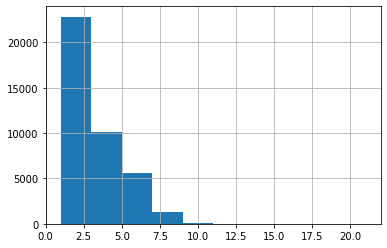

In [70]:
temp.hist()

In [71]:
temp.value_counts()

1     16547
2      6294
3      5306
4      4799
5      3606
6      2043
7      1022
8       283
9        76
10       19
11        3
21        1
13        1
Name: cuisine, dtype: int64

It is clear that most of the database restaurants have only 1 cuisine in their menu* and more then 80% of them** serve only 4 or less cuisines in their menu. We will use this information to break restaurants in 3 groups in our new column: 
1. serving 1 cuisine 
2. serving 2 to 4 cuisines
3. serving more than 4 cuisines

\* - *restaurants with 'nan' information on cuisines they serve are assumed to have at least 1 cuisine* 

\** - *around 32 000 of 40 000*

In [161]:
df['cuisines_count']=df.cuisine.apply(c_count_groups)

In [162]:
df.cuisines_count

0        2
1        1
2        3
3        1
4        2
        ..
39995    2
39996    3
39997    2
39998    3
39999    1
Name: cuisines_count, Length: 40000, dtype: int64

Investigating popularity of cuisines among restaurants:

In [163]:
freq = {} 
for cuisine in cuisines:  
    freq[cuisine] = 0
for record in df.cuisine:   
    for cuisine in record:  
        freq[cuisine] += 1  

In [164]:
popularity=pd.Series(freq).sort_values(ascending=False)
popularity

VegetarianFriendly    11189
European              10060
nan                    9283
Mediterranean          6277
Italian                5964
                      ...  
Yunnan                    1
Latvian                   1
Salvadoran                1
Xinjiang                  1
Burmese                   1
Length: 126, dtype: int64

In [165]:
df.cuisine.head(3)

0                    [European, French, International]
1                                                [nan]
2    [Japanese, Sushi, Asian, Grill, VegetarianFrie...
Name: cuisine, dtype: object

It is clear that some cuisines are much more popular in restaurants than the others, so the fact that the restaurant is serving dishes of one cuisine and not serving dishes from other one might affect the rating. There's a huge number of restaurants with 'nan' information on this topic (9283 !) we cannot remove that much information from datasheet and at this very step we do not have enough information to replace 'nan' to smth more useful. So we will break restaurants in 3 groups:
1. serving top-10 cuisines according to popularity list attained above
2. with 'nan' information 
3. the rest

This information will be then added to a new column in datasheet. If some particular restaurant serves cuisines from different groups then it is assigned to a group which is more popular. 

In [166]:
top_10=popularity.quantile(0.90)

In [167]:
popularity[popularity<top_10]=3
popularity[popularity.index=='nan']=2
popularity[popularity>=top_10]=1

In [168]:
df['c_popularity']=df.cuisine.apply(p_count_groups)

In [169]:
df['c_popularity']

0        1
1        2
2        1
3        2
4        1
        ..
39995    1
39996    1
39997    3
39998    1
39999    1
Name: c_popularity, Length: 40000, dtype: int64

#### reviews

In [170]:
df.reviews.head()

0    [['Good food at your doorstep', 'A good hotel ...
1    [['Unique cuisine', 'Delicious Nepalese food']...
2    [['Catch up with friends', 'Not exceptional'],...
3                                             [[], []]
4    [['Best place to try a Bavarian food', 'Nice b...
Name: reviews, dtype: object

In [171]:
df.reviews[0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [172]:
df.reviews[1]

"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"

In [173]:
df.reviews.describe()

count        40000
unique       33516
top       [[], []]
freq          6471
Name: reviews, dtype: object

This column expectedly has many unique records, but in general data is presented here is either equal to \'[[], []]' (meaning there are no reviews on restaurant) or is presented in a format of \'[[text], [date,date]]'. Text part is hardly useful, but dates contain some important information, so the text part is to be thrown away and the dates are to be kept.

In [174]:
pattern=re.compile('\d\d/\d\d/\d\d*')

In [175]:
df.reviews=df.reviews.apply(lambda x:pattern.findall(str(x)) )

In [176]:
df.reviews=df.reviews.apply(str_clean)

In [177]:
df.reviews.head()

0    12/31/2017,11/20/2017
1    07/06/2017,06/19/2016
2    01/08/2018,01/06/2018
3                         
4    11/18/2017,02/19/2017
Name: reviews, dtype: object

In [178]:
df.reviews.describe()

count     40000
unique    24606
top            
freq       6471
Name: reviews, dtype: object

In [179]:
df.reviews.head(20)

0     12/31/2017,11/20/2017
1     07/06/2017,06/19/2016
2     01/08/2018,01/06/2018
3                          
4     11/18/2017,02/19/2017
5     09/16/2017,05/31/2017
6     08/04/2017,11/05/2017
7     02/16/2014,06/13/2012
8                          
9     11/07/2017,03/27/2017
10                         
11    12/15/2017,11/22/2017
12    01/07/2018,12/27/2017
13    07/25/2017,05/30/2017
14                         
15    12/01/2017,09/14/2017
16               04/12/2017
17    02/28/2017,10/31/2016
18    08/16/2017,10/21/2016
19    04/12/2016,08/13/2015
Name: reviews, dtype: object

We will add to the dataframe 2 new columns with the freshest date of reviews and the difference in time between the two reviews.

In [180]:
df['rev_date']=df.reviews.apply(date_selection)

In [181]:
df.rev_date.describe()

count                   28973
unique                   1498
top       2018-01-07 00:00:00
freq                      515
first     2008-04-07 00:00:00
last      2018-02-26 00:00:00
Name: rev_date, dtype: object

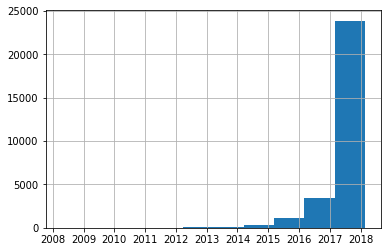

In [182]:
df.rev_date.hist();

In [183]:
df.rev_date.fillna(df.rev_date.mean(),inplace=True)

In [184]:
df.rev_date=outliers(df.rev_date)

Minor boundries are (2016-12-09 03:39:05.038474240,2018-06-23 12:12:32.976915456)
 There are 4016 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


In [185]:
df.rev_date=df.rev_date.apply(lambda x: round((x-datetime.datetime(1970, 1,1)).days),0)

In [186]:
df.rev_date.describe()

count     40000
unique     1498
top       17354
freq      11060
Name: rev_date, dtype: int64

In [187]:
df.rev_date=df.rev_date/df.rev_date.mean()

In [188]:
df.rev_date

0         1.01017
1        0.999915
2         1.01063
3        0.999972
4         1.00769
           ...   
39995     1.00931
39996      1.0096
39997    0.985797
39998      1.0002
39999    0.969836
Name: rev_date, Length: 40000, dtype: object

In [189]:
df['rev_date_delta']=df.reviews.apply(date_delta)

In [190]:
df.rev_date_delta=df.rev_date_delta[~df.rev_date_delta.isna()].dt.days.astype('int16')

Too many empty reviews, not enough information to fill them with some useful information. All those empty reviews we will replace with -1 to separate them from the others that have at least 1 review.

In [191]:
df.rev_date_delta.fillna(-1,inplace=True)

In [192]:
df.rev_date_delta.describe()

count    40000.000000
mean       102.370000
std        198.737148
min         -1.000000
25%         -1.000000
50%         28.000000
75%        120.000000
max       3207.000000
Name: rev_date_delta, dtype: float64

In [193]:
df.rev_date_delta.value_counts()

-1.0       11027
 1.0         664
 2.0         523
 3.0         496
 0.0         492
           ...  
 2940.0        1
 1818.0        1
 1032.0        1
 722.0         1
 1543.0        1
Name: rev_date_delta, Length: 1229, dtype: int64

In [194]:
df.rev_date_delta.max()

3207.0

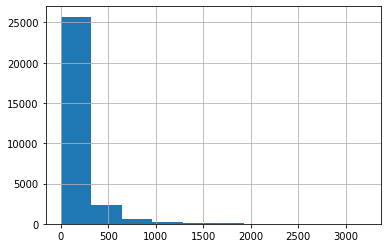

In [195]:
df.rev_date_delta[df.rev_date_delta>=0].hist();

In [196]:
df.rev_date_delta=outliers(df.rev_date_delta)

Minor boundries are (-182.5,301.5)
 There are 3565 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


In [197]:
df.rev_date_delta=outliers(df.rev_date_delta)

Minor boundries are (-182.5,301.5)
 There are 3565 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


#### number_of_reviews

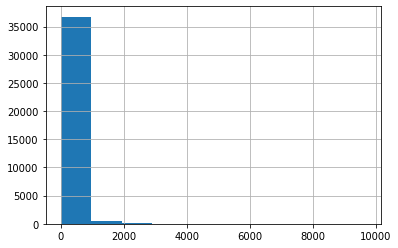

In [198]:
df.number_of_reviews.hist()

In [199]:
df.number_of_reviews.describe()

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

In [200]:
df.number_of_reviews=outliers(df.number_of_reviews)

Minor boundries are (-150.0,274.0)
 There are 4348 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


Too many outlying values , cannot be cleared, but it is highly possible that the outlying part itself has outlying positions.

In [201]:
df.number_of_reviews[df.number_of_reviews>274]=\
outliers(df.number_of_reviews[df.number_of_reviews>274])

Minor boundries are (-277.875,1407.125)
 There are 316 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


In [202]:
df.number_of_reviews.fillna(df.number_of_reviews.mean(),inplace=True)

In [203]:
df.number_of_reviews.describe()

count    40000.000000
mean       106.223150
std        181.044762
min          2.000000
25%         10.000000
50%         38.000000
75%        106.223150
max       1407.000000
Name: number_of_reviews, dtype: float64

#### ranking

In [204]:
df.ranking.describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

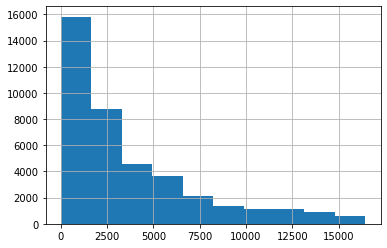

In [205]:
df.ranking.hist()

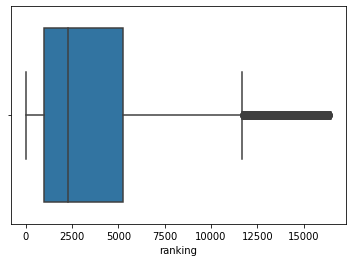

In [206]:
sns.boxplot(df.ranking)

In [207]:
df.ranking=outliers(df.ranking)

Minor boundries are (-5457.5,11690.5)
 There are 2450 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


In [208]:
df.ranking.fillna(df.ranking.mean(),inplace=True)

#### rating

In [209]:
df.rating.describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [210]:
df.rating.value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

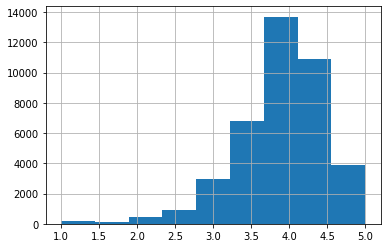

In [211]:
df.rating.hist(bins=df.rating.nunique())

In [212]:
df.rating=outliers(df.rating)

Minor boundries are (2.0,6.0)
 There are 340 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


In [213]:
df.rating.fillna(df.rating.mean(),inplace=True);

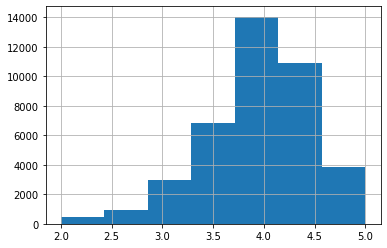

In [214]:
df.rating.hist(bins=7);

### DATA ANALYSIS

In [215]:
df.columns

Index(['rest_id', 'city', 'cuisine', 'ranking', 'rating', 'price_range',
       'number_of_reviews', 'reviews', 'cuisines_count', 'c_popularity',
       'rev_date', 'rev_date_delta'],
      dtype='object')

In [216]:
numeric=['cuisines_count','ranking','number_of_reviews',
         'rev_date_delta','rating']
categorial=['city', 'price_range','c_popularity', 'rev_date']

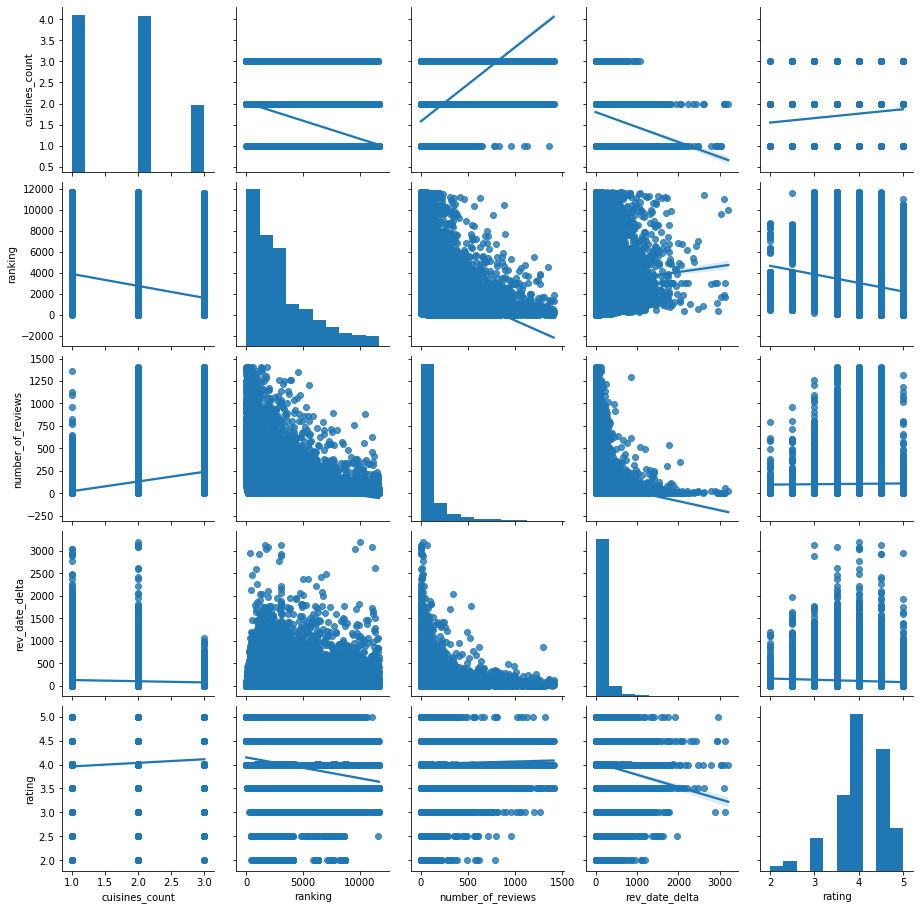

In [217]:
sns.pairplot(df[numeric], kind='reg')

In [218]:
df[numeric].corr()

cuisines_count   ranking  number_of_reviews  \
cuisines_count           1.000000 -0.312863           0.436637   
ranking                 -0.312863  1.000000          -0.270931   
number_of_reviews        0.436637 -0.270931           1.000000   
rev_date_delta          -0.096570  0.041209          -0.111386   
rating                   0.088866 -0.187883           0.014785   

                   rev_date_delta    rating  
cuisines_count          -0.096570  0.088866  
ranking                  0.041209 -0.187883  
number_of_reviews       -0.111386  0.014785  
rev_date_delta           1.000000 -0.082561  
rating                  -0.082561  1.000000

For both numeric and category data no obviously strong correlation found out.

In [219]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='rating', data=df)
    ax.set_title('Boxplot for ' + column)
    plt.show()

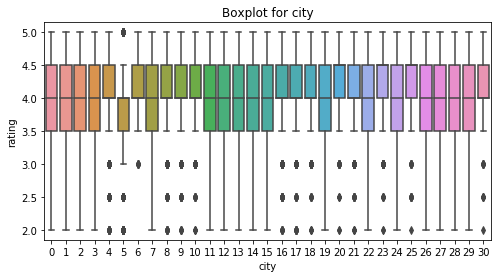

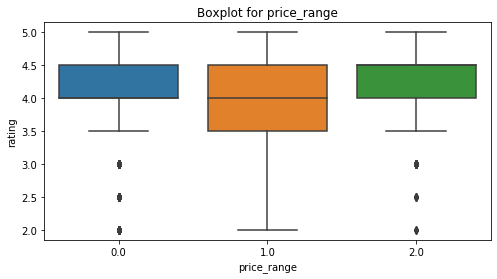

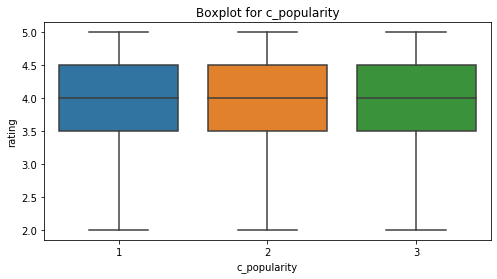

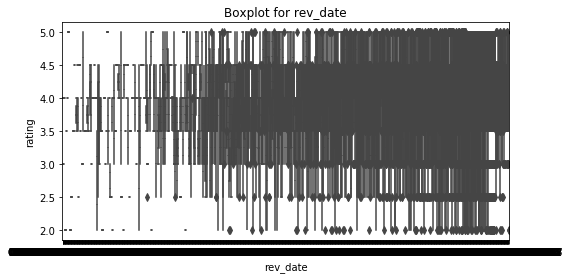

In [220]:
for column in categorial:
    get_boxplot(column)

### MACHINE LEARNING

In [234]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = df.drop(['rest_id', 'rating','reviews','cuisine'], axis = 1)  
y = df['rating']  
  
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [235]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [236]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.22151728700698878
